In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

In [4]:
##### Limit GPU for training ###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# File loading
### read hopital names from datasets ###
df = pd.read_csv(r'../datasets/hospital_augment_train6_3.csv')

In [6]:
df.head()

,gen_data,true_data
0,-รงพยาบาลกรุงเทพพิษณุโลก,โรงพยาบาลกรุงเทพพิษณุโลก
1,.รงพยาบาลกะปงชัยพัฒน์,โรงพยาบาลกะปงชัยพัฒน์
2,(รงพยาบาลแกดำ,โรงพยาบาลแกดำ
3,(ลินิกเวชกรรมจุฬารัตน์4,คลินิกเวชกรรมจุฬารัตน์4
4,(้าน,บ้าน


In [7]:
df_new = df.sample(frac=1)

In [8]:
hospital_gen_train = list(df_new['gen_data'])
hospital_true_train = list(df_new['true_data'])

In [9]:
df_test = pd.read_csv(r'../datasets/hospital_augment_test6_3.csv')

In [10]:
hospital_gen_test = list(df_test['gen_data'])
hospital_true_test = list(df_test['true_data'])

In [11]:
len(hospital_gen_train)

85707

In [12]:
# Preprocessing
import re
def process(sent):
    sent=sent.lower()
    sent=re.sub(r'[^0-9a-zA-Z ]','',sent)
    sent=sent.replace('\n','')
    return sent 

In [13]:
from pythainlp import thai_letters

In [14]:
label_map_0 = ["0","1","2","3","4","5","6","7","8","9","-",".","/","(",")","\"","&"]
label_map_1 = list(thai_letters)

In [15]:
char_set = label_map_0+label_map_1

In [16]:
char2int = { char_set[x]:x for x in range(len(char_set)) }
int2char = { char2int[x]:x for x in char_set }

In [17]:

count = len(char_set)
codes = ['\t' ,'\n', ' ']

In [18]:
for i in range(len(codes)):
    code = codes[i]
    char2int[code]=count
    int2char[count]=code
    count+=1

In [19]:
input_texts = []
target_texts = []

In [20]:
hospital_gen_train[:10]

['โรงพยาบาลสมเดจพระสังฆราชองค์ท่าี19',
 'โรพยาบาลศรีวิไล',
 'โรงพาบาลบ้านนาสาร',
 'อินทัชเมดิแคร์คลินิกเวชกรรมสาขาบางฏขน',
 'โรงพยาบาลดอนตาล',
 'โรแงพยาบาลคลองหลวง',
 'สถานพยาบาลนราการแพทธ์',
 'โรงพยาบานาหมื่น',
 'ศูนย์การแพทย์สมเด็จพวระเทพรัตนราชสุดาฯ',
 'สถคบัฃกัลยาณ์รชนครินทร์']

In [21]:
for i,line in enumerate(hospital_true_train):
    output_text = '\t' + line + '\n'
    input_texts.append(hospital_gen_train[i].replace('\u200b',''))
    target_texts.append(output_text.replace('\u200b',''))
print("LEN OF SAMPLES:",len(input_texts))

LEN OF SAMPLES: 85707


In [22]:
input_texts[0],target_texts[0]

('โรงพยาบาลสมเดจพระสังฆราชองค์ท่าี19',
 '\tโรงพยาบาลสมเด็จพระสังฆราชองค์ที่19\n')

In [23]:
max_enc_len = max([len(x)+x.count(' ') for x in input_texts])
max_dec_len = max([len(x)+x.count(' ') for x in target_texts])
print("Max Enc Len:",max_enc_len)
print("Max Dec Len:",max_dec_len)

Max Enc Len: 78
Max Dec Len: 75


In [24]:
num_samples = len(input_texts)
encoder_input_data = np.zeros( (num_samples , max_enc_len , len(char_set)+3),dtype='float32' )
decoder_input_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32' )
decoder_target_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [25]:
encoder_input_data.shape,decoder_input_data.shape,decoder_target_data.shape

((85707, 78, 93), (85707, 75, 93), (85707, 75, 93))

In [26]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")         

COMPLETED...


In [27]:
len(input_texts),len(target_texts)

(85707, 85707)

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense,Activation,Attention,Bidirectional,Concatenate
import tensorflow as tf

In [29]:
batch_size = 128
epochs = 100
latent_dim = 128

num_enc_tokens = len(char_set)+3
num_dec_tokens = len(char_set) + 3 # includes \n \t ' '
encoder_inputs = Input(shape=(None,num_enc_tokens))
encoder = Bidirectional(LSTM(latent_dim,return_state=True))
#encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
#encoder_outputs , state_h, state_c = encoder(encoder_inputs)
#encoder_states = [state_h,state_c]
#encoder_states = [ forward_h, forward_c, backward_h, backward_c]
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

In [30]:
decoder_inputs = Input(shape=(None,num_dec_tokens))
decoder_lstm = LSTM(latent_dim*2,return_sequences=True,return_state=True)
decoder_ouputs,_,_ = decoder_lstm(decoder_inputs,initial_state = encoder_states)

In [31]:
num_dec_tokens

93

In [32]:
decoder_dense = Dense(num_dec_tokens, activation='softmax')
decoder_ouputs = decoder_dense(decoder_ouputs)

In [33]:
model = Model([encoder_inputs,decoder_inputs],decoder_ouputs)
#model = Model.add(Attention())
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 256), (None, 227328      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]          

In [32]:
### Model includes only true sequence ###
earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='loss', min_delta=0.0001,
  patience=20)

saveModel_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath= "models/bilstm_hosipital_gendata_v6",
            save_best_only=True,
            monitor='loss',
            save_weights_only = True,
            verbose=1)
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-4 * 0.95 ** x)

In [33]:
hist=model.fit([encoder_input_data,decoder_input_data],decoder_target_data
         ,epochs = 100,validation_split=0.1,
          batch_size = batch_size,callbacks=[earlystop_callback,saveModel_callback])

411e-04 - categorical_accuracy: 0.2940 - val_loss: 0.0027 - val_categorical_accuracy: 0.2925
Epoch 43/100
77056/77136 [============================>.] - ETA: 0s - loss: 7.0190e-04 - categorical_accuracy: 0.2940
Epoch 00043: loss improved from 0.00072 to 0.00070, saving model to models/bilstm_hosipital_gendata_v6
77136/77136 [==============================] - 31s 396us/sample - loss: 7.0162e-04 - categorical_accuracy: 0.2939 - val_loss: 0.0028 - val_categorical_accuracy: 0.2934
Epoch 44/100
77056/77136 [============================>.] - ETA: 0s - loss: 5.5926e-04 - categorical_accuracy: 0.2944
Epoch 00044: loss improved from 0.00070 to 0.00056, saving model to models/bilstm_hosipital_gendata_v6
77136/77136 [==============================] - 30s 390us/sample - loss: 5.5942e-04 - categorical_accuracy: 0.2944 - val_loss: 0.0030 - val_categorical_accuracy: 0.2926
Epoch 45/100
77056/77136 [============================>.] - ETA: 0s - loss: 0.0013 - categorical_accuracy: 0.2932
Epoch 00045: lo

In [34]:
import matplotlib.pyplot as plt

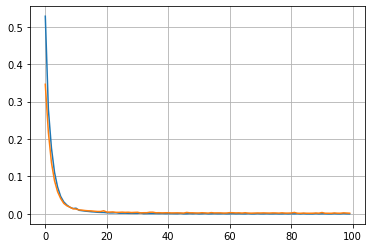

In [35]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.grid()

In [36]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
decoder_outputs,state_h,state_c = decoder_lstm(
        decoder_inputs,initial_state = decoder_states_inputs
)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
encoder_model.save('encoder_v12.h5')
decoder_model.save('decoder_v12.h5')

In [57]:
[decoder_inputs] + decoder_states_inputs

[<tf.Tensor 'input_4_1:0' shape=(None, None, 93) dtype=float32>,
 <tf.Tensor 'input_5:0' shape=(None, 256) dtype=float32>,
 <tf.Tensor 'input_6:0' shape=(None, 256) dtype=float32>]

In [58]:
[decoder_outputs] + decoder_states

[<tf.Tensor 'dense_2/Identity:0' shape=(None, None, 93) dtype=float32>,
 <tf.Tensor 'lstm_3_1/Identity_1:0' shape=(None, 256) dtype=float32>,
 <tf.Tensor 'lstm_3_1/Identity_2:0' shape=(None, 256) dtype=float32>]

In [48]:
encoder_inputs.shape

TensorShape([None, None, 93])

In [38]:
enc = Model(encoder)

2

In [34]:
from tensorflow.keras.models import load_model

In [35]:
encoder_model = load_model('encoder_v12.h5',compile=False)

In [36]:
decoder_model = load_model('decoder_v12.h5',compile=False)

In [37]:
def decode_sequence(input_seq,num_dec_tokens=len(int2char),max_dec_len=78):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_dec_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char2int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    decoded_list =[]
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int2char[sampled_token_index]
        decoded_sentence += sampled_char
        decoded_list.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_dec_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence,decoded_list

In [107]:
count =7931

In [33]:
 input_seq = encoder_input_data[0: 0 + 1]

In [34]:
states_value = encoder_model.predict(input_seq)

In [40]:
target_seq = np.zeros((1, 1, num_dec_tokens))
# Populate the first character of target sequence with the start character.
target_seq[0, 0, char2int['\t']] = 1.

In [41]:
output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

In [44]:
np.argmax(output_tokens[0, -1, :])

75

In [46]:
len([target_seq] + states_value)

3

In [ ]:
pred_sent_train = []
for seq_index in range(num_samples):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent_train.append(lst)
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', decoded_sentence)
    print('Ground Truth:',target_texts[seq_index])

-
Wrong sentence: โรงพยวาบาลพนมดงรัก เฉลิมฃพระญใกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลพนมดงรัก เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลพนมดงรัก เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลฅพนมสารคาม
Corrected sentence: โรงพยาบาลพนมสารคาม

Ground Truth: 	โรงพยาบาลพนมสารคาม

-
Wrong sentence: โรงพยบาลพบพระ
Corrected sentence: โรงพยาบาลพบพระ

Ground Truth: 	โรงพยาบาลพบพระ

-
Wrong sentence: โรงยาบาลยัคฆภูมิพิสัย
Corrected sentence: โรงพยาบาลพยัคฆภูมิพิสัย

Ground Truth: 	โรงพยาบาลพยัคฆภูมิพิสัย

-
Wrong sentence: โรงพยาๆบาลพยุห์
Corrected sentence: โรงพยาบาลพยุห์

Ground Truth: 	โรงพยาบาลพยุห์

-
Wrong sentence: โรงพยาบาลพยุชหะคีรี
Corrected sentence: โรงพยาบาลพยุหะคีรี

Ground Truth: 	โรงพยาบาลพยุหะคีรี

-
Wrong sentence: โรงพยาบาลพรหมฌคีรี
Corrected sentence: โรงพยาบาลพรหมคีรี

Ground Truth: 	โรงพยาบาลพรหมคีรี

-
Wrong sentence: โรงะยาบาลพรหมพิราม
Corrected sentence: โรงพยาบาลพรหมพิราม

Ground Truth: 	โรงพยาบาลพรหมพิราม

-
Wrong sentence: โรงพยาบาลพระทแงฒคำ เฉิ

-
Wrong sentence: โรงพยาบาลมหาวิทยาลัยเทคโนโลยีสุรนารี
Corrected sentence: โรงพยาบาลมหาวิทยาลัยเทคโนโลยีสุรนารี

Ground Truth: 	โรงพยาบาลมหาวิทยาลัยเทคโนโลยีสุรนารี

-
Wrong sentence: โรงพศยาบาลมหาสารคาม
Corrected sentence: โรงพยาบาลมหาสารคาม

Ground Truth: 	โรงพยาบาลมหาสารคาม

-
Wrong sentence: โรงพยาบาลมหาสารคามอินเตอๆร์เนชั่นแนล
Corrected sentence: โรงพยาบาลมหาสารคามอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลมหาสารคามอินเตอร์เนชั่นแนล

-
Wrong sentence: โรงพาบาฐลมะการักษ์
Corrected sentence: โรงพยาบาลมะการักษ์

Ground Truth: 	โรงพยาบาลมะการักษ์

-
Wrong sentence: โรง4ยาบาลมะขาม
Corrected sentence: โรงพยาบาลมะขาม

Ground Truth: 	โรงพยาบาลมะขาม

-
Wrong sentence: โรงพยา4บาลมะนัง
Corrected sentence: โรงพยาบาลมะนัง

Ground Truth: 	โรงพยาบาลมะนัง

-
Wrong sentence: โรงพยาบาลมะเร็งฟชลบุรี
Corrected sentence: โรงพยาบาลมะเร็งชลบุรี

Ground Truth: 	โรงพยาบาลมะเร็งชลบุรี

-
Wrong sentence: โรงพยาบาลมะเร็งลพบุัรี
Corrected sentence: โรงพยาบาลมะเร็งลพบุรี

Ground Truth: 	โรงพยาบาลมะเร็งลพบุรี



-
Wrong sentence: โรงพยาบาลราษีฏศล
Corrected sentence: โรงพยาบาลราษีไศล

Ground Truth: 	โรงพยาบาลราษีไศล

-
Wrong sentence: โรงพยาบาลรือเสะ
Corrected sentence: โรงพยาบาลรือเสาะ

Ground Truth: 	โรงพยาบาลรือเสาะ

-
Wrong sentence: โรงพยืบาลโรคผิวหนังเขตร้อนภาคใต้ จังหวัดตัง
Corrected sentence: โรงพยาบาลโรคผิวหนังเขตร้อนภาคใต้ จังหวัดตรัง

Ground Truth: 	โรงพยาบาลโรคผิวหนังเขตร้อนภาคใต้ จังหวัดตรัง

-
Wrong sentence: โรงพยาบา้ละอุ่น
Corrected sentence: โรงพยาบาลละอุ่น

Ground Truth: 	โรงพยาบาลละอุ่น

-
Wrong sentence: โรงพยาบาลลาพดบัวหลวง
Corrected sentence: โรงพยาบาลลาดบัวหลวง

Ground Truth: 	โรงพยาบาลลาดบัวหลวง

-
Wrong sentence: โรงพยาบาลลนสะกา
Corrected sentence: โรงพยาบาลลานสะกา

Ground Truth: 	โรงพยาบาลลานสะกา

-
Wrong sentence: โรงพยาบาลลำหดวน
Corrected sentence: โรงพยาบาลลำดวน

Ground Truth: 	โรงพยาบาลลำดวน

-
Wrong sentence: โรงพยาบาลลำทฌับ
Corrected sentence: โรงพยาบาลลำทับ

Ground Truth: 	โรงพยาบาลลำทับ

-
Wrong sentence: โรงฌพยาบลลำปลายมาศ
Corrected sentence: โรงพยาบาลลำปลายมา

-
Wrong sentence: โรงพยาบาลศกีสาคร
Corrected sentence: โรงพยาบาลศรีสาคร

Ground Truth: 	โรงพยาบาลศรีสาคร

-
Wrong sentence: โรงพไยาบาลศาลายา
Corrected sentence: โรงพยาบาลศาลายา

Ground Truth: 	โรงพยาบาลศาลายา

-
Wrong sentence: โรงพยาบา9ศิครินทร์
Corrected sentence: โรงพยาบาลศิครินทร์

Ground Truth: 	โรงพยาบาลศิครินทร์

-
Wrong sentence: โรพยาบาลศิครินทร์หาดใหญ่
Corrected sentence: โรงพยาบาลศิครินทร์หาดใหญ่

Ground Truth: 	โรงพยาบาลศิครินทร์หาดใหญ่

-
Wrong sentence: โรงพยาาลศิริราชปิยมหาราชการุณย์
Corrected sentence: โรงพยาบาลศิริราชปิยมหาราชการุณย์

Ground Truth: 	โรงพยาบาลศิริราชปิยมหาราชการุณย์

-
Wrong sentence: โรงืยาบาลศิริราชพยาบาล
Corrected sentence: โรงพยาบาลศิริราชพยาบาล

Ground Truth: 	โรงพยาบาลศิริราชพยาบาล

-
Wrong sentence: โรงพยาบาลศิริพวชลาพูน
Corrected sentence: โรงพยาบาลศิริเวชลาพูน

Ground Truth: 	โรงพยาบาลศิริเวชลาพูน

-
Wrong sentence: โรง4พยาบาลศิลาลาด
Corrected sentence: โรงพยาบาลศิลาลาด

Ground Truth: 	โรงพยาบาลศิลาลาด

-
Wrong sentence: โรงพยาบาลศุกร์ศะริศรีสว

-
Wrong sentence: โรงพยาบาลสมิติเวชศทฤีราชา
Corrected sentence: โรงพยาบาลสมิติเวชศรีราชา

Ground Truth: 	โรงพยาบาลสมิติเวชศรีราชา

-
Wrong sentence: โรงพยาบาลโมุทรปรจการ
Corrected sentence: โรงพยาบาลสมุทรปราการ

Ground Truth: 	โรงพยาบาลสมุทรปราการ

-
Wrong sentence: โรงพยาบาลสมุทรสาร
Corrected sentence: โรงพยาบาลสมุทรสาคร

Ground Truth: 	โรงพยาบาลสมุทรสาคร

-
Wrong sentence: โรงพยซา์าลสมงยอินเตอร์เนชั่นแนิ
Corrected sentence: โรงพยาบาลสมุยอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลสมุยอินเตอร์เนชั่นแนล

-
Wrong sentence: โรงพยาบาลสยามราษฎร์เชีฬยงัณหม่
Corrected sentence: โรงพยาบาลสยามราษฎร์เชียงใหม่

Ground Truth: 	โรงพยาบาลสยามราษฎร์เชียงใหม่

-
Wrong sentence: โรบงดยาบาลสรรคบุรี
Corrected sentence: โรงพยาบาลสรรคบุรี

Ground Truth: 	โรงพยาบาลสรรคบุรี

-
Wrong sentence: โรงพยาบาลสรรพงิทธิประสงค์
Corrected sentence: โรงพยาบาลสรรพสิทธิประสงค์

Ground Truth: 	โรงพยาบาลสรรพสิทธิประสงค์

-
Wrong sentence: โรงพยาบาลสระถบสถ์
Corrected sentence: โรงพยาบาลสระโบสถ์

Ground Truth: 	โรงพยาบาลสระโบ

-
Wrong sentence: โรงพยาบ็าลหนองแสง
Corrected sentence: โรงพยาบาลหนองแสง

Ground Truth: 	โรงพยาบาลหนองแสง

-
Wrong sentence: โรงพยถบาลหนองหงส์
Corrected sentence: โรงพยาบาลหนองหงส์

Ground Truth: 	โรงพยาบาลหนองหงส์

-
Wrong sentence: โรง-พยาบาลหนองฮี
Corrected sentence: โรงพยาบาลหนองฮี

Ground Truth: 	โรงพยาบาลหนองฮี

-
Wrong sentence: โรงพยาบาลหชลวงพ่อเปิ่น
Corrected sentence: โรงพยาบาลหลวงพ่อเปิ่น

Ground Truth: 	โรงพยาบาลหลวงพ่อเปิ่น

-
Wrong sentence: โรงพึาบาลหลังสวูน
Corrected sentence: โรงพยาบาลหลังสวน

Ground Truth: 	โรงพยาบาลหลังสวน

-
Wrong sentence: โรง&พย่าบาลห้วยกระเจาูเฉูิมพระเกียรติ ย80 พรรา
Corrected sentence: โรงพยาบาลห้วยกระเจา เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลห้วยกระเจา เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพย้าบาลห้วยเก้ง
Corrected sentence: โรงพยาบาลห้วยเกิ้ง

Ground Truth: 	โรงพยาบาลห้วยเกิ้ง

-
Wrong sentence: โรงพฌาบาลห้วยคต
Corrected sentence: โรงพยาบาลห้วยคต

Ground Truth: 	โรงพยาบาลห้วยคต

-
Wrong sentence: โรงพยาบาลห้วยถลง
Corrected

-
Wrong sentence: สถาบันโรคทรวือก
Corrected sentence: สถาบันโรคทรวงอก

Ground Truth: 	สถาบันโรคทรวงอก

-
Wrong sentence: สถาบันโรคผิวหนัง
Corrected sentence: สถาบันโรคผิวหนัง

Ground Truth: 	สถาบันโรคผิวหนัง

-
Wrong sentence: สถาฆบันวิจัยการแพย์(ผนไทย
Corrected sentence: สถาบันวิจัยการแพทย์แผนไทย

Ground Truth: 	สถาบันวิจัยการแพทย์แผนไทย

-
Wrong sentence: สถาบันสิรินธรเพื่อการฟื้ฟูสมรรถฒาพทางการแพทย์แห่งชาติ
Corrected sentence: สถาบันสิรินธรเพื่อการฟื้นฟูสมรรถภาพทางการแพทย์แห่งชาติ

Ground Truth: 	สถาบันสิรินธรเพื่อการฟื้นฟูสมรรถภาพทางการแพทย์แห่งชาติ

-
Wrong sentence: สถาบันสิุขภาพจิตเด็ก๊และวัย"ุ่นําคตะ-วัออกเฉียงเหนือ
Corrected sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคตะวันออกเฉียงเหนือ

Ground Truth: 	สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคตะวันออกเฉียงเหนือ

-
Wrong sentence: สถาบันุขภาพจิฝตเด็กและวัยรุ่นภาคใต้
Corrected sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคใต้

Ground Truth: 	สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคใต้

-
Wrong sentence: สถาบันสุขภาพเด็กแห่งชาติมหารญชินี
Corrected sent

-
Wrong sentence: เซ็นทรัลเมดิก"ลินิกเวชกรรฉสาขารัชดา
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขารัชดา

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขารัชดา

-
Wrong sentence: เทเล(แค)์คลินิกเจริญกรุง
Corrected sentence: เทเลแคร์คลินิกเจริญกรุง

Ground Truth: 	เทเลแคร์คลินิกเจริญกรุง

-
Wrong sentence: เทเลแฺคร์คลินิกสหคลินิกสาขาวล์รพล
Corrected sentence: เทเลแคร์คลินิกสหคลินิกสาขาวัชรพล

Ground Truth: 	เทเลแคร์คลินิกสหคลินิกสาขาวัชรพล

-
Wrong sentence: เทเล์แคล์คลินิกถุขาภิบาล3
Corrected sentence: เทเลแคร์คลินิกสุขาภิบาล3

Ground Truth: 	เทเลแคร์คลินิกสุขาภิบาล3

-
Wrong sentence: ธรรํสุนทรคลิิกเวชกรรมสแขาคลองสาน
Corrected sentence: ธรรมสุนทรคลินิกเวชกรรมสาขาคลองสาน

Ground Truth: 	ธรรมสุนทรคลินิกเวชกรรมสาขาคลองสาน

-
Wrong sentence: เปสโลเมโ.รียลรังสิตคลินิกเวชกรรม
Corrected sentence: เปาโลเมโมเรียลรังสิตคลินิกเวชกรรม

Ground Truth: 	เปาโลเมโมเรียลรังสิตคลินิกเวชกรรม

-
Wrong sentence: ฟรีโซนคลินิเวชโรรม
Corrected sentence: ฟรีโซนคลินิกเวชกรรม

Ground Truth: 	ฟรีโซนคลินิกเวชกรร

-
Wrong sentence: โรนพยาบาลขอนแก่น
Corrected sentence: โรงพยาบาลขอนแก่น

Ground Truth: 	โรงพยาบาลขอนแก่น

-
Wrong sentence: โรงพยาบาลิขาณุวรลักษบไรี
Corrected sentence: โรงพยาบาลขาณุวรลักษบุรี

Ground Truth: 	โรงพยาบาลขาณุวรลักษบุรี

-
Wrong sentence: โรงพยาบาลขามทะเลส
Corrected sentence: โรงพยาบาลขามทะเลสอ

Ground Truth: 	โรงพยาบาลขามทะเลสอ

-
Wrong sentence: โรงพยาบาลขามสะแกแสง
Corrected sentence: โรงพยาบาลขามสะแกแสง

Ground Truth: 	โรงพยาบาลขามสะแกแสง

-
Wrong sentence: โรงพยบาลขุขันธ์
Corrected sentence: โรงพยาบาลขุขันธ์

Ground Truth: 	โรงพยาบาลขุขันธ์

-
Wrong sentence: โรฤพยษบาลขุนยวม
Corrected sentence: โรงพยาบาลขุนยวม

Ground Truth: 	โรงพยาบาลขุนยวม

-
Wrong sentence: โรงพยาบาลขุนหากญ
Corrected sentence: โรงพยาบาลขุนหาญ

Ground Truth: 	โรงพยาบาลขุนหาญ

-
Wrong sentence: โรง9ยาบงลเขไลางค์นครราม
Corrected sentence: โรงพยาบาลเขลางค์นครราม

Ground Truth: 	โรงพยาบาลเขลางค์นครราม

-
Wrong sentence: โรง๊ยาบลเขวาสินรินทร์
Corrected sentence: โรงพยาบาลเขวาสินรินทร์

Ground Truth: 	โรงพ

-
Wrong sentence: โรงพยาบาชัยซรุณเวชการ
Corrected sentence: โรงพยาบาลชัยอรุณเวชการ

Ground Truth: 	โรงพยาบาลชัยอรุณเวชการ

-
Wrong sentence: โรงพยาซบาลช้างเผือก
Corrected sentence: โรงพยาบาลช้างเผือก

Ground Truth: 	โรงพยาบาลช้างเผือก

-
Wrong sentence: โรงพยปาบาลชาติตระการ
Corrected sentence: โรงพยาบาลชาติตระการ

Ground Truth: 	โรงพยาบาลชาติตระการ

-
Wrong sentence: โรงพยาบาลชานมาน
Corrected sentence: โรงพยาบาลชานุมาน

Ground Truth: 	โรงพยาบาลชานุมาน

-
Wrong sentence: โรงพยาบาลชฒ่นชม
Corrected sentence: โรงพยาบาลชื่นชม

Ground Truth: 	โรงพยาบาลชื่นชม

-
Wrong sentence: โรงพยาบาชุมตาบง
Corrected sentence: โรงพยาบาลชุมตาบง

Ground Truth: 	โรงพยาบาลชุมตาบง

-
Wrong sentence: โรงพิฃยาบาลชุมพรเขตรอุดมศักดิ์
Corrected sentence: โรงพยาบาลชุมพรเขตรอุดมศักดิ์

Ground Truth: 	โรงพยาบาลชุมพรเขตรอุดมศักดิ์

-
Wrong sentence: โรงพยาบาลชคมพลบุรี
Corrected sentence: โรงพยาบาลชุมพลบุรี

Ground Truth: 	โรงพยาบาลชุมพลบุรี

-
Wrong sentence: โรงพคยาบาลชุมแพ
Corrected sentence: โรงพยาบาลชุมแพ

Ground Tr

-
Wrong sentence: โรงพยาบาลท่าใษหม่
Corrected sentence: โรงพยาบาลท่าใหม่

Ground Truth: 	โรงพยาบาลท่าใหม่

-
Wrong sentence: โรงพยาบาล่าอุเทน
Corrected sentence: โรงพยาบาลท่าอุเทน

Ground Truth: 	โรงพยาบาลท่าอุเทน

-
Wrong sentence: โรงพยาบาลษุ)งเขาหลวง
Corrected sentence: โรงพยาบาลทุ่งเขาหลวง

Ground Truth: 	โรงพยาบาลทุ่งเขาหลวง

-
Wrong sentence: โรงพยาบาลทุ่งตณาก
Corrected sentence: โรงพยาบาลทุ่งตะโก

Ground Truth: 	โรงพยาบาลทุ่งตะโก

-
Wrong sentence: โรงพยาบาลทุ่8งโพธิ์ทะเล
Corrected sentence: โรงพยาบาลทุ่งโพธิ์ทะเล

Ground Truth: 	โรงพยาบาลทุ่งโพธิ์ทะเล

-
Wrong sentence: โรงนยาบาลทุ่งยางแดง
Corrected sentence: โรงพยาบาลทุ่งยางแดง

Ground Truth: 	โรงพยาบาลทุ่งยางแดง

-
Wrong sentence: โรงพยาบาลทุ่"ศรีอุดม
Corrected sentence: โรงพยาบาลทุ่งศรีอุดม

Ground Truth: 	โรงพยาบาลทุ่งศรีอุดม

-
Wrong sentence: โรชงพยาบาลทุ่งเสลียม
Corrected sentence: โรงพยาบาลทุ่งเสลี่ยม

Ground Truth: 	โรงพยาบาลทุ่งเสลี่ยม

-
Wrong sentence: โรงพยาบาลทุ่งหว้
Corrected sentence: โรงพยาบาลทุ่งหว้า

Ground T

-
Wrong sentence: โรณงพยาบาลน้ำโสม
Corrected sentence: โรงพยาบาลน้ำโสม

Ground Truth: 	โรงพยาบาลน้ำโสม

-
Wrong sentence: โรงพย-าบาลน้ำหนาว
Corrected sentence: โรงพยาบาลน้ำหนาว

Ground Truth: 	โรงพยาบาลน้ำหนาว

-
Wrong sentence: โรงพยาบาลนิค๊น้อูน
Corrected sentence: โรงพยาบาลนิคมน้ำอูน

Ground Truth: 	โรงพยาบาลนิคมน้ำอูน

-
Wrong sentence: โรๅพยาบาลนิคฑมพัฒนา
Corrected sentence: โรงพยาบาลนิคมพัฒนา

Ground Truth: 	โรงพยาบาลนิคมพัฒนา

-
Wrong sentence: โรงพยาบาลเนินญขาม
Corrected sentence: โรงพยาบาลเนินขาม

Ground Truth: 	โรงพยาบาลเนินขาม

-
Wrong sentence: โรงพยาบาลใเนินมะปราใ
Corrected sentence: โรงพยาบาลเนินมะปราง

Ground Truth: 	โรงพยาบาลเนินมะปราง

-
Wrong sentence: โรงพยาบ9ลโนนไทย
Corrected sentence: โรงพยาบาลโนนไทย

Ground Truth: 	โรงพยาบาลโนนไทย

-
Wrong sentence: โรงพยาบาลโนนนารยณ์
Corrected sentence: โรงพยาบาลโนนนารายณ์

Ground Truth: 	โรงพยาบาลโนนนารายณ์

-
Wrong sentence: โรงพยาบาุโนนศิลา
Corrected sentence: โรงพยาบาลโนนศิลา

Ground Truth: 	โรงพยาบาลโนนศิลา

-
Wrong sentence

-
Wrong sentence: โรงพยาบาลเบต
Corrected sentence: โรงพยาบาลเบตง

Ground Truth: 	โรงพยาบาลเบตง

-
Wrong sentence: โรงพยาบาลปทุมะานถี
Corrected sentence: โรงพยาบาลปทุมธานี

Ground Truth: 	โรงพยาบาลปทุมธานี

-
Wrong sentence: โรงยาบาลปทุมรัตต์
Corrected sentence: โรงพยาบาลปทุมรัตต์

Ground Truth: 	โรงพยาบาลปทุมรัตต์

-
Wrong sentence: โรงพยาบาลปอุมราชวงศา
Corrected sentence: โรงพยาบาลปทุมราชวงศา

Ground Truth: 	โรงพยาบาลปทุมราชวงศา

-
Wrong sentence: โรงพยาฃาลประโคนช/ย
Corrected sentence: โรงพยาบาลประโคนชัย

Ground Truth: 	โรงพยาบาลประโคนชัย

-
Wrong sentence: โรงพย0บาลประจวบคีรีขันธ์
Corrected sentence: โรงพยาบาลประจวบคีรีขันธ์

Ground Truth: 	โรงพยาบาลประจวบคีรีขันธ์

-
Wrong sentence: โรงพยาาลประจักษ์ศิลปางคม
Corrected sentence: โรงพยาบาลประจักษ์ศิลปาคม

Ground Truth: 	โรงพยาบาลประจักษ์ศิลปาคม

-
Wrong sentence: โรงพยาบาลประชาธิปัตย์
Corrected sentence: โรงพยาบาลประชาธิปัตย์

Ground Truth: 	โรงพยาบาลประชาธิปัตย์

-
Wrong sentence: โรงพยาบาลประชาพัไฒน์
Corrected sentence: โรงพยาบาลประช

-
Wrong sentence: โรงพยาบาลพหลพลพยุห7เสกนา
Corrected sentence: โรงพยาบาลพหลพลพยุหเสนา

Ground Truth: 	โรงพยาบาลพหลพลพยุหเสนา

-
Wrong sentence: โรงพยวบาถลพ่อทฯ่านคลายวาจาสิทธิ์
Corrected sentence: โรงพยาบาลพ่อท่านคล้ายวาจาสิทธิ์

Ground Truth: 	โรงพยาบาลพ่อท่านคล้ายวาจาสิทธิ์

-
Wrong sentence: โรงพยาบาศพะงยาราม
Corrected sentence: โรงพยาบาลพะเยาราม

Ground Truth: 	โรงพยาบาลพะเยาราม

-
Wrong sentence: โรงพยาบาลพัใฒนเวชสุโขทัย
Corrected sentence: โรงพยาบาลพัฒนเวชสุโขทัย

Ground Truth: 	โรงพยาบาลพัฒนเวชสุโขทัย

-
Wrong sentence: โรงพยาบาลพัฒนา๎ิฃม
Corrected sentence: โรงพยาบาลพัฒนานิคม

Ground Truth: 	โรงพยาบาลพัฒนานิคม

-
Wrong sentence: โรงพยาบาลพัรทยาเมโมวเรียล
Corrected sentence: โรงพยาบาลพัทยาเมโมเรียล

Ground Truth: 	โรงพยาบาลพัทยาเมโมเรียล

-
Wrong sentence: โรงพยาบาลพ&ัทลุง
Corrected sentence: โรงพยาบาลพัทลุง

Ground Truth: 	โรงพยาบาลพัทลุง

-
Wrong sentence: โรงพยบาลพานทอง
Corrected sentence: โรงพยาบาลพานทอง

Ground Truth: 	โรงพยาบาลพานทอง

-
Wrong sentence: โรงพยาบาลพิบูลมผังสา

-
Wrong sentence: โรงพยาบาลแมื่แตง
Corrected sentence: โรงพยาบาลแม่แตง

Ground Truth: 	โรงพยาบาลแม่แตง

-
Wrong sentence: โรงพยาบาลแฃม่ทะ
Corrected sentence: โรงพยาบาลแม่ทะ

Ground Truth: 	โรงพยาบาลแม่ทะ

-
Wrong sentence: โรงพยาบาลแม่ท๋
Corrected sentence: โรงพยาบาลแม่ทา

Ground Truth: 	โรงพยาบาลแม่ทา

-
Wrong sentence: โรงพยาบาลแม่พรก
Corrected sentence: โรงพยาบาลแม่พริก

Ground Truth: 	โรงพยาบาลแม่พริก

-
Wrong sentence: โรงพยาบาลแม่ฟ้า3ภหลวง
Corrected sentence: โรงพยาบาลแม่ฟ้าหลวง

Ground Truth: 	โรงพยาบาลแม่ฟ้าหลวง

-
Wrong sentence: โรงพยาบาลแม่เ์ฯาะ
Corrected sentence: โรงพยาบาลแม่เมาะ

Ground Truth: 	โรงพยาบาลแม่เมาะ

-
Wrong sentence: โรงพยาบ4ลแม่ระมาด
Corrected sentence: โรงพยาบาลแม่ระมาด

Ground Truth: 	โรงพยาบาลแม่ระมาด

-
Wrong sentence: โรงพยฆบาลแต่ลาน้อย
Corrected sentence: โรงพยาบาลแม่ลาน้อย

Ground Truth: 	โรงพยาบาลแม่ลาน้อย

-
Wrong sentence: โรงพยาบาลแม่วง
Corrected sentence: โรงพยาบาลแม่วาง

Ground Truth: 	โรงพยาบาลแม่วาง

-
Wrong sentence: โรงพยาบาลแึม่สรวย
Correct

-
Wrong sentence: โรงพยาบาลวังน้ำเียว
Corrected sentence: โรงพยาบาลวังน้ำเขียว

Ground Truth: 	โรงพยาบาลวังน้ำเขียว

-
Wrong sentence: โรงพยาาลังโป่ง
Corrected sentence: โรงพยาบาลวังโป่ง

Ground Truth: 	โรงพยาบาลวังโป่ง

-
Wrong sentence: โรงพยาาลวังม่วงสัทธรรภ
Corrected sentence: โรงพยาบาลวังม่วงสัทธรรม

Ground Truth: 	โรงพยาบาลวังม่วงสัทธรรม

-
Wrong sentence: โรงพย็บาลวังวิเศษ
Corrected sentence: โรงพยาบาลวังวิเศษ

Ground Truth: 	โรงพยาบาลวังวิเศษ

-
Wrong sentence: โรงพยาบาลวังสมูรณ์
Corrected sentence: โรงพยาบาลวังสมบูรณ์

Ground Truth: 	โรงพยาบาลวังสมบูรณ์

-
Wrong sentence: โรงพยาแบาลวังสามหมอ
Corrected sentence: โรงพยาบาลวังสามหมอ

Ground Truth: 	โรงพยาบาลวังสามหมอ

-
Wrong sentence: โรงพยาบาลวัด1ันทร์ เฉลิมพระเกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลวัดจันทร์ เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลวัดจันทร์ เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลวัดญาณสังวราราุม
Corrected sentence: โรงพยาบาลวัดญาณสังวราราม

Ground Truth: 	โรงพยาบาลวัดญาณสังวราราม


-
Wrong sentence: โรงพยาถบาลส่งเสริมสุโภหพ ศูนย์นามัวยที่11
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่11

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่11

-
Wrong sentence: โรงพยาบาลส่งเซริมสุญภาพ ูนย์อนามัยที่4
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่4

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่4

-
Wrong sentence: โรงพยาบา4ลส่งเสริมสุขภาพเชียชใหม่
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพเชียงใหม่

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพเชียงใหม่

-
Wrong sentence: โรงพยาบาสตึก
Corrected sentence: โรงพยาบาลสตึก

Ground Truth: 	โรงพยาบาลสตึก

-
Wrong sentence: โรงพุาบาลสตูล
Corrected sentence: โรงพยาบาลสตูล

Ground Truth: 	โรงพยาบาลสตูล

-
Wrong sentence: โรงพยาบาฏสนามจันทร์
Corrected sentence: โรงพยาบาลสนามจันทร์

Ground Truth: 	โรงพยาบาลสนามจันทร์

-
Wrong sentence: โรงพ1ยาบาลสนามชัยเขต
Corrected sentence: โรงพยาบาลสนามชัยเขต

Ground Truth: 	โรงพยาบาลสนามชัยเขต

-
Wrong sentence: โรงขยาบาลสบปราบ
Corrected sentence: โรงพยาบาลสบปรา

-
Wrong sentence: โรงพย่บาลสอยดาว
Corrected sentence: โรงพยาบาลสอยดาว

Ground Truth: 	โรงพยาบาลสอยดาว

-
Wrong sentence: โรงพยาอาลสะเดา
Corrected sentence: โรงพยาบาลสะเดา

Ground Truth: 	โรงพยาบาลสะเดา

-
Wrong sentence: โรงพยา3าลสังขละบุรี
Corrected sentence: โรงพยาบาลสังขละบุรี

Ground Truth: 	โรงพยาบาลสังขละบุรี

-
Wrong sentence: โรงพยาบาลสงคม
Corrected sentence: โรงพยาบาลสังคม

Ground Truth: 	โรงพยาบาลสังคม

-
Wrong sentence: โรงพยาบาลสัหีบกม10
Corrected sentence: โรงพยาบาลสัตหีบกม10

Ground Truth: 	โรงพยาบาลสัตหีบกม10

-
Wrong sentence: โรงพยาบาลากเหล็ก
Corrected sentence: โรงพยาบาลสากเหล็ก

Ground Truth: 	โรงพยาบาลสากเหล็ก

-
Wrong sentence: โรงโยาบาลสามโคก
Corrected sentence: โรงพยาบาลสามโคก

Ground Truth: 	โรงพยาบาลสามโคก

-
Wrong sentence: โรงพยฆบาลอามง่าม
Corrected sentence: โรงพยาบาลสามง่าม

Ground Truth: 	โรงพยาบาลสามง่าม

-
Wrong sentence: โรงพยาาลสามเงา
Corrected sentence: โรงพยาบาลสามเงา

Ground Truth: 	โรงพยาบาลสามเงา

-
Wrong sentence: โรงพยาบาลสาม4ชุก
Corrected sente

-
Wrong sentence: โรงพยาบาลหาญอินเตอร์เนชั่นแนล
Corrected sentence: โรงพยาบาลหาญอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลหาญอินเตอร์เนชั่นแนล

-
Wrong sentence: โรงพยาบาลหาดสำราญเฉลิมพระเกียรติ ใ0 พฮรษา
Corrected sentence: โรงพยาบาลหาดสำราญเฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลหาดสำราญเฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลเจหือคลอง
Corrected sentence: โรงพยาบาลเหนือคลอง

Ground Truth: 	โรงพยาบาลเหนือคลอง

-
Wrong sentence: โรงพยาบาลเหล่าเสือโก้ก
Corrected sentence: โรงพยาบาลเหล่าเสือโก้ก

Ground Truth: 	โรงพยาบาลเหล่าเสือโก้ก

-
Wrong sentence: โรงพยาบาลแหลฑฉบัง
Corrected sentence: โรงพยาบาลแหลมฉบัง

Ground Truth: 	โรงพยาบาลแหลมฉบัง

-
Wrong sentence: โรงพยาบาปลแหีมสิงห์
Corrected sentence: โรงพยาบาลแหลมสิงห์

Ground Truth: 	โรงพยาบาลแหลมสิงห์

-
Wrong sentence: โรงพยาบาลองค์กาุบริหารส"วนจังหวัดภูเ.็ต
Corrected sentence: โรงพยาบาลองค์การบริหารส่วนจังหวัดภูเก็ต

Ground Truth: 	โรงพยาบาลองค์การบริหารส่วนจังหวัดภูเก็ต

-
Wrong sentence: โรงพยาบาลองรักษ์
Correc

-
Wrong sentence: สหคลินิกกล้วยน้ไทสาขาสาทผร
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขาสาทร

Ground Truth: 	สหคลินิกกล้วยน้ำไทสาขาสาทร

-
Wrong sentence: สหคลินิกกล้วยน้ไฑสาขาสุข8ุมวิท101/1
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขาสุขุมวิท101/1

Ground Truth: 	สหคลินิกกล้วยน้ำไทสาขาสุขุมวิท101/1

-
Wrong sentence: สหคลินิกกล้7วยน้ำไทสาขาห้วยขวาง
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขาห้วยขวาง

Ground Truth: 	สหคลินิกกล้วยน้ำไทสาขาห้วยขวาง

-
Wrong sentence: สหคลิน&กกฉ้วย.น้ำไทสาขาอโศก
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขาอโศก

Ground Truth: 	สหคลินิกกล้วยน้ำไทสาขาอโศก

-
Wrong sentence: สหคลินกสมิติเวช
Corrected sentence: สหคลินิกสมิติเวช

Ground Truth: 	สหคลินิกสมิติเวช

-
Wrong sentence: สาผย่านคลินิกเวชกรรม
Corrected sentence: สามย่านคลินิกเวชกรรม

Ground Truth: 	สามย่านคลินิกเวชกรรม

-
Wrong sentence: อิฅนทัชเมดิแคร์คล9ินิกเวชปกรรมสาขาดินแดง
Corrected sentence: อินทัชเมดิแคร์คลินิกเวชกรรมสาขาดินแดง

Ground Truth: 	อินทัชเมดิแคร์คลินิกเวชกรรมสาขาดินแดง

-
Wrong sentence: อิ

-
Wrong sentence: โรงพยาบาลกร๊ะบุรี
Corrected sentence: โรงพยาบาลกระบุรี

Ground Truth: 	โรงพยาบาลกระบุรี

-
Wrong sentence: โรงพยา๋าลกรแสัง
Corrected sentence: โรงพยาบาลกระสัง

Ground Truth: 	โรงพยาบาลกระสัง

-
Wrong sentence: โรงพยาบๆลกระแสสินธุ์
Corrected sentence: โรงพยาบาลกระแสสินธุ์

Ground Truth: 	โรงพยาบาลกระแสสินธุ์

-
Wrong sentence: โรงพยาพาุกรุงเทพ
Corrected sentence: โรงพยาบาลกรุงเทพ

Ground Truth: 	โรงพยาบาลกรุงเทพ

-
Wrong sentence: โรงพยาบกดลกรุงเทพขอนแก่น
Corrected sentence: โรงพยาบาลกรุงเทพขอนแก่น

Ground Truth: 	โรงพยาบาลกรุงเทพขอนแก่น

-
Wrong sentence: โรงพยาบา"กรุงเทพ8คริสเตียปนครึปฐม
Corrected sentence: โรงพยาบาลกรุงเทพคริสเตียนนครปฐม

Ground Truth: 	โรงพยาบาลกรุงเทพคริสเตียนนครปฐม

-
Wrong sentence: โรงพยาบาลกรุเ2พจันทบุรี
Corrected sentence: โรงพยาบาลกรุงเทพจันทบุรี

Ground Truth: 	โรงพยาบาลกรุงเทพจันทบุรี

-
Wrong sentence: โรงพยาบาลกรุงเทพจุรีเว้
Corrected sentence: โรงพยาบาลกรุงเทพจุรีเวช

Ground Truth: 	โรงพยาบาลกรุงเทพจุรีเวช

-
Wrong sentence: โรงพยาบาลกร

-
Wrong sentence: โรกพยาบาลคง
Corrected sentence: โรงพยาบาลคง

Ground Truth: 	โรงพยาบาลคง

-
Wrong sentence: โรงะ5พยาบาลคลองเขื่อน
Corrected sentence: โรงพยาบาลคลองเขื่อน

Ground Truth: 	โรงพยาบาลคลองเขื่อน

-
Wrong sentence: โรงพยาบาละลองท่จม
Corrected sentence: โรงพยาบาลคลองท่อม

Ground Truth: 	โรงพยาบาลคลองท่อม

-
Wrong sentence: โรงืยาบาลคลองลวง
Corrected sentence: โรงพยาบาลคลองหลวง

Ground Truth: 	โรงพยาบาลคลองหลวง

-
Wrong sentence: โรงพพ8าบาลคลองหอยโข่ง
Corrected sentence: โรงพยาบาลคลองหอยโข่ง

Ground Truth: 	โรงพยาบาลคลองหอยโข่ง

-
Wrong sentence: โรฺพยาบาลคลองหาด
Corrected sentence: โรงพยาบาลคลองหาด

Ground Truth: 	โรงพยาบาลคลองหาด

-
Wrong sentence: โรงพยซาบาลคลอ"ใหญ่
Corrected sentence: โรงพยาบาลคลองใหญ่

Ground Truth: 	โรงพยาบาลคลองใหญ่

-
Wrong sentence: โรงไพยาบาลควนขนุน
Corrected sentence: โรงพยาบาลควนขนุน

Ground Truth: 	โรงพยาบาลควนขนุน

-
Wrong sentence: โรงพยฯบาลควนโดน
Corrected sentence: โรงพยาบาลควนโดน

Ground Truth: 	โรงพยาบาลควนโดน

-
Wrong sentence: โรูพยาบาลคอน

-
Wrong sentence: โร๋งพยาบาลเชียงแสน
Corrected sentence: โรงพยาบาลเชียงแสน

Ground Truth: 	โรงพยาบาลเชียงแสน

-
Wrong sentence: โรงพยาบาลเชียงใหม่เมดิคอลเซ็นเตอร์
Corrected sentence: โรงพยาบาลเชียงใหม่เมดิคอลเซ็นเตอร์

Ground Truth: 	โรงพยาบาลเชียงใหม่เมดิคอลเซ็นเตอร์

-
Wrong sentence: โรงพยาบาธเชียงใหม่ราม
Corrected sentence: โรงพยาบาลเชียงใหม่ราม

Ground Truth: 	โรงพยาบาลเชียงใหม่ราม

-
Wrong sentence: โรงพแาบาลเชียรใหญ่
Corrected sentence: โรงพยาบาลเชียรใหญ่

Ground Truth: 	โรงพยาบาลเชียรใหญ่

-
Wrong sentence: โรงพยาบาลโชคชัฮ
Corrected sentence: โรงพยาบาลโชคชัย

Ground Truth: 	โรงพยาบาลโชคชัย

-
Wrong sentence: โรงพยาบาลดชยวาน
Corrected sentence: โรงพยาบาลไชยวาน

Ground Truth: 	โรงพยาบาลไชยวาน

-
Wrong sentence: โรสงพยาบาลไชยา
Corrected sentence: โรงพยาบาลไชยา

Ground Truth: 	โรงพยาบาลไชยา

-
Wrong sentence: โรงพยาบาลซานเ็.โลหัวหิน
Corrected sentence: โรงพยาบาลซานเปาโลหัวหิน

Ground Truth: 	โรงพยาบาลซานเปาโลหัวหิน

-
Wrong sentence: โรงพยาบาลซำเสูง
Corrected sentence: โรงพยาบาลซำส

-
Wrong sentence: โรงพยาบาลธนบร2
Corrected sentence: โรงพยาบาลธนบุรี2

Ground Truth: 	โรงพยาบาลธนบุรี2

-
Wrong sentence: โรงพยาบาลธนบุรรีชุมพร
Corrected sentence: โรงพยาบาลธนบุรีชุมพร

Ground Truth: 	โรงพยาบาลธนบุรีชุมพร

-
Wrong sentence: โรงพยาบาลธนบุปรีอู่ทอง
Corrected sentence: โรงพยาบาลธนบุรีอู่ทอง

Ground Truth: 	โรงพยาบาลธนบุรีอู่ทอง

-
Wrong sentence: โรงฮยาบาลธวัชบุรี
Corrected sentence: โรงพยาบาลธวัชบุรี

Ground Truth: 	โรงพยาบาลธวัชบุรี

-
Wrong sentence: โรงพยาิาลธัญญรักษ์ขอนแก่น
Corrected sentence: โรงพยาบาลธัญญรักษ์ขอนแก่น

Ground Truth: 	โรงพยาบาลธัญญรักษ์ขอนแก่น

-
Wrong sentence: โรงยาบาลธัญ2รักษ์ปัตตานี
Corrected sentence: โรงพยาบาลธัญญรักษ์ปัตตานี

Ground Truth: 	โรงพยาบาลธัญญรักษ์ปัตตานี

-
Wrong sentence: โรงพยาบาลธัญญษรักษ์แม่ฮ่องสอน
Corrected sentence: โรงพยาบาลธัญญรักษ์แม่ฮ่องสอน

Ground Truth: 	โรงพยาบาลธัญญรักษ์แม่ฮ่องสอน

-
Wrong sentence: โรง๎พยา์าลธัญญารักษ์เชียวใหม่
Corrected sentence: โรงพยาบาลธัญญารักษ์เชียงใหม่

Ground Truth: 	โรงพยาบาลธัญญารักษ์เชียงใ

-
Wrong sentence: โรงพยาบาบางระไำ
Corrected sentence: โรงพยาบาลบางระกำ

Ground Truth: 	โรงพยาบาลบางระกำ

-
Wrong sentence: โรงพยาบบาลบางระจัน
Corrected sentence: โรงพยาบาลบางระจัน

Ground Truth: 	โรงพยาบาลบางระจัน

-
Wrong sentence: โรงพยาบาลบางเษลน
Corrected sentence: โรงพยาบาลบางเลน

Ground Truth: 	โรงพยาบาลบางเลน

-
Wrong sentence: โรงพัาบาลบางสะพ1น
Corrected sentence: โรงพยาบาลบางสะพาน

Ground Truth: 	โรงพยาบาลบางสะพาน

-
Wrong sentence: โรงพยาบาลางอะพานน้อย
Corrected sentence: โรงพยาบาลบางสะพานน้อย

Ground Truth: 	โรงพยาบาลบางสะพานน้อย

-
Wrong sentence: โรงพยาบาลบางเฏสาธง
Corrected sentence: โรงพยาบาลบางเสาธง

Ground Truth: 	โรงพยาบาลบางเสาธง

-
Wrong sentence: โรงพาบาลบ้านเขว้า
Corrected sentence: โรงพยาบาลบ้านเขว้า

Ground Truth: 	โรงพยาบาลบ้านเขว้า

-
Wrong sentence: โรงพาเาลบ้านค่าย
Corrected sentence: โรงพยาบาลบ้านค่าย

Ground Truth: 	โรงพยาบาลบ้านค่าย

-
Wrong sentence: โรงพยาบาลบ้านดอนอินเึฯตร์เกาสมุย
Corrected sentence: โรงพยาบาลบ้านดอนอินเตอร์เกาะสมุย

Ground Truth: 	โรง

-
Wrong sentence: โรงพยาบาลปบยะเวชช์บ่ใวิง
Corrected sentence: โรงพยาบาลปิยะเวชช์บ่อวิน

Ground Truth: 	โรงพยาบาลปิยะเวชช์บ่อวิน

-
Wrong sentence: โรำพยาบาลปิยะเวท
Corrected sentence: โรงพยาบาลปิยะเวท

Ground Truth: 	โรงพยาบาลปิยะเวท

-
Wrong sentence: โรงพยฐบาลเปาโลเมูโมเรียล
Corrected sentence: โรงพยาบาลเปาโลเมโมเรียล

Ground Truth: 	โรงพยาบาลเปาโลเมโมเรียล

-
Wrong sentence: โรงพยาบาลเปาโลเฟปมโมเรียลชคชัย4
Corrected sentence: โรงพยาบาลเปาโลเมโมเรียลโชคชัย4

Ground Truth: 	โรงพยาบาลเปาโลเมโมเรียลโชคชัย4

-
Wrong sentence: โรงพยาบาๅเปือยนทอย
Corrected sentence: โรงพยาบาลเปือยน้อย

Ground Truth: 	โรงพยาบาลเปือยน้อย

-
Wrong sentence: โรงพฝาบาลแปลงยาว
Corrected sentence: โรงพยาบาลแปลงยาว

Ground Truth: 	โรงพยาบาลแปลงยาว

-
Wrong sentence: โรงพยาบาลโป่งนข้ำร้อน
Corrected sentence: โรงพยาบาลโป่งน้ำร้อน

Ground Truth: 	โรงพยาบาลโป่งน้ำร้อน

-
Wrong sentence: โรงพยาบาลผฅาขาว
Corrected sentence: โรงพยาบาลผาขาว

Ground Truth: 	โรงพยาบาลผาขาว

-
Wrong sentence: โรงพยา3บาเฝ้าไร่
Corrected sent

-
Wrong sentence: โรงพยบาลภั)ทรธนบุรี
Corrected sentence: โรงพยาบาลภัทรธนบุรี

Ground Truth: 	โรงพยาบาลภัทรธนบุรี

-
Wrong sentence: โรงพยาบาลภูกระฏึง
Corrected sentence: โรงพยาบาลภูกระดึง

Ground Truth: 	โรงพยาบาลภูกระดึง

-
Wrong sentence: โรงพยา5บาลภูกามยาว
Corrected sentence: โรงพยาบาลภูกามยาว

Ground Truth: 	โรงพยาบาลภูกามยาว

-
Wrong sentence: โรงพยาบลภูเขียวเฉลิ2พระเ&ีบยรติ
Corrected sentence: โรงพยาบาลภูเขียวเฉลิมพระเกียรติ

Ground Truth: 	โรงพยาบาลภูเขียวเฉลิมพระเกียรติ

-
Wrong sentence: โรงพยฑาบาลภูซาง
Corrected sentence: โรงพยาบาลภูซาง

Ground Truth: 	โรงพยาบาลภูซาง

-
Wrong sentence: โรงพยบาลภูเพียง
Corrected sentence: โรงพยาบาลภูเพียง

Ground Truth: 	โรงพยาบาลภูเพียง

-
Wrong sentence: โรงพยาบาลู่เรือ
Corrected sentence: โรงพยาบาลภูเรือ

Ground Truth: 	โรงพยาบาลภูเรือ

-
Wrong sentence: โรงพยาบาลปมงกุฎวัฒนะ
Corrected sentence: โรงพยาบาลมงกุฎวัฒนะ

Ground Truth: 	โรงพยาบาลมงกุฎวัฒนะ

-
Wrong sentence: โรงพยาบงลมหาราช
Corrected sentence: โรงพยาบาลมหาราช

Ground Truth: 	โรงพ

-
Wrong sentence: โรงพยาบา1รันบุรี
Corrected sentence: โรงพยาบาลรัตนบุรี

Ground Truth: 	โรงพยาบาลรัตนบุรี

-
Wrong sentence: โรงพยาบลรตนวาปี
Corrected sentence: โรงพยาบาลรัตนวาปี

Ground Truth: 	โรงพยาบาลรัตนวาปี

-
Wrong sentence: โรงพยูบาลรตาชดาเนินตรง
Corrected sentence: โรงพยาบาลราชดาเนินตรัง

Ground Truth: 	โรงพยาบาลราชดาเนินตรัง

-
Wrong sentence: โรงพยาบาลราชธานีโรจน็ะ
Corrected sentence: โรงพยาบาลราชธานีโรจนะ

Ground Truth: 	โรงพยาบาลราชธานีโรจนะ

-
Wrong sentence: โรงพยาบาลราชพฤกษ0์
Corrected sentence: โรงพยาบาลราชพฤกษ์

Ground Truth: 	โรงพยาบาลราชพฤกษ์

-
Wrong sentence: โรงพยาธาลราช5วิถี
Corrected sentence: โรงพยาบาลราชวิถี

Ground Truth: 	โรงพยาบาลราชวิถี

-
Wrong sentence: โรงพฝาลบาลราชเวชเชียงใหม่
Corrected sentence: โรงพยาบาลราชเวชเชียงใหม่

Ground Truth: 	โรงพยาบาลราชเวชเชียงใหม่

-
Wrong sentence: โรงพยาบาลราชเวชอฃฉุบลราชธานี
Corrected sentence: โรงพยาบาลราชเวชอุบลราชธานี

Ground Truth: 	โรงพยาบาลราชเวชอุบลราชธานี

-
Wrong sentence: โรพยาบาล๎รามคาแหง
Corrected sentenc

-
Wrong sentence: โรงพยาบาลแวงใหณ่
Corrected sentence: โรงพยาบาลแวงใหญ่

Ground Truth: 	โรงพยาบาลแวงใหญ่

-
Wrong sentence: โรงพยาบาลศรีเฮียงใหม่
Corrected sentence: โรงพยาบาลศรีเชียงใหม่

Ground Truth: 	โรงพยาบาลศรีเชียงใหม่

-
Wrong sentence: โรงพยาบาศรีณรงค์
Corrected sentence: โรงพยาบาลศรีณรงค์

Ground Truth: 	โรงพยาบาลศรีณรงค์

-
Wrong sentence: โรงพยาบาลศรีเท
Corrected sentence: โรงพยาบาลศรีเทพ

Ground Truth: 	โรงพยาบาลศรีเทพ

-
Wrong sentence: โรฉพยาบาลศรีนคร
Corrected sentence: โรงพยาบาลศรีนคร

Ground Truth: 	โรงพยาบาลศรีนคร

-
Wrong sentence: โรงพยาบฬาลศกรีนคริฮนทร์(ปัญญาไันทภิขุ)
Corrected sentence: โรงพยาบาลศรีนครินทร์(ปัญญานันทภิขุ)

Ground Truth: 	โรงพยาบาลศรีนครินทร์(ปัญญานันทภิขุ)

-
Wrong sentence: โรงพไาบ์ลศรีนคร7ินทร์ุหาวิทยาลัยขอนแก่นเฉพาะหอผู้ป่วยพิเศษช้ั์44
Corrected sentence: โรงพยาบาลศรีนครินทร์มหาวิทยาลัยขอนแก่นเฉพาะหอผู้ป่วยพิเศษช้ัน14

Ground Truth: 	โรงพยาบาลศรีนครินทร์มหาวิทยาลัยขอนแก่นเฉพาะหอผู้ป่วยพิเศษช้ัน14

-
Wrong sentence: โรงพยาปบาลศรีบรรพต
Corrected

-
Wrong sentence: โรธงพยาบาลสมเดจพระยุพราชุนครไทูย
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชนครไทย

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชนครไทย

-
Wrong sentence: โรงพยาบาลสมเด็จพระย3ิพราชบ้านดุง
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชบ้านดุง

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชบ้านดุง

-
Wrong sentence: โรงพยาบาลสม้เด็จพระยูพราชปัื
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชปัว

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชปัว

-
Wrong sentence: โรงพยาบาลสมเด็จพระยุพราฝเลิงนกทา
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชเลิงนกทา

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชเลิงนกทา

-
Wrong sentence: โรงพยาบาลสมเด็จพระยุพราชเวียงสระ
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชเวียงสระ

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชเวียงสระ

-
Wrong sentence: โรงพยาบาลสมด็1พระยุพราชสระแก้ว
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชสระแก้ว

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชสระแก้ว

-
Wrong sentence: โรงพยาบาลสฑเด็จพระยุพราชสว่างแดนดิน
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชสว

-
Wrong sentence: โรฒยาบาลสุไหงโก-ลก
Corrected sentence: โรงพยาบาลสุไหงโก-ลก

Ground Truth: 	โรงพยาบาลสุไหงโก-ลก

-
Wrong sentence: โรงพายาบาลสุไหง2าดี
Corrected sentence: โรงพยาบาลสุไหงปาดี

Ground Truth: 	โรงพยาบาลสุไหงปาดี

-
Wrong sentence: โรงพยาบาลสูงเนิช
Corrected sentence: โรงพยาบาลสูงเนิน

Ground Truth: 	โรงพยาบาลสูงเนิน

-
Wrong sentence: โร-งพยาบาลเสนา
Corrected sentence: โรงพยาบาลเสนา

Ground Truth: 	โรงพยาบาลเสนา

-
Wrong sentence: โรงพยาบาลเสนาคนิคม
Corrected sentence: โรงพยาบาลเสนางคนิคม

Ground Truth: 	โรงพยาบาลเสนางคนิคม

-
Wrong sentence: โรงพยาบาลเสริชมงาม
Corrected sentence: โรงพยาบาลเสริมงาม

Ground Truth: 	โรงพยาบาลเสริมงาม

-
Wrong sentence: โรงพยาบาลฟเสลภูมิ
Corrected sentence: โรงพยาบาลเสลภูมิ

Ground Truth: 	โรงพยาบาลเสลภูมิ

-
Wrong sentence: โรงพยาบาลเสไห้เฉลิมพุะเกียรติ80พรร็า
Corrected sentence: โรงพยาบาลเสาไห้เฉลิมพระเกียรติ80พรรษา

Ground Truth: 	โรงพยาบาลเสาไห้เฉลิมพระเกียรติ80พรรษา

-
Wrong sentence: โรงพยาบาหลเสิงสาง
Corrected sentence: โรงพยาบาลเสิงส

-
Wrong sentence: โรงพยาบาลเทอกช3บุรีรัมย์
Corrected sentence: โรงพยาบาลเอกชนบุรีรัมย์

Ground Truth: 	โรงพยาบาลเอกชนบุรีรัมย์

-
Wrong sentence: โรบงพยาาลเอกชนเมืองกาภแพง
Corrected sentence: โรงพยาบาลเอกชนเมืองกาแพง

Ground Truth: 	โรงพยาบาลเอกชนเมืองกาแพง

-
Wrong sentence: โรงพยาฉาลเอกชล
Corrected sentence: โรงพยาบาลเอกชล

Ground Truth: 	โรงพยาบาลเอกชล

-
Wrong sentence: โรงพยาบาลเอกนชล2
Corrected sentence: โรงพยาบาลเอกชล2

Ground Truth: 	โรงพยาบาลเอกชล2

-
Wrong sentence: โรงพยาบาๅลเอกชัย
Corrected sentence: โรงพยาบาลเอกชัย

Ground Truth: 	โรงพยาบาลเอกชัย

-
Wrong sentence: โรงพยาัถาลเอกอุดร
Corrected sentence: โรงพยาบาลเอกอุดร

Ground Truth: 	โรงพยาบาลเอกอุดร

-
Wrong sentence: โรงพยาบปลเอราวอณ
Corrected sentence: โรงพยาบาลเอราวัณ

Ground Truth: 	โรงพยาบาลเอราวัณ

-
Wrong sentence: โรงพยาบาลโอเวอรบรู๊ค
Corrected sentence: โรงพยาบาลโอเวอร์บรู๊ค

Ground Truth: 	โรงพยาบาลโอเวอร์บรู๊ค

-
Wrong sentence: โรงพยาบๆาลฮอด
Corrected sentence: โรงพยาบาลฮอด

Ground Truth: 	โรงพยาบาลฮอด

-
Wro

-
Wrong sentence: คลินิกเวชกรมกล้วศน้ำไทสาขาสุภาพงษ์3
Corrected sentence: คลินิกเวชกรรมกล้วยน้ำไทสาขาสุภาพงษ์3

Ground Truth: 	คลินิกเวชกรรมกล้วยน้ำไทสาขาสุภาพงษ์3

-
Wrong sentence: คลินิ4เวชกรรมจุฬารัตน์12(เกตเวย์)
Corrected sentence: คลินิกเวชกรรมจุฬารัตน์12(เกตเวย์)

Ground Truth: 	คลินิกเวชกรรมจุฬารัตน์12(เกตเวย์)

-
Wrong sentence: คลินิกเวชกรรฃจุฬารธตน์2
Corrected sentence: คลินิกเวชกรรมจุฬารัตน์2

Ground Truth: 	คลินิกเวชกรรมจุฬารัตน์2

-
Wrong sentence: คลินิกเวชกรรมจุฬารฒตน์4
Corrected sentence: คลินิกเวชกรรมจุฬารัตน์4

Ground Truth: 	คลินิกเวชกรรมจุฬารัตน์4

-
Wrong sentence: คลินิกเวชรรมจุฬารัตน์อาคเนย์
Corrected sentence: คลินิกเวชกรรมจุฬารัตน์อาคเนย์

Ground Truth: 	คลินิกเวชกรรมจุฬารัตน์อาคเนย์

-
Wrong sentence: คลินะิกเวชกรรมเฟิร์สวสเทอร์น
Corrected sentence: คลินิกเวชกรรมเฟิร์สเวสเทอร์น

Ground Truth: 	คลินิกเวชกรรมเฟิร์สเวสเทอร์น

-
Wrong sentence: คลินิกเวชกรรมเมโสฯขาซันทาาเวอร์สบี
Corrected sentence: คลินิกเวชกรรมเมโยสาขาซันทาวเวอร์สบี

Ground Truth: 	คลินิกเวชกรรม

-
Wrong sentence: โรงพยาบาลุมภวาปี
Corrected sentence: โรงพยาบาลกุมภวาปี

Ground Truth: 	โรงพยาบาลกุมภวาปี

-
Wrong sentence: โรงพยาบาลู่แก้ว
Corrected sentence: โรงพยาบาลกู่แก้ว

Ground Truth: 	โรงพยาบาลกู่แก้ว

-
Wrong sentence: โรงพยาบาลเกษตรสม-ูรณ์
Corrected sentence: โรงพยาบาลเกษตรสมบูรณ์

Ground Truth: 	โรงพยาบาลเกษตรสมบูรณ์

-
Wrong sentence: โรงพยาบาลเกษมรำาษฎร์บางแค
Corrected sentence: โรงพยาบาลเกษมราษฎร์บางแค

Ground Truth: 	โรงพยาบาลเกษมราษฎร์บางแค

-
Wrong sentence: โรงพย)าบฅลเกษมราษฎร์ปรชาชื่น
Corrected sentence: โรงพยาบาลเกษมราษฎร์ประชาชื่น

Ground Truth: 	โรงพยาบาลเกษมราษฎร์ประชาชื่น

-
Wrong sentence: โรงพยาบาลเกษมราษฎร์รัตนาธปเบศร์
Corrected sentence: โรงพยาบาลเกษมราษฎร์รัตนาธิเบศร์

Ground Truth: 	โรงพยาบาลเกษมราษฎร์รัตนาธิเบศร์

-
Wrong sentence: โรงพฝยาบาลเกษมราษฎร์ศรีบุรินทร์
Corrected sentence: โรงพยาบาลเกษมราษฎร์ศรีบุรินทร์

Ground Truth: 	โรงพยาบาลเกษมราษฎร์ศรีบุรินทร์

-
Wrong sentence: โรงพยาบาลเกะคา
Corrected sentence: โรงพยาบาลเกาะคา

Ground Truth: 	โรงพยาบา

-
Wrong sentence: โรงพฐาบาลจิตเวชนครสว4รรค์ราชนครินทร์
Corrected sentence: โรงพยาบาลจิตเวชนครสวรรค์ราชนครินทร์

Ground Truth: 	โรงพยาบาลจิตเวชนครสวรรค์ราชนครินทร์

-
Wrong sentence: โรงพ5าบาลจิยเวชเลยราชนครินทร์
Corrected sentence: โรงพยาบาลจิตเวชเลยราชนครินทร์

Ground Truth: 	โรงพยาบาลจิตเวชเลยราชนครินทร์

-
Wrong sentence: โรงยาบาลจิตเวชสงขลา6าชนครินร์
Corrected sentence: โรงพยาบาลจิตเวชสงขลาราชนครินทร์

Ground Truth: 	โรงพยาบาลจิตเวชสงขลาราชนครินทร์

-
Wrong sentence: โรงพยาบาลจิตเวชสระแก้วราปญนครร-นทร์
Corrected sentence: โรงพยาบาลจิตเวชสระแก้วราชนครรินทร์

Ground Truth: 	โรงพยาบาลจิตเวชสระแก้วราชนครรินทร์

-
Wrong sentence: โรงพยาบาลจุฬชารัตน์11
Corrected sentence: โรงพยาบาลจุฬารัตน์11

Ground Truth: 	โรงพยาบาลจุฬารัตน์11

-
Wrong sentence: โรงพยาฅาลจุฬารัตหน์9
Corrected sentence: โรงพยาบาลจุฬารัตน์9

Ground Truth: 	โรงพยาบาลจุฬารัตน์9

-
Wrong sentence: โรงพยาบาล1เจ็ดเสมียน
Corrected sentence: โรงพยาบาลเจ็ดเสมียน

Ground Truth: 	โรงพยาบาลเจ็ดเสมียน

-
Wrong sentence: โรงพาบาลเจริ

-
Wrong sentence: โรงพยาบาลเกิน
Corrected sentence: โรงพยาบาลเถิน

Ground Truth: 	โรงพยาบาลเถิน

-
Wrong sentence: โรงพยาบาลรายมูล
Corrected sentence: โรงพยาบาลทรายมูล

Ground Truth: 	โรงพยาบาลทรายมูล

-
Wrong sentence: โร-พยาบาลทองผะภูมิ
Corrected sentence: โรงพยาบาลทองผาภูมิ

Ground Truth: 	โรงพยาบาลทองผาภูมิ

-
Wrong sentence: โรงพยาบาลท6องแืนขัน
Corrected sentence: โรงพยาบาลทองแสนขัน

Ground Truth: 	โรงพยาบาลทองแสนขัน

-
Wrong sentence: โรงพยาบาลทับปุฒ
Corrected sentence: โรงพยาบาลทับปุด

Ground Truth: 	โรงพยาบาลทับปุด

-
Wrong sentence: โรงพยาบาลทฟบสะแก
Corrected sentence: โรงพยาบาลทับสะแก

Ground Truth: 	โรงพยาบาลทับสะแก

-
Wrong sentence: โรงึยาาลท่ากระดาน
Corrected sentence: โรงพยาบาลท่ากระดาน

Ground Truth: 	โรงพยาบาลท่ากระดาน

-
Wrong sentence: โรงพยาบาลฌ่าคนโท
Corrected sentence: โรงพยาบาลท่าคันโท

Ground Truth: 	โรงพยาบาลท่าคันโท

-
Wrong sentence: โรพยาบาลท่าแซะ
Corrected sentence: โรงพยาบาลท่าแซะ

Ground Truth: 	โรงพยาบาลท่าแซะ

-
Wrong sentence: โรพงพยาบาลท่าตะโก
Correct

-
Wrong sentence: โรงพยาบาลนผาฐหมื่น
Corrected sentence: โรงพยาบาลนาหมื่น

Ground Truth: 	โรงพยาบาลนาหมื่น

-
Wrong sentence: โรงพยาบาลน้ำเกลี้ฦยง
Corrected sentence: โรงพยาบาลน้ำเกลี้ยง

Ground Truth: 	โรงพยาบาลน้ำเกลี้ยง

-
Wrong sentence: โรงพยาบาลน้ำพอื
Corrected sentence: โรงพยาบาลน้ำพอง

Ground Truth: 	โรงพยาบาลน้ำพอง

-
Wrong sentence: โรงพยาบๆลน้ำภืน
Corrected sentence: โรงพยาบาลน้ำยืน

Ground Truth: 	โรงพยาบาลน้ำยืน

-
Wrong sentence: โรงพยาบาลน้ำโสคม
Corrected sentence: โรงพยาบาลน้ำโสม

Ground Truth: 	โรงพยาบาลน้ำโสม

-
Wrong sentence: โรงพยา๊าลน้ำหนาว
Corrected sentence: โรงพยาบาลน้ำหนาว

Ground Truth: 	โรงพยาบาลน้ำหนาว

-
Wrong sentence: โรงพยาบานิคมะคำสร้อย
Corrected sentence: โรงพยาบาลนิคมคำสร้อย

Ground Truth: 	โรงพยาบาลนิคมคำสร้อย

-
Wrong sentence: โรงพยาาลนิคมน้ำอูน
Corrected sentence: โรงพยาบาลนิคมน้ำอูน

Ground Truth: 	โรงพยาบาลนิคมน้ำอูน

-
Wrong sentence: โรงพฑยาบาลเนินขาม
Corrected sentence: โรงพยาบาลเนินขาม

Ground Truth: 	โรงพยาบาลเนินขาม

-
Wrong sentence: โรง

-
Wrong sentence: โรงพยาบาลบีแคร์เมดิซคอลเ๎ืซ็นเฆอร์
Corrected sentence: โรงพยาบาลบีแคร์เมดิคอลเซ็นเตอร์

Ground Truth: 	โรงพยาบาลบีแคร์เมดิคอลเซ็นเตอร์

-
Wrong sentence: โรงพยาบาลธบฅเอ็นเอช
Corrected sentence: โรงพยาบาลบีเอ็นเอช

Ground Truth: 	โรงพยาบาลบีเอ็นเอช

-
Wrong sentence: โรงพยาบาลบึงบูรพี
Corrected sentence: โรงพยาบาลบึงบูรพ์

Ground Truth: 	โรงพยาบาลบึงบูรพ์

-
Wrong sentence: โรงพยาบาลบ)ุ่งคล้า
Corrected sentence: โรงพยาบาลบุ่งคล้า

Ground Truth: 	โรงพยาบาลบุ่งคล้า

-
Wrong sentence: โรพยาบาลบุณฑริก
Corrected sentence: โรงพยาบาลบุณฑริก

Ground Truth: 	โรงพยาบาลบุณฑริก

-
Wrong sentence: โรงพยาบาฅลเบญจรมยส
Corrected sentence: โรงพยาบาลเบญจรมย์

Ground Truth: 	โรงพยาบาลเบญจรมย์

-
Wrong sentence: โรงพยาบาล.บญจลักษ์เฉลิมพระเียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลเบญจลักษ์เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลเบญจลักษ์เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาาลเบตง
Corrected sentence: โรงพยาบาลเบตง

Ground Truth: 	โรงพยาบาลเบตง

-
Wrong sentence: โร

-
Wrong sentence: โรงพยาบาลพระพรหลม
Corrected sentence: โรงพยาบาลพระพรหม

Ground Truth: 	โรงพยาบาลพระพรหม

-
Wrong sentence: โรงพยาบาลพระพุทฝธบาท
Corrected sentence: โรงพยาบาลพระพุทธบาท

Ground Truth: 	โรงพยาบาลพระพุทธบาท

-
Wrong sentence: โรงพยา.าลพระยืน
Corrected sentence: โรงพยาบาลพระยืน

Ground Truth: 	โรงพยาบาลพระยืน

-
Wrong sentence: โร6งพยาบาลพระราม2
Corrected sentence: โรงพยาบาลพระราม2

Ground Truth: 	โรงพยาบาลพระราม2

-
Wrong sentence: โรงพยาบาลพระ5า.เก้า
Corrected sentence: โรงพยาบาลพระรามเก้า

Ground Truth: 	โรงพยาบาลพระรามเก้า

-
Wrong sentence: โรงพยาบาลกพระศรีมฎหาโพธิ์
Corrected sentence: โรงพยาบาลพระศรีมหาโพธิ์

Ground Truth: 	โรงพยาบาลพระศรีมหาโพธิ์

-
Wrong sentence: โรงพยาบาลพ&ระอาจารย์แบน ธ์กโร
Corrected sentence: โรงพยาบาลพระอาจารย์แบน ธนากโร

Ground Truth: 	โรงพยาบาลพระอาจารย์แบน ธนากโร

-
Wrong sentence: โรงพยาบาลพระอ๋าจารย์ฝั้นอาจาโร
Corrected sentence: โรงพยาบาลพระอาจารย์ฝั้นอาจาโร

Ground Truth: 	โรงพยาบาลพระอาจารย์ฝั้นอาจาโร

-
Wrong sentence: โรงพยทบาพรานกร

-
Wrong sentence: โรงพยาบา8เมืองฎมุทรปากข้ำ
Corrected sentence: โรงพยาบาลเมืองสมุทรปากน้ำ

Ground Truth: 	โรงพยาบาลเมืองสมุทรปากน้ำ

-
Wrong sentence: โรงพยาบาลเมืองสมุทรปู่เจ้าสมิงพราย
Corrected sentence: โรงพยาบาลเมืองสมุทรปู่เจ้าสมิงพราย

Ground Truth: 	โรงพยาบาลเมืองสมุทรปู่เจ้าสมิงพราย

-
Wrong sentence: โรงพยาบาลเมืองสรณง
Corrected sentence: โรงพยาบาลเมืองสรวง

Ground Truth: 	โรงพยาบาลเมืองสรวง

-
Wrong sentence: โรงพยาบาลม่จัน
Corrected sentence: โรงพยาบาลแม่จัน

Ground Truth: 	โรงพยาบาลแม่จัน

-
Wrong sentence: โรงพยาบาลแมฤ่ใจ
Corrected sentence: โรงพยาบาลแม่ใจ

Ground Truth: 	โรงพยาบาลแม่ใจ

-
Wrong sentence: โรงพาบาลแม่พริก
Corrected sentence: โรงพยาบาลแม่พริก

Ground Truth: 	โรงพยาบาลแม่พริก

-
Wrong sentence: โรงพาบาลแม่ฟ้าหลวง
Corrected sentence: โรงพยาบาลแม่ฟ้าหลวง

Ground Truth: 	โรงพยาบาลแม่ฟ้าหลวง

-
Wrong sentence: โรงพฐาบาฅแม่เมาะ
Corrected sentence: โรงพยาบาลแม่เมาะ

Ground Truth: 	โรงพยาบาลแม่เมาะ

-
Wrong sentence: โร&พยาบาลแม่ลาน
Corrected sentence: โรงพยาบาลแม่ล

-
Wrong sentence: โรงพยาบาลวังน้ำเ)ย็น
Corrected sentence: โรงพยาบาลวังน้ำเย็น

Ground Truth: 	โรงพยาบาลวังน้ำเย็น

-
Wrong sentence: โรงพยาบาจลวังโป่ํ
Corrected sentence: โรงพยาบาลวังโป่ง

Ground Truth: 	โรงพยาบาลวังโป่ง

-
Wrong sentence: โรงพจยาบาลวังม่วงสัทธรรม
Corrected sentence: โรงพยาบาลวังม่วงสัทธรรม

Ground Truth: 	โรงพยาบาลวังม่วงสัทธรรม

-
Wrong sentence: โรงพยฆบาลวังยาง
Corrected sentence: โรงพยาบาลวังยาง

Ground Truth: 	โรงพยาบาลวังยาง

-
Wrong sentence: โรงพยาฤบาลวังวิเศษ
Corrected sentence: โรงพยาบาลวังวิเศษ

Ground Truth: 	โรงพยาบาลวังวิเศษ

-
Wrong sentence: โรงยาบาลวูังสามหมอ
Corrected sentence: โรงพยาบาลวังสามหมอ

Ground Truth: 	โรงพยาบาลวังสามหมอ

-
Wrong sentence: โรงพยางาลวังหิน
Corrected sentence: โรงพยาบาลวังหิน

Ground Truth: 	โรงพยาบาลวังหิน

-
Wrong sentence: โรงพำยาบาลวัฒนแพทย์ตรัง
Corrected sentence: โรงพยาบาลวัฒนแพทย์ตรัง

Ground Truth: 	โรงพยาบาลวัฒนแพทย์ตรัง

-
Wrong sentence: โรงพยาืาลัฒนานคร
Corrected sentence: โรงพยาบาลวัฒนานคร

Ground Truth: 	โรงพยาบ

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยท3ี่ 13
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 13

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 13

-
Wrong sentence: โรงพยาทาลส่งเสริมสุขภาพ ศูนย์อนามัยทีฃ 2
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 2

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 2

-
Wrong sentence: โรงพยาดาลส่งเสริมสุขภาพ ศูนยำดนามัยที่ 3
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 3

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 3

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนืมั/ยฦี่5
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 5

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 5

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 7
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 7

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 7

-
Wrong sentence: โรงพาบาลส่งเสริฌสุขภาพ ศูนยฦ"อาามัยที่10
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูน

-
Wrong sentence: โรงพยฏบาลสะเมิง
Corrected sentence: โรงพยาบาลสะเมิง

Ground Truth: 	โรงพยาบาลสะเมิง

-
Wrong sentence: โรพพยาบาลสังขละบุร.
Corrected sentence: โรงพยาบาลสังขละบุรี

Ground Truth: 	โรงพยาบาลสังขละบุรี

-
Wrong sentence: โรง.พยาบาลสังคม
Corrected sentence: โรงพยาบาลสังคม

Ground Truth: 	โรงพยาบาลสังคม

-
Wrong sentence: โรงพยาบาลสัตหีกม10
Corrected sentence: โรงพยาบาลสัตหีบกม10

Ground Truth: 	โรงพยาบาลสัตหีบกม10

-
Wrong sentence: โรงพยาบา8สันกำแพง
Corrected sentence: โรงพยาบาลสันกำแพง

Ground Truth: 	โรงพยาบาลสันกำแพง

-
Wrong sentence: โรงพยาบาลทันติสุข
Corrected sentence: โรงพยาบาลสันติสุข

Ground Truth: 	โรงพยาบาลสันติสุข

-
Wrong sentence: โรงพยาบาลสันป่าตง
Corrected sentence: โรงพยาบาลสันป่าตอง

Ground Truth: 	โรงพยาบาลสันป่าตอง

-
Wrong sentence: โรว8ยาบาลสากเหล็ก
Corrected sentence: โรงพยาบาลสากเหล็ก

Ground Truth: 	โรงพยาบาลสากเหล็ก

-
Wrong sentence: โรงพยาบะลสามโก้
Corrected sentence: โรงพยาบาลสามโก้

Ground Truth: 	โรงพยาบาลสามโก้

-
Wrong sentence: โรงพยาบา

-
Wrong sentence: โรงพยาบาลหาดงหญ่
Corrected sentence: โรงพยาบาลหาดใหญ่

Ground Truth: 	โรงพยาบาลหาดใหญ่

-
Wrong sentence: โรงขยาบาลแหลมฉบัง
Corrected sentence: โรงพยาบาลแหลมฉบัง

Ground Truth: 	โรงพยาบาลแหลมฉบัง

-
Wrong sentence: โรณงพยาบาลอรัญประเทศ
Corrected sentence: โรงพยาบาลอรัญประเทศ

Ground Truth: 	โรงพยาบาลอรัญประเทศ

-
Wrong sentence: โรงพยาบาลอากาอำนวย
Corrected sentence: โรงพยาบาลอากาศอำนวย

Ground Truth: 	โรงพยาบาลอากาศอำนวย

-
Wrong sentence: โรงพ์าบาลอ่างทอง้วชชการ2
Corrected sentence: โรงพยาบาลอ่างทองเวชชการ2

Ground Truth: 	โรงพยาบาลอ่างทองเวชชการ2

-
Wrong sentence: โรงพยไบาศอาจสามารถ
Corrected sentence: โรงพยาบาลอาจสามารถ

Ground Truth: 	โรงพยาบาลอาจสามารถ

-
Wrong sentence: โรงพยาบาญ่าวลึก
Corrected sentence: โรงพยาบาลอ่าวลึก

Ground Truth: 	โรงพยาบาลอ่าวลึก

-
Wrong sentence: โรงพยาบาลอำนฐจเจริญ
Corrected sentence: โรงพยาบาลอำนาจเจริญ

Ground Truth: 	โรงพยาบาลอำนาจเจริญ

-
Wrong sentence: โรงพยาบาลอินเตอร์เวชกาขร
Corrected sentence: โรงพยาบาลอินเตอร์เวชการ

Groun

-
Wrong sentence: อินทฟชเมดิแคร์คลินิกเวชกรรมสาขาราษฎร์บูรณะ
Corrected sentence: อินทัชเมดิแคร์คลินิกเวชกรรมสาขาราษฎร์บูรณะ

Ground Truth: 	อินทัชเมดิแคร์คลินิกเวชกรรมสาขาราษฎร์บูรณะ

-
Wrong sentence: คลินิกกรุงเทพพัทยาสาขาจมเทียน
Corrected sentence: คลินิกกรุงเทพพัทยาสาขาจอมเทียน

Ground Truth: 	คลินิกกรุงเทพพัทยาสาขาจอมเทียน

-
Wrong sentence: คลนิกกรุงเทพระยองสาขาบ้านฉาง
Corrected sentence: คลินิกกรุงเทพระยองสาขาบ้านฉาง

Ground Truth: 	คลินิกกรุงเทพระยองสาขาบ้านฉาง

-
Wrong sentence: คลินิกกรฯุงเทพระยองสาขาปลวกแดง
Corrected sentence: คลินิกกรุงเทพระยองสาขาปลวกแดง

Ground Truth: 	คลินิกกรุงเทพระยองสาขาปลวกแดง

-
Wrong sentence: คลินิกไทยอินเตอร์การแพทย์(เ.าะพงฤัน)
Corrected sentence: คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)

Ground Truth: 	คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)

-
Wrong sentence: คลิริกพญาไทเวชกร์มบ๊อวิน
Corrected sentence: คลินิกพญาไทเวชกรรมบ่อวิน

Ground Truth: 	คลินิกพญาไทเวชกรรมบ่อวิน

-
Wrong sentence: คลลนิกรวมแพทย์นิคม
Corrected sentence: คลินิกรวมแพทย์นิคม

Ground T

-
Wrong sentence: โรงพยาบาลกรซงเทฏพภูเก็ต
Corrected sentence: โรงพยาบาลกรุงเทพภูเก็ต

Ground Truth: 	โรงพยาบาลกรุงเทพภูเก็ต

-
Wrong sentence: โรงพยาาลกรุงเทพระยอง
Corrected sentence: โรงพยาบาลกรุงเทพระยอง

Ground Truth: 	โรงพยาบาลกรุงเทพระยอง

-
Wrong sentence: โรงพยาบาลกรุ2งเทพราชลสีมา
Corrected sentence: โรงพยาบาลกรุงเทพราชสีมา

Ground Truth: 	โรงพยาบาลกรุงเทพราชสีมา

-
Wrong sentence: โรงพยาบาลกรุงเทพสมุย
Corrected sentence: โรงพยาบาลกรุงเทพสมุย

Ground Truth: 	โรงพยาบาลกรุงเทพสมุย

-
Wrong sentence: โรงพยาบาลดรุเทพหัวห&น
Corrected sentence: โรงพยาบาลกรุงเทพหัวหิน

Ground Truth: 	โรงพยาบาลกรุงเทพหัวหิน

-
Wrong sentence: โรงพยาบาลกรุงเทพหดให่
Corrected sentence: โรงพยาบาลกรุงเทพหาดใหญ่

Ground Truth: 	โรงพยาบาลกรุงเทพหาดใหญ่

-
Wrong sentence: โรงพยาบลกรุงสยามเซนต์คาร์ลอส
Corrected sentence: โรงพยาบาลกรุงสยามเซนต์คาร์ลอส

Ground Truth: 	โรงพยาบาลกรุงสยามเซนต์คาร์ลอส

-
Wrong sentence: โรงพยาบาลกล้วฌน้ำไท1
Corrected sentence: โรงพยาบาลกล้วยน้ำไท1

Ground Truth: 	โรงพยาบาลกล้วยน้ำไท1

-
Wrong sentence: โรงพยาบาลจะีะ
Corrected sentence: โรงพยาบาลจะนะ

Ground Truth: 	โรงพยาบาลจะนะ

-
Wrong sentence: โรงพย3บาลจะแนะ
Corrected sentence: โรงพยาบาลจะแนะ

Ground Truth: 	โรงพยาบาลจะแนะ

-
Wrong sentence: โรงพยาบาลจักรา5
Corrected sentence: โรงพยาบาลจักราช

Ground Truth: 	โรงพยาบาลจักราช

-
Wrong sentence: โร6พญาบาลจัตุรัส
Corrected sentence: โรงพยาบาลจัตุรัส

Ground Truth: 	โรงพยาบาลจัตุรัส

-
Wrong sentence: โรงพยาบาลจิตลเวชขอนแก่นราชนครินทร์
Corrected sentence: โรงพยาบาลจิตเวชขอนแก่นราชนครินทร์

Ground Truth: 	โรงพยาบาลจิตเวชขอนแก่นราชนครินทร์

-
Wrong sentence: โรงพยาบาลฬิตเ5ชนัรพนมราชนครินทร์
Corrected sentence: โรงพยาบาลจิตเวชนครพนมราชนครินทร์

Ground Truth: 	โรงพยาบาลจิตเวชนครพนมราชนครินทร์

-
Wrong sentence: โรงพยาบาลจิตเวชนครราชส)ีมาราชนครินทร์
Corrected sentence: โรงพยาบาลจิตเวชนครราชสีมาราชนครินทร์

Ground Truth: 	โรงพยาบาลจิตเวชนครราชสีมาราชนครินทร์

-
Wrong sentence: โรงพยาบาลจิเวฺชเลยราชนครินทร์
Corrected sentence: โรงพยาบาลจิตเวชเลยราชนครินทร์

Ground Truth: 	โ

-
Wrong sentence: โรงพยาบาลต.าด
Corrected sentence: โรงพยาบาลตราด

Ground Truth: 	โรงพยาบาลตราด

-
Wrong sentence: โรทงพยาบาลตกั่วป่า
Corrected sentence: โรงพยาบาลตะกั่วป่า

Ground Truth: 	โรงพยาบาลตะกั่วป่า

-
Wrong sentence: โรงพยาบาลตะโหม
Corrected sentence: โรงพยาบาลตะโหมด

Ground Truth: 	โรงพยาบาลตะโหมด

-
Wrong sentence: โรงพยาบาลตาฒพ3ะยา
Corrected sentence: โรงพยาบาลตาพระยา

Ground Truth: 	โรงพยาบาลตาพระยา

-
Wrong sentence: โรง3ยาบาลตารวจ
Corrected sentence: โรงพยาบาลตารวจ

Ground Truth: 	โรงพยาบาลตารวจ

-
Wrong sentence: โรงพยาบาลตาลสุช
Corrected sentence: โรงพยาบาลตาลสุม

Ground Truth: 	โรงพยาบาลตาลสุม

-
Wrong sentence: โรงพยาบา4ถ้ำแพรรณรา
Corrected sentence: โรงพยาบาลถ้ำพรรณรา

Ground Truth: 	โรงพยาบาลถ้ำพรรณรา

-
Wrong sentence: โรงพยาบาเถิน
Corrected sentence: โรงพยาบาลเถิน

Ground Truth: 	โรงพยาบาลเถิน

-
Wrong sentence: โรงพยาบ9ลทรายทองวัฒนา
Corrected sentence: โรงพยาบาลทรายทองวัฒนา

Ground Truth: 	โรงพยาบาลทรายทองวัฒนา

-
Wrong sentence: โรงพยาบาลทักษลณสุราษฎร์
Correct

-
Wrong sentence: โรงพยบาลนาแก
Corrected sentence: โรงพยาบาลนาแก

Ground Truth: 	โรงพยาบาลนาแก

-
Wrong sentence: โรงพยาบฃา2ลนาจะหลวย
Corrected sentence: โรงพยาบาลนาจะหลวย

Ground Truth: 	โรงพยาบาลนาจะหลวย

-
Wrong sentence: โรงพยหบาลนาด้วง
Corrected sentence: โรงพยาบาลนาด้วง

Ground Truth: 	โรงพยาบาลนาด้วง

-
Wrong sentence: โรง5พยาบาลนาดี
Corrected sentence: โรงพยาบาลนาดี

Ground Truth: 	โรงพยาบาลนาดี

-
Wrong sentence: โรงพยาบาลน(ดูน
Corrected sentence: โรงพยาบาลนาดูน

Ground Truth: 	โรงพยาบาลนาดูน

-
Wrong sentence: โรงพยาบาเนาทม
Corrected sentence: โรงพยาบาลนาทม

Ground Truth: 	โรงพยาบาลนาทม

-
Wrong sentence: โรงพยาบาลน่าิน
Corrected sentence: โรงพยาบาลน่าน

Ground Truth: 	โรงพยาบาลน่าน

-
Wrong sentence: โรงพยาบาลนาน้โอย
Corrected sentence: โรงพยาบาลนาน้อย

Ground Truth: 	โรงพยาบาลนาน้อย

-
Wrong sentence: โรงพยาบาลนืาบอน
Corrected sentence: โรงพยาบาลนาบอน

Ground Truth: 	โรงพยาบาลนาบอน

-
Wrong sentence: โรึพยาบาลนายแพทย์หาญ
Corrected sentence: โรงพยาบาลนายแพทย์หาญ

Ground Trut

-
Wrong sentence: โรงพยาบาลบ้า7นโพธิ์
Corrected sentence: โรงพยาบาลบ้านโพธิ์

Ground Truth: 	โรงพยาบาลบ้านโพธิ์

-
Wrong sentence: โรงพย2าบาลบ้านลาด
Corrected sentence: โรงพยาบาลบ้านลาด

Ground Truth: 	โรงพยาบาลบ้านลาด

-
Wrong sentence: โรงพยาบาบ้านสร้าง
Corrected sentence: โรงพยาบาลบ้านสร้าง

Ground Truth: 	โรงพยาบาลบ้านสร้าง

-
Wrong sentence: โรงพยาบาลบ้านห่
Corrected sentence: โรงพยาบาลบ้านหมี่

Ground Truth: 	โรงพยาบาลบ้านหมี่

-
Wrong sentence: โรงพยาบาบ้านยแหลม
Corrected sentence: โรงพยาบาลบ้านแหลม

Ground Truth: 	โรงพยาบาลบ้านแหลม

-
Wrong sentence: โรงพยาบาลบ้านอหม่ไชยพจน์
Corrected sentence: โรงพยาบาลบ้านใหม่ไชยพจน์

Ground Truth: 	โรงพยาบาลบ้านใหม่ไชยพจน์

-
Wrong sentence: โรงพยาบาบารุงราษฎร์
Corrected sentence: โรงพยาบาลบารุงราษฎร์

Ground Truth: 	โรงพยาบาลบารุงราษฎร์

-
Wrong sentence: โรงพยาบฆลบำเหน็จณงค์
Corrected sentence: โรงพยาบาลบำเหน็จณรงค์

Ground Truth: 	โรงพยาบาลบำเหน็จณรงค์

-
Wrong sentence: โรงยฆบาลบ์แคร์เมดิคอลเซ้็นเตอร์
Corrected sentence: โรงพยาบาลบีแคร์เ

-
Wrong sentence: โรงพยซาบาลพระอาจารย์แบน ธนากโร
Corrected sentence: โรงพยาบาลพระอาจารย์แบน ธนากโร

Ground Truth: 	โรงพยาบาลพระอาจารย์แบน ธนากโร

-
Wrong sentence: โรฟพยาบาลพะอาจารฟ์ฝั้นอาจาโร
Corrected sentence: โรงพยาบาลพระอาจารย์ฝั้นอาจาโร

Ground Truth: 	โรงพยาบาลพระอาจารย์ฝั้นอาจาโร

-
Wrong sentence: โรงพยาบาลพฐานกระต่าย
Corrected sentence: โรงพยาบาลพรานกระต่าย

Ground Truth: 	โรงพยาบาลพรานกระต่าย

-
Wrong sentence: โรงยาบาลพร้าว
Corrected sentence: โรงพยาบาลพร้าว

Ground Truth: 	โรงพยาบาลพร้าว

-
Wrong sentence: โรพยาบาลพล
Corrected sentence: โรงพยาบาลพล

Ground Truth: 	โรงพยาบาลพล

-
Wrong sentence: โรงพยาบาลพดับพลาชณัย
Corrected sentence: โรงพยาบาลพลับพลาชัย

Ground Truth: 	โรงพยาบาลพลับพลาชัย

-
Wrong sentence: โรงพยาบาลพหลพลพย.หเสนา
Corrected sentence: โรงพยาบาลพหลพลพยุหเสนา

Ground Truth: 	โรงพยาบาลพหลพลพยุหเสนา

-
Wrong sentence: โรงพยาบาลพ่อ2ท่านคล้ายวาจาสิทธิ์
Corrected sentence: โรงพยาบาลพ่อท่านคล้ายวาจาสิทธิ์

Ground Truth: 	โรงพยาบาลพ่อท่านคล้ายวาจาสิทธิ์

-
Wrong sen

-
Wrong sentence: โรงพย/าบาลมิชชั่ผนตภูเก็ต
Corrected sentence: โรงพยาบาลมิชชั่นภูเก็ต

Ground Truth: 	โรงพยาบาลมิชชั่นภูเก็ต

-
Wrong sentence: โรงพยวบาลมุกดาหาร
Corrected sentence: โรงพยาบาลมุกดาหาร

Ground Truth: 	โรงพยาบาลมุกดาหาร

-
Wrong sentence: โรงพยาบถลมุกดาณหารอินเตอร์เ8ชั่นแนล
Corrected sentence: โรงพยาบาลมุกดาหารอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลมุกดาหารอินเตอร์เนชั่นแนล

-
Wrong sentence: โรงใยภบาลเมตตาประชารักษ์(วัดไร่ศิิ)
Corrected sentence: โรงพยาบาลเมตตาประชารักษ์(วัดไร่ขิง)

Ground Truth: 	โรงพยาบาลเมตตาประชารักษ์(วัดไร่ขิง)

-
Wrong sentence: โรงพยาบาลเมตวดี
Corrected sentence: โรงพยาบาลเมยวดี

Ground Truth: 	โรงพยาบาลเมยวดี

-
Wrong sentence: โรงพษาบาลเมืองจัในทร์
Corrected sentence: โรงพยาบาลเมืองจันทร์

Ground Truth: 	โรงพยาบาลเมืองจันทร์

-
Wrong sentence: โรงพยาบาลเมือํนารายณ์
Corrected sentence: โรงพยาบาลเมืองนารายณ์

Ground Truth: 	โรงพยาบาลเมืองนารายณ์

-
Wrong sentence: โรงพยาบาลเมฒืองปาน
Corrected sentence: โรงพยาบาลเมืองปาน

Ground Truth: 	โรงพยา

-
Wrong sentence: โรงพยาบาลำทับ
Corrected sentence: โรงพยาบาลลำทับ

Ground Truth: 	โรงพยาบาลลำทับ

-
Wrong sentence: โรงพยาบาลลำลูกก์
Corrected sentence: โรงพยาบาลลำลูกกา

Ground Truth: 	โรงพยาบาลลำลูกกา

-
Wrong sentence: โรง7ยาบาลลำสฐนธิ
Corrected sentence: โรงพยาบาลลำสนธิ

Ground Truth: 	โรงพยาบาลลำสนธิ

-
Wrong sentence: โรงพยาบาลเลึาขวัญ
Corrected sentence: โรงพยาบาลเลาขวัญ

Ground Truth: 	โรงพยาบาลเลาขวัญ

-
Wrong sentence: โรง(พยาบาลเลิดสิน
Corrected sentence: โรงพยาบาลเลิดสิน

Ground Truth: 	โรงพยาบาลเลิดสิน

-
Wrong sentence: โรงฅพยาบาลวชิรบารมี
Corrected sentence: โรงพยาบาลวชิรบารมี

Ground Truth: 	โรงพยาบาลวชิรบารมี

-
Wrong sentence: โรงพยาบาลวชิระภูเกีต
Corrected sentence: โรงพยาบาลวชิระภูเก็ต

Ground Truth: 	โรงพยาบาลวชิระภูเก็ต

-
Wrong sentence: โรงพยาบาลวังันทร๊์
Corrected sentence: โรงพยาบาลวังจันทร์

Ground Truth: 	โรงพยาบาลวังจันทร์

-
Wrong sentence: โรงพยาบาลวั0งชิ้น
Corrected sentence: โรงพยาบาลวังชิ้น

Ground Truth: 	โรงพยาบาลวังชิ้น

-
Wrong sentence: โรงพยาบาล

-
Wrong sentence: โรงพยบาลศิริราชพยาบาล
Corrected sentence: โรงพยาบาลศิริราชพยาบาล

Ground Truth: 	โรงพยาบาลศิริราชพยาบาล

-
Wrong sentence: โรงพยาบาลศีขรภ/มิ
Corrected sentence: โรงพยาบาลศีขรภูมิ

Ground Truth: 	โรงพยาบาลศีขรภูมิ

-
Wrong sentence: โรยพยาบาลศุกร์ศิริศรีสวัสดิ์
Corrected sentence: โรงพยาบาลศุกร์ศิริศรีสวัสดิ์

Ground Truth: 	โรงพยาบาลศุกร์ศิริศรีสวัสดิ์

-
Wrong sentence: โรงพยาบาศลศุภมิตรเฟนา
Corrected sentence: โรงพยาบาลศุภมิตรเสนา

Ground Truth: 	โรงพยาบาลศุภมิตรเสนา

-
Wrong sentence: โรงพยาบาลสงษขลา
Corrected sentence: โรงพยาบาลสงขลา

Ground Truth: 	โรงพยาบาลสงขลา

-
Wrong sentence: โรงพยาบาลสุงเสริมธสุขภาพ ศธูนย์อนามัยที่ ิ12
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 12

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 12

-
Wrong sentence: โรงพยาบาลส่งเสริสุทขภาพ ศูนย์อนามัยทีณ 13
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 13

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 13

-
Wrong sentence: โรงพยาบาฟลส่งเสริมสุขภา

-
Wrong sentence: โรงพยาบ8าลสมุทรสา/ร
Corrected sentence: โรงพยาบาลสมุทรสาคร

Ground Truth: 	โรงพยาบาลสมุทรสาคร

-
Wrong sentence: โรงพยาบาลสรรคบุฮี
Corrected sentence: โรงพยาบาลสรรคบุรี

Ground Truth: 	โรงพยาบาลสรรคบุรี

-
Wrong sentence: โรงพยาบาลธรรพยา
Corrected sentence: โรงพยาบาลสรรพยา

Ground Truth: 	โรงพยาบาลสรรพยา

-
Wrong sentence: โรงพยาบาลสรรพสิทธิปรญสงค์
Corrected sentence: โรงพยาบาลสรรพสิทธิประสงค์

Ground Truth: 	โรงพยาบาลสรรพสิทธิประสงค์

-
Wrong sentence: โรงพยาาลสระุรี
Corrected sentence: โรงพยาบาลสระบุรี

Ground Truth: 	โรงพยาบาลสระบุรี

-
Wrong sentence: โรงพยาาลสร้างคอม
Corrected sentence: โรงพยาบาลสร้างคอม

Ground Truth: 	โรงพยาบาลสร้างคอม

-
Wrong sentence: โรงพยาบาลสวนป8ุง
Corrected sentence: โรงพยาบาลสวนปรุง

Ground Truth: 	โรงพยาบาลสวนปรุง

-
Wrong sentence: โรงพยาบาลวนสราญรมย์
Corrected sentence: โรงพยาบาลสวนสราญรมย์

Ground Truth: 	โรงพยาบาลสวนสราญรมย์

-
Wrong sentence: โรงพยาบาลสว่างวีระชงื์
Corrected sentence: โรงพยาบาลสว่างวีระวงศ์

Ground Truth: 	โรงพยาบ

-
Wrong sentence: โรงพยาบาลห้วยกระเจา เฉลิมพระเกียัรติ 80 พรรษา
Corrected sentence: โรงพยาบาลห้วยกระเจา เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลห้วยกระเจา เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลห้วยเกิฝง
Corrected sentence: โรงพยาบาลห้วยเกิ้ง

Ground Truth: 	โรงพยาบาลห้วยเกิ้ง

-
Wrong sentence: โรงพยาบา9ห้วยคต
Corrected sentence: โรงพยาบาลห้วยคต

Ground Truth: 	โรงพยาบาลห้วยคต

-
Wrong sentence: โรงศพยาบลห้วยแถลง
Corrected sentence: โรงพยาบาลห้วยแถลง

Ground Truth: 	โรงพยาบาลห้วยแถลง

-
Wrong sentence: โรงพย์บาลห้วยทับทัน
Corrected sentence: โรงพยาบาลห้วยทับทัน

Ground Truth: 	โรงพยาบาลห้วยทับทัน

-
Wrong sentence: โรงพยาบาลห้รยผึ้ง
Corrected sentence: โรงพยาบาลห้วยผึ้ง

Ground Truth: 	โรงพยาบาลห้วยผึ้ง

-
Wrong sentence: โรงพยาบาลหฐวยพลู
Corrected sentence: โรงพยาบาลห้วยพลู

Ground Truth: 	โรงพยาบาลห้วยพลู

-
Wrong sentence: โรงพยาบาลห้วบยเม็ก
Corrected sentence: โรงพยาบาลห้วยเม็ก

Ground Truth: 	โรงพยาบาลห้วยเม็ก

-
Wrong sentence: โรงงพยาบาลห้วยยอด
Corrected

-
Wrong sentence: สมิติเวชเมืองทองธานีสหคลิ1น6ิก
Corrected sentence: สมิติเวชเมืองทองธานีสหคลินิก

Ground Truth: 	สมิติเวชเมืองทองธานีสหคลินิก

-
Wrong sentence: สมิติเวชส์วรรณภูมคลฬินิกเวกรรม
Corrected sentence: สมิติเวชสุวรรณภูมคลินิกเวชกรรม

Ground Truth: 	สมิติเวชสุวรรณภูมคลินิกเวชกรรม

-
Wrong sentence: สมิติเวชอมอรินีรามอินทราคลินิกเวชกรรม
Corrected sentence: สมิติเวชอมอรินีรามอินทราคลินิกเวชกรรม

Ground Truth: 	สมิติเวชอมอรินีรามอินทราคลินิกเวชกรรม

-
Wrong sentence: สหคลินิกกล้วน้ำไทสาขารพ.กล้วยน้ำไท2
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขารพ.กล้วยน้ำไท2

Ground Truth: 	สหคลินิกกล้วยน้ำไทสาขารพ.กล้วยน้ำไท2

-
Wrong sentence: สหคลิ&นิกกล้วยน้ำไทสาขารฑ22
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขาราม2

Ground Truth: 	สหคลินิกกล้วยน้ำไทสาขาราม2

-
Wrong sentence: สหคลินิกกล้วยน้ำไทโาขาสาท
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขาสาทร

Ground Truth: 	สหคลินิกกล้วยน้ำไทสาขาสาทร

-
Wrong sentence: สหคลินิกกล้วยน้ำไทสาขาสุ็ขุมว4ิท103/1
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขาสุขุ

-
Wrong sentence: ฟรีโซนคลินิกเวชกรร4ม
Corrected sentence: ฟรีโซนคลินิกเวชกรรม

Ground Truth: 	ฟรีโซนคลินิกเวชกรรม

-
Wrong sentence: โรงพยาบาล50 พรรษา มหาวชิราๅงกรณ์
Corrected sentence: โรงพยาบาล50 พรรษา มหาวชิราลงกรณ์

Ground Truth: 	โรงพยาบาล50 พรรษา มหาวชิราลงกรณ์

-
Wrong sentence: โรงพยาำบาลกบินทร์บขุรี
Corrected sentence: โรงพยาบาลกบินทร์บุรี

Ground Truth: 	โรงพยาบาลกบินทร์บุรี

-
Wrong sentence: โร0พยาบาลกมลาไตสย
Corrected sentence: โรงพยาบาลกมลาไสย

Ground Truth: 	โรงพยาบาลกมลาไสย

-
Wrong sentence: โรงพยาบาลกระทุ่มแบ
Corrected sentence: โรงพยาบาลกระทุ่มแบน

Ground Truth: 	โรงพยาบาลกระทุ่มแบน

-
Wrong sentence: โรงยาบาลกระบี
Corrected sentence: โรงพยาบาลกระบี่

Ground Truth: 	โรงพยาบาลกระบี่

-
Wrong sentence: โรงพยาบาลกระบี่นรินทร์อินสเขอร์เนชั่นแนล
Corrected sentence: โรงพยาบาลกระบี่นครินทร์อินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลกระบี่นครินทร์อินเตอร์เนชั่นแนล

-
Wrong sentence: โรงพยาฝบาลกระบุรี
Corrected sentence: โรงพยาบาลกระบุรี

Ground Truth: 	โรงพยาบาลกระบุรี

-
W

-
Wrong sentence: โรงพยาบาลเขตางค์นค๎รราม
Corrected sentence: โรงพยาบาลเขลางค์นครราม

Ground Truth: 	โรงพยาบาลเขลางค์นครราม

-
Wrong sentence: โรงพรยาบาลเขา้อ
Corrected sentence: โรงพยาบาลเขาค้อ

Ground Truth: 	โรงพยาบาลเขาค้อ

-
Wrong sentence: โรงผยาบาลเขาคิฌกูฏ
Corrected sentence: โรงพยาบาลเขาคิชฌกูฏ

Ground Truth: 	โรงพยาบาลเขาคิชฌกูฏ

-
Wrong sentence: โรงพาบาลเจขาชะเมา เฉิมพร์ะ2ถกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลเขาชะเมา เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลเขาชะเมา เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลเขงชัยสน
Corrected sentence: โรงพยาบาลเขาชัยสน

Ground Truth: 	โรงพยาบาลเขาชัยสน

-
Wrong sentence: โรงพยบาลเขาพนม
Corrected sentence: โรงพยาบาลเขาพนม

Ground Truth: 	โรงพยาบาลเขาพนม

-
Wrong sentence: โรงพยาบาลเขา๋้อย
Corrected sentence: โรงพยาบาลเขาย้อย

Ground Truth: 	โรงพยาบาลเขาย้อย

-
Wrong sentence: โรงพตาบาลเขาสมิง
Corrected sentence: โรงพยาบาลเขาสมิง

Ground Truth: 	โรงพยาบาลเขาสมิง

-
Wrong sentence: โรงพยาบาลเขาสมวนกวาง
Corrected s

-
Wrong sentence: โรงพยาบาลชุลพลบุรี
Corrected sentence: โรงพยาบาลชุมพลบุรี

Ground Truth: 	โรงพยาบาลชุมพลบุรี

-
Wrong sentence: โรงยาบาลชุมพวง
Corrected sentence: โรงพยาบาลชุมพวง

Ground Truth: 	โรงพยาบาลชุมพวง

-
Wrong sentence: โรงพยาบาลไชุมแสง
Corrected sentence: โรงพยาบาลชุมแสง

Ground Truth: 	โรงพยาบาลชุมแสง

-
Wrong sentence: โรงพยาบาลเชียงกูาง
Corrected sentence: โรงพยาบาลเชียงกลาง

Ground Truth: 	โรงพยาบาลเชียงกลาง

-
Wrong sentence: โรงพๅยาบามลเชียงคาน
Corrected sentence: โรงพยาบาลเชียงคาน

Ground Truth: 	โรงพยาบาลเชียงคาน

-
Wrong sentence: โรงพยาบาลชียงคำ
Corrected sentence: โรงพยาบาลเชียงคำ

Ground Truth: 	โรงพยาบาลเชียงคำ

-
Wrong sentence: โระงพฬาบาลเชียงดาว
Corrected sentence: โรงพยาบาลเชียงดาว

Ground Truth: 	โรงพยาบาลเชียงดาว

-
Wrong sentence: โรงพฟาบาลเชียญม่วน
Corrected sentence: โรงพยาบาลเชียงม่วน

Ground Truth: 	โรงพยาบาลเชียงม่วน

-
Wrong sentence: โรงยาบาลเชียง็ยืน
Corrected sentence: โรงพยาบาลเชียงยืน

Ground Truth: 	โรงพยาบาลเชียงยืน

-
Wrong sentence: โรงพย

-
Wrong sentence: โรงพยาบาลเทพรัตน์นครราชสีม4
Corrected sentence: โรงพยาบาลเทพรัตน์นครราชสีมา

Ground Truth: 	โรงพยาบาลเทพรัตน์นครราชสีมา

-
Wrong sentence: โรงพยาบาลเทพรัตนเวชชานุกูล เฉลิมพระเกียรติ 6ุ0 พรรษา
Corrected sentence: โรงพยาบาลเทพรัตนเวชชานุกูล เฉลิมพระเกียรติ 60 พรรษา

Ground Truth: 	โรงพยาบาลเทพรัตนเวชชานุกูล เฉลิมพระเกียรติ 60 พรรษา

-
Wrong sentence: โรพยาบาลเทพากร
Corrected sentence: โรงพยาบาลเทพากร

Ground Truth: 	โรงพยาบาลเทพากร

-
Wrong sentence: โรงพยาบาลเิง
Corrected sentence: โรงพยาบาลเทิง

Ground Truth: 	โรงพยาบาลเทิง

-
Wrong sentence: โรงพยาบา&ไทยเ3จริญ
Corrected sentence: โรงพยาบาลไทยเจริญ

Ground Truth: 	โรงพยาบาลไทยเจริญ

-
Wrong sentence: โรงพยาบ)าหลไทยนครินทร์
Corrected sentence: โรงพยาบาลไทยนครินทร์

Ground Truth: 	โรงพยาบาลไทยนครินทร์

-
Wrong sentence: โรงพ6ยาบาลไทรน้อย
Corrected sentence: โรงพยาบาลไทรน้อย

Ground Truth: 	โรงพยาบาลไทรน้อย

-
Wrong sentence: โรงพ/ยาบาลไทรโยค
Corrected sentence: โรงพยาบาลไทรโยค

Ground Truth: 	โรงพยาบาลไทรโยค

-
Wrong se

-
Wrong sentence: โรงพยาบาลางปะกง
Corrected sentence: โรงพยาบาลบางปะกง

Ground Truth: 	โรงพยาบาลบางปะกง

-
Wrong sentence: โรงพยาบาลบางปฉกอ/ก3พ1ระประแดง
Corrected sentence: โรงพยาบาลบางปะกอก3พระประแดง

Ground Truth: 	โรงพยาบาลบางปะกอก3พระประแดง

-
Wrong sentence: โรงพยาบถาลางปะกอก8
Corrected sentence: โรงพยาบาลบางปะกอก8

Ground Truth: 	โรงพยาบาลบางปะกอก8

-
Wrong sentence: โรง7พยาบาลบฬางปะกอก9
Corrected sentence: โรงพยาบาลบางปะกอก9

Ground Truth: 	โรงพยาบาลบางปะกอก9

-
Wrong sentence: โรงพะาบาลบางปะหัน
Corrected sentence: โรงพยาบาลบางปะหัน

Ground Truth: 	โรงพยาบาลบางปะหัน

-
Wrong sentence: โรงพยษาบาลบางปะอิน
Corrected sentence: โรงพยาบาลบางปะอิน

Ground Truth: 	โรงพยาบาลบางปะอิน

-
Wrong sentence: โรงพยาบาลบางซลี
Corrected sentence: โรงพยาบาลบางพลี

Ground Truth: 	โรงพยาบาลบางพลี

-
Wrong sentence: โรงพยาบฤลบางระจัน
Corrected sentence: โรงพยาบาลบางระจัน

Ground Truth: 	โรงพยาบาลบางระจัน

-
Wrong sentence: โรงพยาบาลบางเโลน
Corrected sentence: โรงพยาบาลบางเลน

Ground Truth: 	โรงพยาบาลบ

-
Wrong sentence: โรงพยาาลปางศิลาทอง
Corrected sentence: โรงพยาบาลปางศิลาทอง

Ground Truth: 	โรงพยาบาลปางศิลาทอง

-
Wrong sentence: โรงพยาบาลป่าซสาง
Corrected sentence: โรงพยาบาลป่าซาง

Ground Truth: 	โรงพยาบาลป่าซาง

-
Wrong sentence: โรงโพยาบาลปาดังเบซาอ์
Corrected sentence: โรงพยาบาลปาดังเบซาร์

Ground Truth: 	โรงพยาบาลปาดังเบซาร์

-
Wrong sentence: โรงพยีบาลป่าแดด
Corrected sentence: โรงพยาบาลป่าแดด

Ground Truth: 	โรงพยาบาลป่าแดด

-
Wrong sentence: โรงพยาบาลป่าพะยทม
Corrected sentence: โรงพยาบาลป่าพะยอม

Ground Truth: 	โรงพยาบาลป่าพะยอม

-
Wrong sentence: โรงพยาบาลป่ดาโมก
Corrected sentence: โรงพยาบาลป่าโมก

Ground Truth: 	โรงพยาบาลป่าโมก

-
Wrong sentence: โรหพยาบาลปาย
Corrected sentence: โรงพยาบาลปาย

Ground Truth: 	โรงพยาบาลปาย

-
Wrong sentence: โรงพยาบาลปิย(มินทร์
Corrected sentence: โรงพยาบาลปิยะมินทร์

Ground Truth: 	โรงพยาบาลปิยะมินทร์

-
Wrong sentence: โรงพยาบาลปยะร"กษ์
Corrected sentence: โรงพยาบาลปิยะรักษ์

Ground Truth: 	โรงพยาบาลปิยะรักษ์

-
Wrong sentence: โรงพยาบาล

-
Wrong sentence: โรงพยาบลโพนทอง
Corrected sentence: โรงพยาบาลโพนทอง

Ground Truth: 	โรงพยาบาลโพนทอง

-
Wrong sentence: โรงพยาบาลโ๊นาแก้ว
Corrected sentence: โรงพยาบาลโพนนาแก้ว

Ground Truth: 	โรงพยาบาลโพนนาแก้ว

-
Wrong sentence: โรงพยาบาฎโพนพิสัย
Corrected sentence: โรงพยาบาลโพนพิสัย

Ground Truth: 	โรงพยาบาลโพนพิสัย

-
Wrong sentence: โรงพยาบาลโพนสว๊รค์
Corrected sentence: โรงพยาบาลโพนสวรรค์

Ground Truth: 	โรงพยาบาลโพนสวรรค์

-
Wrong sentence: โรงพยาบาลภักดีชุม"ล
Corrected sentence: โรงพยาบาลภักดีชุมพล

Ground Truth: 	โรงพยาบาลภักดีชุมพล

-
Wrong sentence: โรงพยาบาลจูกระดึง
Corrected sentence: โรงพยาบาลภูกระดึง

Ground Truth: 	โรงพยาบาลภูกระดึง

-
Wrong sentence: โรงพยาบาลภูกๆามยาว
Corrected sentence: โรงพยาบาลภูกามยาว

Ground Truth: 	โรงพยาบาลภูกามยาว

-
Wrong sentence: โรงพยธ่บาลภูเขียวเฉลิฝพระเกียรติ
Corrected sentence: โรงพยาบาลภูเขียวเฉลิมพระเกียรติ

Ground Truth: 	โรงพยาบาลภูเขียวเฉลิมพระเกียรติ

-
Wrong sentence: โรงพย์าบาลภูเพียง
Corrected sentence: โรงพยาบาลภูเพียง

Ground

-
Wrong sentence: โรงพยาพบาลร้อยอ็ดธนีุรี
Corrected sentence: โรงพยาบาลรอ้ยเอ็ดธนบุรี

Ground Truth: 	โรงพยาบาลร้อยเอ็ดธนบุรี

-
Wrong sentence: โรงพยาบคาลระนอง
Corrected sentence: โรงพยาบาลระนอง

Ground Truth: 	โรงพยาบาลระนอง

-
Wrong sentence: โรงฝยาบาลรัษฎา
Corrected sentence: โรงพยาบาลรัษฎา

Ground Truth: 	โรงพยาบาลรัษฎา

-
Wrong sentence: โรงพยพบาลรา/ดาเนินตรอง
Corrected sentence: โรงพยาบาลราชดาเนินตรัง

Ground Truth: 	โรงพยาบาลราชดาเนินตรัง

-
Wrong sentence: โรงพยาบาลราชธาึนี
Corrected sentence: โรงพยาบาลราชธานี

Ground Truth: 	โรงพยาบาลราชธานี

-
Wrong sentence: โรงพยาุบาลราชธานีโรจนะ
Corrected sentence: โรงพยาบาลราชธานีโรจนะ

Ground Truth: 	โรงพยาบาลราชธานีโรจนะ

-
Wrong sentence: โรงพยืาบาลราชบุรี
Corrected sentence: โรงพยาบาลราชบุรี

Ground Truth: 	โรงพยาบาลราชบุรี

-
Wrong sentence: โรงพยาบาลราชพฃกษ์
Corrected sentence: โรงพยาบาลราชพฤกษ์

Ground Truth: 	โรงพยาบาลราชพฤกษ์

-
Wrong sentence: โรงพ๊ยาบาลราชวิถี
Corrected sentence: โรงพยาบาลราชวิถี

Ground Truth: 	โรงพยาบาลราชวิ

-
Wrong sentence: โรงพยาบาลเวชธหนี
Corrected sentence: โรงพยาบาลเวชธานี

Ground Truth: 	โรงพยาบาลเวชธานี

-
Wrong sentence: โรงพยาบาลเวิลด์เมดฺคอลเซ็นเตอร์
Corrected sentence: โรงพยาบาลเวิลด์เมดิคอลเซ็นเตอร์

Ground Truth: 	โรงพยาบาลเวิลด์เมดิคอลเซ็นเตอร์

-
Wrong sentence: โรงพฆยาบาลเ8วียงเก่า
Corrected sentence: โรงพยาบาลเวียงเก่า

Ground Truth: 	โรงพยาบาลเวียงเก่า

-
Wrong sentence: โรงพยาบาลเวฆงเชียิรุ้ง
Corrected sentence: โรงพยาบาลเวียงเชียงรุ้ง

Ground Truth: 	โรงพยาบาลเวียงเชียงรุ้ง

-
Wrong sentence: โรงพยาบาฬเวียงป่าเป้า
Corrected sentence: โรงพยาบาลเวียงป่าเป้า

Ground Truth: 	โรงพยาบาลเวียงป่าเป้า

-
Wrong sentence: โรงพยาบาลเวภยงแหง
Corrected sentence: โรงพยาบาลเวียงแหง

Ground Truth: 	โรงพยาบาลเวียงแหง

-
Wrong sentence: โรงพยาบลแวงใฐหญ่
Corrected sentence: โรงพยาบาลแวงใหญ่

Ground Truth: 	โรงพยาบาลแวงใหญ่

-
Wrong sentence: โรง9ยาบาลศรีณรงค์
Corrected sentence: โรงพยาบาลศรีณรงค์

Ground Truth: 	โรงพยาบาลศรีณรงค์

-
Wrong sentence: โรงพ)ยาบาจลศรีเทพ
Corrected sentence: โร

-
Wrong sentence: โรงพยาบาลสมเด็จพระยุพำราชจอมบึง
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชจอมบึง

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชจอมบึง

-
Wrong sentence: โรงพยาบาลสมเด็จึระยุพราชฉวาง
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชฉวาง

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชฉวาง

-
Wrong sentence: โรงพยาบาลภมเด็จพระยุพาชเชียดขๅอง
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชเชียงของ

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชเชียงของ

-
Wrong sentence: โรงพยาาสม"เด็จพระุพราชด่านซ้าย
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชด่านซ้าย

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชด่านซ้าย

-
Wrong sentence: โรงพยาบาลสรมเด็8จพระยุพราชเดชอุฐม
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชเดชอุดม

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชเดชอุดม

-
Wrong sentence: โรงพยาบายสมเด็จพระยุพราชเด่นชั
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชเด่นชัย

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชเด่นชัย

-
Wrong sentence: โรงพยาบาลสมเด็ญจพระยุพราชท่าบ่อ
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชท่าบ่อ

-
Wrong sentence: โรงพยาบาลสุวรรณ2ูมิ
Corrected sentence: โรงพยาบาลสุวรรณภูมิ

Ground Truth: 	โรงพยาบาลสุวรรณภูมิ

-
Wrong sentence: โรงพยาจบาลสุไหงปาดี
Corrected sentence: โรงพยาบาลสุไหงปาดี

Ground Truth: 	โรงพยาบาลสุไหงปาดี

-
Wrong sentence: โรงพยาบาลเ4สนามงคนิคม
Corrected sentence: โรงพยาบาลเสนางคนิคม

Ground Truth: 	โรงพยาบาลเสนางคนิคม

-
Wrong sentence: โรงพยาบาล่สริมงาม
Corrected sentence: โรงพยาบาลเสริมงาม

Ground Truth: 	โรงพยาบาลเสริมงาม

-
Wrong sentence: โรงขยาบาลเสรีนักษ์
Corrected sentence: โรงพยาบาลเสรีรักษ์

Ground Truth: 	โรงพยาบาลเสรีรักษ์

-
Wrong sentence: โรงพยาบาลเสาไห้เฉลิมพระแเกภยรติ80-พรรษา
Corrected sentence: โรงพยาบาลเสาไห้เฉลิมพระเกียรติ80พรรษา

Ground Truth: 	โรงพยาบาลเสาไห้เฉลิมพระเกียรติ80พรรษา

-
Wrong sentence: โรงพยาบากแสวงหุ
Corrected sentence: โรงพยาบาลแสวงหา

Ground Truth: 	โรงพยาบาลแสวงหา

-
Wrong sentence: โรงพยาาลหนองกี่
Corrected sentence: โรงพยาบาลหนองกี่

Ground Truth: 	โรงพยาบาลหนองกี่

-
Wrong sentence: โรงพยาบาลหนอกุงศรข
Corrected sentence

-
Wrong sentence: สถานพยาบาลเสวชกรรมบางปะกอก2
Corrected sentence: สถานพยาบาลเวชกรรมบางปะกอก2

Ground Truth: 	สถานพยาบาลเวชกรรมบางปะกอก2

-
Wrong sentence: สถาพยาบาลเวชกรรมพาเลื
Corrected sentence: สถานพยาบาลเวชกรรมพาเลซ

Ground Truth: 	สถานพยาบาลเวชกรรมพาเลซ

-
Wrong sentence: สถานพยบาลเว7ยงเวช
Corrected sentence: สถานพยาบาลเวียงเวช

Ground Truth: 	สถานพยาบาลเวียงเวช

-
Wrong sentence: สถาพยาบาลศิวเวช
Corrected sentence: สถานพยาบาลศิวเวช

Ground Truth: 	สถานพยาบาลศิวเวช

-
Wrong sentence: สถานพยาบาลอมตเรชกรรมบ่อวิน
Corrected sentence: สถานพยาบาลอมตะเวชกรรมบ่อวิน

Ground Truth: 	สถานพยาบาลอมตะเวชกรรมบ่อวิน

-
Wrong sentence: สถานพฉาบาลอิมพ๋เรียล
Corrected sentence: สถานพยาบาลอิมพีเรียล

Ground Truth: 	สถานพยาบาลอิมพีเรียล

-
Wrong sentence: สถฬบันจิตเวชศาสตร์สฃเด็จเจ้าพระยา
Corrected sentence: สถาบันจิตเวชศาสตร์สมเด็จเจ้าพระยา

Ground Truth: 	สถาบันจิตเวชศาสตร์สมเด็จเจ้าพระยา

-
Wrong sentence: สถาบันบำบัดรักษาและฟื้นฟูผู้ติดยาเสพิ.ดแห่งชาติบรมราชชนนี
Corrected sentence: สถาบันบำบัดรักษ

-
Wrong sentence: คลินิะบ้านรักฟัน
Corrected sentence: คลินิคบ้านรักฟัน

Ground Truth: 	คลินิคบ้านรักฟัน

-
Wrong sentence: เซ็นทรัลเมดิกคลินิก9เวช/กรูมสาขาเกษตร
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเกษตร

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเกษตร

-
Wrong sentence: เซ็นทรังลเมดิกคลินิกเวฉชกรรมสา2าเซนต์หลุยส์
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเซนต์หลุยส์

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเซนต์หลุยส์

-
Wrong sentence: เซ็นทรัลเมดฺิกคลินิกเวชฌรรมสาขาดินแดง
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาดินแดง

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาดินแดง

-
Wrong sentence: เซ็ฎน1รัลเมดิกคินิกเวชกรรมสาขาปากเกร็ด
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาปากเกร็ด

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาปากเกร็ด

-
Wrong sentence: เซ็นทรัลเมดิกคลนิกเวชกรรมสาขาพระโขนง
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

-
Wrong sentence: เซ็นทรัลเทดทกคลนแกเวช

-
Wrong sentence: โรงพยาบาลเาะพงัน
Corrected sentence: โรงพยาบาลเกาะพงัน

Ground Truth: 	โรงพยาบาลเกาะพงัน

-
Wrong sentence: โรงพ์าบลเกาะพีพี
Corrected sentence: โรงพยาบาลเกาะพีพี

Ground Truth: 	โรงพยาบาลเกาะพีพี

-
Wrong sentence: โรงพยาบาลเกาะยาพวชัยพัฒน์
Corrected sentence: โรงพยาบาลเกาะยาวชัยพัฒน์

Ground Truth: 	โรงพยาบาลเกาะยาวชัยพัฒน์

-
Wrong sentence: โรงพยาบาลเกาะล2นตา
Corrected sentence: โรงพยาบาลเกาะลันตา

Ground Truth: 	โรงพยาบาลเกาะลันตา

-
Wrong sentence: โรงพยาบาลเจาฺสมุย
Corrected sentence: โรงพยาบาลเกาะสมุย

Ground Truth: 	โรงพยาบาลเกาะสมุย

-
Wrong sentence: โรงพยาบา.เกาะสฝชัง
Corrected sentence: โรงพยาบาลเกาะสีชัง

Ground Truth: 	โรงพยาบาลเกาะสีชัง

-
Wrong sentence: โรงพยาบฟาลแก่งกระจาน
Corrected sentence: โรงพยาบาลแก่งกระจาน

Ground Truth: 	โรงพยาบาลแก่งกระจาน

-
Wrong sentence: โรงพยาบาลแไ่งคอย
Corrected sentence: โรงพยาบาลแก่งคอย

Ground Truth: 	โรงพยาบาลแก่งคอย

-
Wrong sentence: โรงพยาบาลแก้งนามนาง
Corrected sentence: โรงพยาบาลแก้งสนามนาง

Ground Truth: 	โรง

-
Wrong sentence: โรงพยาบาลเจกรญศิลป์
Corrected sentence: โรงพยาบาลเจริญศิลป์

Ground Truth: 	โรงพยาบาลเจริญศิลป์

-
Wrong sentence: โรงพยาบาลเจ้าค4ณไพบูลย์พนมทวน
Corrected sentence: โรงพยาบาลเจ้าคุณไพบูลย์พนมทวน

Ground Truth: 	โรงพยาบาลเจ้าคุณไพบูลย์พนมทวน

-
Wrong sentence: โรงพยาบาลเจาะไอ๋้อง
Corrected sentence: โรงพยาบาลเจาะไอร้อง

Ground Truth: 	โรงพยาบาลเจาะไอร้อง

-
Wrong sentence: โรงพยาบาเฉพาะทางำม่แตะเด็กแพทยรังสิต
Corrected sentence: โรงพยาบาลเฉพาะทางแม่และเด็กแพทย์รังสิต

Ground Truth: 	โรงพยาบาลเฉพาะทางแม่และเด็กแพทย์รังสิต

-
Wrong sentence: โรงพยาบาลเฉลิมพระเฐกียรติ
Corrected sentence: โรงพยาบาลเฉลิมพระเกียรติ

Ground Truth: 	โรงพยาบาลเฉลิมพระเกียรติ

-
Wrong sentence: โรงพยาบาลเฉล็ิมพระเกียรติสมเด็จพระเทพรัตนราชสุดาฯ สยามบรมราชุมารี ระยอง
Corrected sentence: โรงพยาบาลเฉลิมพระเกียรติสมเด็จพระเทพรัตนราชสุดาฯ สยามบรมราชกุมารี ระยอง

Ground Truth: 	โรงพยาบาลเฉลิมพระเกียรติสมเด็จพระเทพรัตนราชสุดาฯ สยามบรมราชกุมารี ระยอง

-
Wrong sentence: โรงพยาบาลเฉลิมพระเกียรติสมเดจย่าต10

-
Wrong sentence: โรงพยาบลท่าตูม
Corrected sentence: โรงพยาบาลท่าตูม

Ground Truth: 	โรงพยาบาลท่าตูม

-
Wrong sentence: โรงพยิบาลท่าปลา
Corrected sentence: โรงพยาบาลท่าปลา

Ground Truth: 	โรงพยาบาลท่าปลา

-
Wrong sentence: โรงพยาบาลท่าถแพ
Corrected sentence: โรงพยาบาลท่าแพ

Ground Truth: 	โรงพยาบาลท่าแพ

-
Wrong sentence: โรงพยยบาล้ายเหมืองชัยพัฒน์
Corrected sentence: โรงพยาบาลท้ายเหมืองชัยพัฒน์

Ground Truth: 	โรงพยาบาลท้ายเหมืองชัยพัฒน์

-
Wrong sentence: โรงพไยาบาลท่าโรงช้าง
Corrected sentence: โรงพยาบาลท่าโรงช้าง

Ground Truth: 	โรงพยาบาลท่าโรงช้าง

-
Wrong sentence: โรไพยาบาลท่าวุ้ง
Corrected sentence: โรงพยาบาลท่าวุ้ง

Ground Truth: 	โรงพยาบาลท่าวุ้ง

-
Wrong sentence: โรงพยาๆบานลท่าสองยาง
Corrected sentence: โรงพยาบาลท่าสองยาง

Ground Truth: 	โรงพยาบาลท่าสองยาง

-
Wrong sentence: โรงพยาบำาลทุ่งเขาหลวง
Corrected sentence: โรงพยาบาลทุ่งเขาหลวง

Ground Truth: 	โรงพยาบาลทุ่งเขาหลวง

-
Wrong sentence: โรงพยาบาลท1ุ่งตะโก
Corrected sentence: โรงพยาบาลทุ่งตะโก

Ground Truth: 	โรงพยาบาลท

-
Wrong sentence: โรงพาบาล-บ่อไร่
Corrected sentence: โรงพยาบาลบ่อไร่

Ground Truth: 	โรงพยาบาลบ่อไร่

-
Wrong sentence: โรงพียาบาลบันนังสตา
Corrected sentence: โรงพยาบาลบันนังสตา

Ground Truth: 	โรงพยาบาลบันนังสตา

-
Wrong sentence: โรงถยาบาลบัวลาย
Corrected sentence: โรงพยาบาลบัวลาย

Ground Truth: 	โรงพยาบาลบัวลาย

-
Wrong sentence: โรงพยาาลบัวใหญ่
Corrected sentence: โรงพยาบาลบัวใหญ่

Ground Truth: 	โรงพยาบาลบัวใหญ่

-
Wrong sentence: โรงพยาบาลบั็หู่รวมแพทย์
Corrected sentence: โรงพยาบาลบัวใหญ่รวมแพทย์

Ground Truth: 	โรงพยาบาลบัวใหญ่รวมแพทย์

-
Wrong sentence: โรง.ยาบาลบางกรวย
Corrected sentence: โรงพยาบาลบางกรวย

Ground Truth: 	โรงพยาบาลบางกรวย

-
Wrong sentence: โรงพยาาลบางกระทุ่ม
Corrected sentence: โรงพยาบาลบางกระทุ่ม

Ground Truth: 	โรงพยาบาลบางกระทุ่ม

-
Wrong sentence: โรงพยาบาลบ&างกล่ำ
Corrected sentence: โรงพยาบาลบางกล่ำ

Ground Truth: 	โรงพยาบาลบางกล่ำ

-
Wrong sentence: โรมงพยาบาลบางคล้
Corrected sentence: โรงพยาบาลบางคล้า

Ground Truth: 	โรงพยาบาลบางคล้า

-
Wrong senten

-
Wrong sentence: โรงพยาบาลปะนาเร
Corrected sentence: โรงพยาบาลปะนาเระ

Ground Truth: 	โรงพยาบาลปะนาเระ

-
Wrong sentence: โรงพยาบาลษักธงชัย
Corrected sentence: โรงพยาบาลปักธงชัย

Ground Truth: 	โรงพยาบาลปักธงชัย

-
Wrong sentence: โรงพยาบาัลปัตตานี
Corrected sentence: โรงพยาบาลปัตตานี

Ground Truth: 	โรงพยาบาลปัตตานี

-
Wrong sentence: โรงพยาบาลปากฐกร็ด
Corrected sentence: โรงพยาบาลปากเกร็ด

Ground Truth: 	โรงพยาบาลปากเกร็ด

-
Wrong sentence: โรงพยา1าลปากคาด
Corrected sentence: โรงพยาบาลปากคาด

Ground Truth: 	โรงพยาบาลปากคาด

-
Wrong sentence: โรงพยาบาลปาาน้ำโพ
Corrected sentence: โรงพยาบาลปากน้ำโพ

Ground Truth: 	โรงพยาบาลปากน้ำโพ

-
Wrong sentence: โรงพยาืาฌปากพนัง
Corrected sentence: โรงพยาบาลปากพนัง

Ground Truth: 	โรงพยาบาลปากพนัง

-
Wrong sentence: โร)พยาบาลปากพลี
Corrected sentence: โรงพยาบาลปากพลี

Ground Truth: 	โรงพยาบาลปากพลี

-
Wrong sentence: โรงพยา2าลปากพะยูน
Corrected sentence: โรงพยาบาลปากพะยูน

Ground Truth: 	โรงพยาบาลปากพะยูน

-
Wrong sentence: โรงพยาบาปางมะผ้า
Corre

-
Wrong sentence: โรงพยาบา(ลโพธิ์ตาก
Corrected sentence: โรงพยาบาลโพธิ์ตาก

Ground Truth: 	โรงพยาบาลโพธิ์ตาก

-
Wrong sentence: โรงพยาบาล.พธิ์ประทัฺบช้าง
Corrected sentence: โรงพยาบาลโพธิ์ประทับช้าง

Ground Truth: 	โรงพยาบาลโพธิ์ประทับช้าง

-
Wrong sentence: โรงพยาบาลพนทอง
Corrected sentence: โรงพยาบาลโพนทอง

Ground Truth: 	โรงพยาบาลโพนทอง

-
Wrong sentence: โรง5พยาบาลฟากท่า
Corrected sentence: โรงพยาบาลฟากท่า

Ground Truth: 	โรงพยาบาลฟากท่า

-
Wrong sentence: โรงพยาบาลเฟิรฑ์ฅเวสเทอร์น
Corrected sentence: โรงพยาบาลเฟิร์สเวสเทอร์น

Ground Truth: 	โรงพยาบาลเฟิร์สเวสเทอร์น

-
Wrong sentence: โรงพยาบาลภัทรธนบ4ุรี
Corrected sentence: โรงพยาบาลภัทรธนบุรี

Ground Truth: 	โรงพยาบาลภัทรธนบุรี

-
Wrong sentence: โรงพยาบาลภูกามฎยาว
Corrected sentence: โรงพยาบาลภูกามยาว

Ground Truth: 	โรงพยาบาลภูกามยาว

-
Wrong sentence: โรงพยาบาลภูเขีศยดเฉลิมพระเกียรติ
Corrected sentence: โรงพยาบาลภูเขียวเฉลิมพระเกียรติ

Ground Truth: 	โรงพยาบาลภูเขียวเฉลิมพระเกียรติ

-
Wrong sentence: โรงพ-าบาลภูเรือ
Corrected 

-
Wrong sentence: โรงพยาบาลรวม1พทย์พิษณ่ลก
Corrected sentence: โรงพยาบาลรวมแพทย์พิษณุโลก

Ground Truth: 	โรงพยาบาลรวมแพทย์พิษณุโลก

-
Wrong sentence: โรงพยาบาลนวมแพทย์ระยอง
Corrected sentence: โรงพยาบาลรวมแพทย์ระยอง

Ground Truth: 	โรงพยาบาลรวมแพทย์ระยอง

-
Wrong sentence: โรงพยาบาลงรวรแทย์หนองคาย
Corrected sentence: โรงพยาบาลรวมแพทย์หนองคาย

Ground Truth: 	โรงพยาบาลรวมแพทย์หนองคาย

-
Wrong sentence: โรง1พยาบาลร้องกวาง
Corrected sentence: โรงพยาบาลร้องกวาง

Ground Truth: 	โรงพยาบาลร้องกวาง

-
Wrong sentence: โรงพยาบาลร่อนพิบูล9ย์
Corrected sentence: โรงพยาบาลร่อนพิบูลย์

Ground Truth: 	โรงพยาบาลร่อนพิบูลย์

-
Wrong sentence: โรงพยาบาลร้อเยเอ็ด
Corrected sentence: โรงพยาบาลร้อยเอ็ด

Ground Truth: 	โรงพยาบาลร้อยเอ็ด

-
Wrong sentence: โรงพยาบฬลร้อยเอ็ดธนบุร
Corrected sentence: โรงพยาบาลรอ้ยเอ็ดธนบุรี

Ground Truth: 	โรงพยาบาลร้อยเอ็ดธนบุรี

-
Wrong sentence: โรฅพยาบาลระแงะ
Corrected sentence: โรงพยาบาลระแงะ

Ground Truth: 	โรงพยาบาลระแงะ

-
Wrong sentence: โรงฎยาบาลระนอง
Corrected senten

-
Wrong sentence: โรงพยาบาลเวจยงสา
Corrected sentence: โรงพยาบาลเวียงสา

Ground Truth: 	โรงพยาบาลเวียงสา

-
Wrong sentence: โรงพาบาลเวียงหฤนองล่อง
Corrected sentence: โรงพยาบาลเวียงหนองล่อง

Ground Truth: 	โรงพยาบาลเวียงหนองล่อง

-
Wrong sentence: โรงพยาฅบาล๊วียงแหง
Corrected sentence: โรงพยาบาลเวียงแหง

Ground Truth: 	โรงพยาบาลเวียงแหง

-
Wrong sentence: โรงพยาบฆาลแว้ง
Corrected sentence: โรงพยาบาลแว้ง

Ground Truth: 	โรงพยาบาลแว้ง

-
Wrong sentence: โรศงพยาบลศรีเชียงใหม่
Corrected sentence: โรงพยาบาลศรีเชียงใหม่

Ground Truth: 	โรงพยาบาลศรีเชียงใหม่

-
Wrong sentence: โรงพยาบาลศฝีธัญญา
Corrected sentence: โรงพยาบาลศรีธัญญา

Ground Truth: 	โรงพยาบาลศรีธัญญา

-
Wrong sentence: โรง6พยาบาลศรีธาตุ
Corrected sentence: โรงพยาบาลศรีธาตุ

Ground Truth: 	โรงพยาบาลศรีธาตุ

-
Wrong sentence: โรงพยาบาลศรีนคริน1งร์มหาวิทยาลยขอน.ก่นเฉพาะหอผู้ป่งวยพิเศษช้ัน14
Corrected sentence: โรงพยาบาลศรีนครินทร์มหาวิทยาลัยขอนแก่นเฉพาะหอผู้ป่วยพิเศษช้ัน14

Ground Truth: 	โรงพยาบาลศรีนครินทร์มหาวิทยาลัยขอนแก่นเฉพา

-
Wrong sentence: โรงพยาบาลสฯมเด็จพระย๎พราชเวียงใสระ
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชเวียงสระ

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชเวียงสระ

-
Wrong sentence: โริพยาบาลสมเด็จพระยุพราชสระแก้ว
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชสระแก้ว

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชสระแก้ว

-
Wrong sentence: โรงพ7าบาลสมเด็จพร7ยุพราชสว่างแดนดิน
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชสว่างแดนดิน

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชสว่างแดนดิน

-
Wrong sentence: โรงพยาบาบ)สมเด็่จพระยุพราชสายบุรำ
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชสายบุรี

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชสายบุรี

-
Wrong sentence: โรงตพยาบาลสมเด็จพฯะงุพราชหล่มเก่า
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชหล่มเก่า

Ground Truth: 	โรงพยาบาลสมเด็จพระยุพราชหล่มเก่า

-
Wrong sentence: โรงพยาบาลสมเด็จพระสังฆราชญาณสัขงวรเพื่อผูิสงอฺยุ
Corrected sentence: โรงพยาบาลสมเด็จพระสังฆราชญาณสังวรเพื่อผู้สูงอายุ

Ground Truth: 	โรงพยาบาลสมเด็จพระสังฆราชญาณสังวรเพื่อผู้สูงอายุ

-
Wrong sentence: โร

-
Wrong sentence: โรงพยาบาลหนองบัวระิเหว
Corrected sentence: โรงพยาบาลหนองบัวระเหว

Ground Truth: 	โรงพยาบาลหนองบัวระเหว

-
Wrong sentence: โรงพยาถาลหนองบุญมวก
Corrected sentence: โรงพยาบาลหนองบุญมาก

Ground Truth: 	โรงพยาบาลหนองบุญมาก

-
Wrong sentence: โรงพยาบ-าลหนองไผ่
Corrected sentence: โรงพยาบาลหนองไผ่

Ground Truth: 	โรงพยาบาลหนองไผ่

-
Wrong sentence: โรงพยาบาลหฆอ4ม่วง
Corrected sentence: โรงพยาบาลหนองม่วง

Ground Truth: 	โรงพยาบาลหนองม่วง

-
Wrong sentence: โรงพยาบาลหนอง6่วงไข่
Corrected sentence: โรงพยาบาลหนองม่วงไข่

Ground Truth: 	โรงพยาบาลหนองม่วงไข่

-
Wrong sentence: โรงพยาาลหนองมะโมง
Corrected sentence: โรงพยาบาลหนองมะโมง

Ground Truth: 	โรงพยาบาลหนองมะโมง

-
Wrong sentence: โรงพยาบาลหนาองเรธือ
Corrected sentence: โรงพยาบาลหนองเรือ

Ground Truth: 	โรงพยาบาลหนองเรือ

-
Wrong sentence: โรงพยาบาลหนองวงัวซอ
Corrected sentence: โรงพยาบาลหนองวัวซอ

Ground Truth: 	โรงพยาบาลหนองวัวซอ

-
Wrong sentence: โรงพยาบาลหนงสองห้อง
Corrected sentence: โรงพยาบาลหนองสองห้อง

Ground Truth: 

-
Wrong sentence: สถานฬพยาบาลศิวเวช
Corrected sentence: สถานพยาบาลศิวเวช

Ground Truth: 	สถานพยาบาลศิวเวช

-
Wrong sentence: สถานพยาบาลอมตะเวชกรรมบ่อวิำน
Corrected sentence: สถานพยาบาลอมตะเวชกรรมบ่อวิน

Ground Truth: 	สถานพยาบาลอมตะเวชกรรมบ่อวิน

-
Wrong sentence: สถาบันกัลยาณ์ราชนครคินทร์
Corrected sentence: สถาบันกัลยาณ์ราชนครินทร์

Ground Truth: 	สถาบันกัลยาณ์ราชนครินทร์

-
Wrong sentence: สถาบันจิ3เวชศา.ตร์สมเด็จเจ้าพรยา
Corrected sentence: สถาบันจิตเวชศาสตร์สมเด็จเจ้าพระยา

Ground Truth: 	สถาบันจิตเวชศาสตร์สมเด็จเจ้าพระยา

-
Wrong sentence: สถแาบันบำบัดรักษาและฟื้นฟูผู้ติดยาเสพติดแยห่งชาติบมราชชนนี
Corrected sentence: สถาบันบำบัดรักษาและฟื้นฟูผู้ติดยาเสพติดแห่งชาติบรมราชชนนี

Ground Truth: 	สถาบันบำบัดรักษาและฟื้นฟูผู้ติดยาเสพติดแห่งชาติบรมราชชนนี

-
Wrong sentence: สถา7ันบำราศนราดูร
Corrected sentence: สถาบันบำราศนราดูร

Ground Truth: 	สถาบันบำราศนราดูร

-
Wrong sentence: สถาบันพหาธิวิทยา
Corrected sentence: สถาบันพยาธิวิทยา

Ground Truth: 	สถาบันพยาธิวิทยา

-
Wrong sentence: สถต

-
Wrong sentence: เซ็นทรัจลเมฬิกค)ลินิกเวชกรรมสาขาเกษตร
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเกษตร

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเกษตร

-
Wrong sentence: เซ็นทร1ลเมดิญอกคลินิกเวชกรรมสาขาเซนต์หลุโยส์
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเซนต์หลุยส์

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเซนต์หลุยส์

-
Wrong sentence: เซ็นทรัลเมิกคลินิกเงชกรรมสตาข็ดินแดง
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาดินแดง

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาดินแดง

-
Wrong sentence: เซ็3ทรัลเมดิกคลินิึกเวชกรรมสาขาปากเกร็ด
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาปากเกร็ด

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาปากเกร็ด

-
Wrong sentence: เซ็นทรัลเดิกคลิัิกเวชกรรมสาขาระฉขนง
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

-
Wrong sentence: เทเลแคร์คลินิกเจริญฺกรุง
Corrected sentence: เทเลแคร์คลินิกเจริญกรุง

Ground Truth: 	เทเลแคร์คลินิกเจริญกรุง

-
Wrong sentence:

-
Wrong sentence: โรงพยาบาลเคาะยาวชฎยพัฒน์
Corrected sentence: โรงพยาบาลเกาะยาวชัยพัฒน์

Ground Truth: 	โรงพยาบาลเกาะยาวชัยพัฒน์

-
Wrong sentence: โรงพึาบาภเกาะลันตา
Corrected sentence: โรงพยาบาลเกาะลันตา

Ground Truth: 	โรงพยาบาลเกาะลันตา

-
Wrong sentence: โรงพยาบาลเกา0สมุย
Corrected sentence: โรงพยาบาลเกาะสมุย

Ground Truth: 	โรงพยาบาลเกาะสมุย

-
Wrong sentence: โรงพยาบบลเกาะสีชัธง
Corrected sentence: โรงพยาบาลเกาะสีชัง

Ground Truth: 	โรงพยาบาลเกาะสีชัง

-
Wrong sentence: โรงพยบ๎ลแก้งคร้อ
Corrected sentence: โรงพยาบาลแก้งคร้อ

Ground Truth: 	โรงพยาบาลแก้งคร้อ

-
Wrong sentence: โรงพยาาลแก่งคอย
Corrected sentence: โรงพยาบาลแก่งคอย

Ground Truth: 	โรงพยาบาลแก่งคอย

-
Wrong sentence: โรงพยอาบาแก้งสนามนาง
Corrected sentence: โรงพยาบาลแก้งสนามนาง

Ground Truth: 	โรงพยาบาลแก้งสนามนาง

-
Wrong sentence: โรงพไยาบาลแกลง
Corrected sentence: โรงพยาบาลแกลง

Ground Truth: 	โรงพยาบาลแกลง

-
Wrong sentence: โรงพยาบาลฬกสัมพี/นคร
Corrected sentence: โรงพยาบาลโกสัมพีนคร

Ground Truth: 	โรงพยาบาลโกส

-
Wrong sentence: โรงพยษาบาลเจ้าพระยาอภัยภูภบศร
Corrected sentence: โรงพยาบาลเจ้าพระยาอภัยภูเบศร

Ground Truth: 	โรงพยาบาลเจ้าพระยาอภัยภูเบศร

-
Wrong sentence: โรงพยาบาลษจะไอร้อง
Corrected sentence: โรงพยาบาลเจาะไอร้อง

Ground Truth: 	โรงพยาบาลเจาะไอร้อง

-
Wrong sentence: โรํงพยาบาลแจ้ห่ม
Corrected sentence: โรงพยาบาลแจ้ห่ม

Ground Truth: 	โรงพยาบาลแจ้ห่ม

-
Wrong sentence: โรงพยาบาลเฉพาะหางแม่และเด็4แพทํ์รังสิต
Corrected sentence: โรงพยาบาลเฉพาะทางแม่และเด็กแพทย์รังสิต

Ground Truth: 	โรงพยาบาลเฉพาะทางแม่และเด็กแพทย์รังสิต

-
Wrong sentence: โรงพยาบาลเฉลิมพระเกียรศิ
Corrected sentence: โรงพยาบาลเฉลิมพระเกียรติ

Ground Truth: 	โรงพยาบาลเฉลิมพระเกียรติ

-
Wrong sentence: โรงพยาบาลเฉลิมพระเกียรติสมเด็จพระเท2้พรัตนราชสุดาฯ สพามึฯรมราชกุมซรี ระยอง
Corrected sentence: โรงพยาบาลเฉลิมพระเกียรติสมเด็จพระเทพรัตนราชสุดาฯ สยามบรมราชกุมารี ระยอง

Ground Truth: 	โรงพยาบาลเฉลิมพระเกียรติสมเด็จพระเทพรัตนราชสุดาฯ สยามบรมราชกุมารี ระยอง

-
Wrong sentence: โรงพยาบาลเฉลิมพระเกียรติสมเด็จย่าฮ 100 ปี
Cor

-
Wrong sentence: โรงพยาบาลๆท่าคันโท
Corrected sentence: โรงพยาบาลท่าคันโท

Ground Truth: 	โรงพยาบาลท่าคันโท

-
Wrong sentence: โรงพยาบาลท่าฉา
Corrected sentence: โรงพยาบาลท่าฉาง

Ground Truth: 	โรงพยาบาลท่าฉาง

-
Wrong sentence: โรง.พยาบาลท่าชฒะ
Corrected sentence: โรงพยาบาลท่าชนะ

Ground Truth: 	โรงพยาบาลท่าชนะ

-
Wrong sentence: โรงพยาบาลท่าตะเกฒยบ
Corrected sentence: โรงพยาบาลท่าตะเกียบ

Ground Truth: 	โรงพยาบาลท่าตะเกียบ

-
Wrong sentence: โรงพยาบาลท่าตูีม
Corrected sentence: โรงพยาบาลท่าตูม

Ground Truth: 	โรงพยาบาลท่าตูม

-
Wrong sentence: โรฒงพยาบาลท่าแพ
Corrected sentence: โรงพยาบาลท่าแพ

Ground Truth: 	โรงพยาบาลท่าแพ

-
Wrong sentence: โรงพยาบาลท้ยเมืองชัยพัฒน์
Corrected sentence: โรงพยาบาลท้ายเหมืองชัยพัฒน์

Ground Truth: 	โรงพยาบาลท้ายเหมืองชัยพัฒน์

-
Wrong sentence: โรงยาบาลท่ายาง
Corrected sentence: โรงพยาบาลท่ายาง

Ground Truth: 	โรงพยาบาลท่ายาง

-
Wrong sentence: โรงยาบาลท่าเรือ
Corrected sentence: โรงพยาบาลท่าเรือ

Ground Truth: 	โรงพยาบาลท่าเรือ

-
Wrong sentence: โร

-
Wrong sentence: โรงพยาบาลเนินขาตๅม
Corrected sentence: โรงพยาบาลเนินขาม

Ground Truth: 	โรงพยาบาลเนินขาม

-
Wrong sentence: โรงพยาบาลนินมะปราง
Corrected sentence: โรงพยาบาลเนินมะปราง

Ground Truth: 	โรงพยาบาลเนินมะปราง

-
Wrong sentence: โรงพยาบาลฬเตินสง่า
Corrected sentence: โรงพยาบาลเนินสง่า

Ground Truth: 	โรงพยาบาลเนินสง่า

-
Wrong sentence: โรงพยาบาโลโนนดินแดง
Corrected sentence: โรงพยาบาลโนนดินแดง

Ground Truth: 	โรงพยาบาลโนนดินแดง

-
Wrong sentence: โรงพยาบาลโณนฅดง
Corrected sentence: โรงพยาบาลโนนแดง

Ground Truth: 	โรงพยาบาลโนนแดง

-
Wrong sentence: โรงพยาบลโนนไทย
Corrected sentence: โรงพยาบาลโนนไทย

Ground Truth: 	โรงพยาบาลโนนไทย

-
Wrong sentence: โรงพยวบาลโนนนารายณ์
Corrected sentence: โรงพยาบาลโนนนารายณ์

Ground Truth: 	โรงพยาบาลโนนนารายณ์

-
Wrong sentence: โรงพฅาบาลโนนสฑอาด
Corrected sentence: โรงพยาบาลโนนสะอาด

Ground Truth: 	โรงพยาบาลโนนสะอาด

-
Wrong sentence: โรงพยาบาลพนนสุวรรณ
Corrected sentence: โรงพยาบาลโนนสุวรรณ

Ground Truth: 	โรงพยาบาลโนนสุวรรณ

-
Wrong senten

-
Wrong sentence: โรงพยาบงลบุรีรัมย์
Corrected sentence: โรงพยาบาลบุรีรัมย์

Ground Truth: 	โรงพยาบาลบุรีรัมย์

-
Wrong sentence: โรงพยาบาลเบจรมย์
Corrected sentence: โรงพยาบาลเบญจรมย์

Ground Truth: 	โรงพยาบาลเบญจรมย์

-
Wrong sentence: โรงพยาบลปง
Corrected sentence: โรงพยาบาลปง

Ground Truth: 	โรงพยาบาลปง

-
Wrong sentence: โรงพยาบาลปทุมร๋ัตต์
Corrected sentence: โรงพยาบาลปทุมรัตต์

Ground Truth: 	โรงพยาบาลปทุมรัตต์

-
Wrong sentence: โรงพยืาบลปทุมราชวงศา
Corrected sentence: โรงพยาบาลปทุมราชวงศา

Ground Truth: 	โรงพยาบาลปทุมราชวงศา

-
Wrong sentence: โรงพยาสาลประโคนชัย
Corrected sentence: โรงพยาบาลประโคนชัย

Ground Truth: 	โรงพยาบาลประโคนชัย

-
Wrong sentence: โรงพยาบาลประจวคีรีขัฆนธ์
Corrected sentence: โรงพยาบาลประจวบคีรีขันธ์

Ground Truth: 	โรงพยาบาลประจวบคีรีขันธ์

-
Wrong sentence: โรงพยาบาลประชาธฑปัตย์
Corrected sentence: โรงพยาบาลประชาธิปัตย์

Ground Truth: 	โรงพยาบาลประชาธิปัตย์

-
Wrong sentence: โรงพซยาบาลประชาพัฒน์
Corrected sentence: โรงพยาบาลประชาพัฒน์

Ground Truth: 	โ

-
Wrong sentence: โรง3พยาบางพะเยาราม
Corrected sentence: โรงพยาบาลพะเยาราม

Ground Truth: 	โรงพยาบาลพะเยาราม

-
Wrong sentence: โรงพยฯบาลพังโคน
Corrected sentence: โรงพยาบาลพังโคน

Ground Truth: 	โรงพยาบาลพังโคน

-
Wrong sentence: โรงพยาาลพังงา
Corrected sentence: โรงพยาบาลพังงา

Ground Truth: 	โรงพยาบาลพังงา

-
Wrong sentence: โรงพยาบาลพัฒนเคชสุโขทัย
Corrected sentence: โรงพยาบาลพัฒนเวชสุโขทัย

Ground Truth: 	โรงพยาบาลพัฒนเวชสุโขทัย

-
Wrong sentence: โรงยาบิลพัฒนานิคม
Corrected sentence: โรงพยาบาลพัฒนานิคม

Ground Truth: 	โรงพยาบาลพัฒนานิคม

-
Wrong sentence: โรง8พยาบาลพัทยาเมโมเรียล
Corrected sentence: โรงพยาบาลพัทยาเมโมเรียล

Ground Truth: 	โรงพยาบาลพัทยาเมโมเรียล

-
Wrong sentence: โรงพยาๅาลพัทลุง
Corrected sentence: โรงพยาบาลพัทลุง

Ground Truth: 	โรงพยาบาลพัทลุง

-
Wrong sentence: โรงพยาบาลพา0
Corrected sentence: โรงพยาบาลพาน

Ground Truth: 	โรงพยาบาลพาน

-
Wrong sentence: โรลพยาบาลพานทอง
Corrected sentence: โรงพยาบาลพานทอง

Ground Truth: 	โรงพยาบาลพานทอง

-
Wrong sentence: โรงพ

-
Wrong sentence: โรงพยาบาลเมืองนาร๋ยณ์
Corrected sentence: โรงพยาบาลเมืองนารายณ์

Ground Truth: 	โรงพยาบาลเมืองนารายณ์

-
Wrong sentence: โรงพยาบาลเมืผงราช
Corrected sentence: โรงพยาบาลเมืองราช

Ground Truth: 	โรงพยาบาลเมืองราช

-
Wrong sentence: โรงพยาบาลเำืองสมุทรปากน้ำ
Corrected sentence: โรงพยาบาลเมืองสมุทรปากน้ำ

Ground Truth: 	โรงพยาบาลเมืองสมุทรปากน้ำ

-
Wrong sentence: โรงพยาบาลเมืงสมุทรปู่เจ้าสมิงพราย
Corrected sentence: โรงพยาบาลเมืองสมุทรปู่เจ้าสมิงพราย

Ground Truth: 	โรงพยาบาลเมืองสมุทรปู่เจ้าสมิงพราย

-
Wrong sentence: โรงพยาบา์ลเมืองสรวง
Corrected sentence: โรงพยาบาลเมืองสรวง

Ground Truth: 	โรงพยาบาลเมืองสรวง

-
Wrong sentence: โรงพยาบาลแคคอรหมิค
Corrected sentence: โรงพยาบาลแมคคอร์มิค

Ground Truth: 	โรงพยาบาลแมคคอร์มิค

-
Wrong sentence: โรงพยาบาลแม่จั
Corrected sentence: โรงพยาบาลแม่จัน

Ground Truth: 	โรงพยาบาลแม่จัน

-
Wrong sentence: โรงพยาบาทแม่แตง
Corrected sentence: โรงพยาบาลแม่แตง

Ground Truth: 	โรงพยาบาลแม่แตง

-
Wrong sentence: โรงฺพยาฎบาลแม่พริก
Corrected

-
Wrong sentence: โรงพยาบาลเลิสิน
Corrected sentence: โรงพยาบาลเลิดสิน

Ground Truth: 	โรงพยาบาลเลิดสิน

-
Wrong sentence: โรงพยาบ0ลวชิรบารมี
Corrected sentence: โรงพยาบาลวชิรบารมี

Ground Truth: 	โรงพยาบาลวชิรบารมี

-
Wrong sentence: โรงพยาถลวชิระภูเก็ต
Corrected sentence: โรงพยาบาลวชิระภูเก็ต

Ground Truth: 	โรงพยาบาลวชิระภูเก็ต

-
Wrong sentence: โรงพยาบาลวังจัภทร์
Corrected sentence: โรงพยาบาลวังจันทร์

Ground Truth: 	โรงพยาบาลวังจันทร์

-
Wrong sentence: โรงพยาบาจลวังชิ้น
Corrected sentence: โรงพยาบาลวังชิ้น

Ground Truth: 	โรงพยาบาลวังชิ้น

-
Wrong sentence: โรฬยาบาลวังทรายพูน
Corrected sentence: โรงพยาบาลวังทรายพูน

Ground Truth: 	โรงพยาบาลวังทรายพูน

-
Wrong sentence: โรงพยิบาลวังน้อย
Corrected sentence: โรงพยาบาลวังน้อย

Ground Truth: 	โรงพยาบาลวังน้อย

-
Wrong sentence: โรงพยึาบาลวังน้ำเขีว
Corrected sentence: โรงพยาบาลวังน้ำเขียว

Ground Truth: 	โรงพยาบาลวังน้ำเขียว

-
Wrong sentence: โรงพยาบาลึว-ังน้ำเย็น
Corrected sentence: โรงพยาบาลวังน้ำเย็น

Ground Truth: 	โรงพยาบาลวังน

-
Wrong sentence: โรฌพยาบาลสฅง/เสริมสุขภาพ ศูนย์ถนามัยที่ 3
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 3

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 3

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภา ศูนย์อนามัฟยที่ 5
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 5

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 5

-
Wrong sentence: โรงพยธาบลส่งเสริมสุขภาพ ศูนย์อนาอมัท่ 6
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 6

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 6

-
Wrong sentence: โรงพยาบาลส่งเสริมสุะขภาพ ศูนย์อนามัฉท-ี่ 7
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 7

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 7

-
Wrong sentence: โรงพยาบาลส่งเบริมสุขภาพ ศูนย์อนามัยที่10
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่10

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่10

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนาๅัยที่11
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์

-
Wrong sentence: โรงพยาบาลถังขละบุร
Corrected sentence: โรงพยาบาลสังขละบุรี

Ground Truth: 	โรงพยาบาลสังขละบุรี

-
Wrong sentence: โรงพยาบาสัตหีบกม10
Corrected sentence: โรงพยาบาลสัตหีบกม10

Ground Truth: 	โรงพยาบาลสัตหีบกม10

-
Wrong sentence: โรงพยา(บาลสันติสุข
Corrected sentence: โรงพยาบาลสันติสุข

Ground Truth: 	โรงพยาบาลสันติสุข

-
Wrong sentence: โรงพตาบาลสามโก้
Corrected sentence: โรงพยาบาลสามโก้

Ground Truth: 	โรงพยาบาลสามโก้

-
Wrong sentence: โรงพยาบาลสรมโก
Corrected sentence: โรงพยาบาลสามโคก

Ground Truth: 	โรงพยาบาลสามโคก

-
Wrong sentence: โรงพผาบาลสามเงา
Corrected sentence: โรงพยาบาลสามเงา

Ground Truth: 	โรงพยาบาลสามเงา

-
Wrong sentence: โรงพยาบาลสาำไหม
Corrected sentence: โรงพยาบาลสายไหม

Ground Truth: 	โรงพยาบาลสายไหม

-
Wrong sentence: โรงพยาบาลสารำี
Corrected sentence: โรงพยาบาลสารภี

Ground Truth: 	โรงพยาบาลสารภี

-
Wrong sentence: โรงพยาบิลสาโรงการแพทย์
Corrected sentence: โรงพยาบาลสาโรงการแพทย์

Ground Truth: 	โรงพยาบาลสาโรงการแพทย์

-
Wrong sentence: โรยพยาบาล

-
Wrong sentence: โรงพยาบาลอัชมพวา
Corrected sentence: โรงพยาบาลอัมพวา

Ground Truth: 	โรงพยาบาลอัมพวา

-
Wrong sentence: โรงพยาบใา)ลอ่างทอง
Corrected sentence: โรงพยาบาลอ่างทอง

Ground Truth: 	โรงพยาบาลอ่างทอง

-
Wrong sentence: โรงพ"าบาลอ่างทองเวชชกาฎ2
Corrected sentence: โรงพยาบาลอ่างทองเวชชการ2

Ground Truth: 	โรงพยาบาลอ่างทองเวชชการ2

-
Wrong sentence: โรงพดาบาลอาจสามฟรถ
Corrected sentence: โรงพยาบาลอาจสามารถ

Ground Truth: 	โรงพยาบาลอาจสามารถ

-
Wrong sentence: โรงพยาฤาลอ่าวลึก
Corrected sentence: โรงพยาบาลอ่าวลึก

Ground Truth: 	โรงพยาบาลอ่าวลึก

-
Wrong sentence: โรงพยาบาลอุำนาจเจริญ
Corrected sentence: โรงพยาบาลอำนาจเจริญ

Ground Truth: 	โรงพยาบาลอำนาจเจริญ

-
Wrong sentence: โรงพยาบาลอินเตอร์วเวชการ
Corrected sentence: โรงพยาบาลอินเตอร์เวชการ

Ground Truth: 	โรงพยาบาลอินเตอร์เวชการ

-
Wrong sentence: โรงพยาะบาลอินทร์บุร
Corrected sentence: โรงพยาบาลอินทร์บุรี

Ground Truth: 	โรงพยาบาลอินทร์บุรี

-
Wrong sentence: โรงพทาบาลอูดรธานี
Corrected sentence: โรงพยาบาลอุดรธานี

Ground

-
Wrong sentence: คลินิณกกรุงเทพพัทยา3าขาจอมเทียน
Corrected sentence: คลินิกกรุงเทพพัทยาสาขาจอมเทียน

Ground Truth: 	คลินิกกรุงเทพพัทยาสาขาจอมเทียน

-
Wrong sentence: คลินิกกรุงเทพระยองสฑาขาบ้านฉาฉ
Corrected sentence: คลินิกกรุงเทพระยองสาขาบ้านฉาง

Ground Truth: 	คลินิกกรุงเทพระยองสาขาบ้านฉาง

-
Wrong sentence: คลินิกรุงเทพระยองๆสฝาข&ปลวกแดง
Corrected sentence: คลินิกกรุงเทพระยองสาขาปลวกแดง

Ground Truth: 	คลินิกกรุงเทพระยองสาขาปลวกแดง

-
Wrong sentence: คลินิก/ทยอินเตอร์การแพทย์(เพกาะพงัน)
Corrected sentence: คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)

Ground Truth: 	คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)

-
Wrong sentence: คลินิกพญาไทเวชกรรม(่อวิน
Corrected sentence: คลินิกพญาไทเวชกรรมบ่อวิน

Ground Truth: 	คลินิกพญาไทเวชกรรมบ่อวิน

-
Wrong sentence: คลินิกรักสุัภาพจำระยอง
Corrected sentence: คลินิกรักสุขภาพจ.ระยอง

Ground Truth: 	คลินิกรักสุขภาพจ.ระยอง

-
Wrong sentence: คลินิกปรถงพยาบาลกรุงเทพพัทยาสาขา์าเกลื
Corrected sentence: คลินิกโรงพยาบาลกรุงเทพพัทยาสาขานาเกลือ

Ground Truth: 	คลินิกโรง

-
Wrong sentence: โรงพยาบาลกันัง
Corrected sentence: โรงพยาบาลกันตัง

Ground Truth: 	โรงพยาบาลกันตัง

-
Wrong sentence: โรงพยาบาลกัษนทรารมย์
Corrected sentence: โรงพยาบาลกันทรารมย์

Ground Truth: 	โรงพยาบาลกันทรารมย์

-
Wrong sentence: โรศงพยํบาลกาญจนดิษฐ์
Corrected sentence: โรงพยาบาลกาญจนดิษฐ์

Ground Truth: 	โรงพยาบาลกาญจนดิษฐ์

-
Wrong sentence: โรงพยาบาลกาญจนบุรีเมโมเียล
Corrected sentence: โรงพยาบาลกาญจนบุรีเมโมเรียล

Ground Truth: 	โรงพยาบาลกาญจนบุรีเมโมเรียล

-
Wrong sentence: โรงพยาฅบาลกาบัง
Corrected sentence: โรงพยาบาลกาบัง

Ground Truth: 	โรงพยาบาลกาบัง

-
Wrong sentence: โรงพยาบาลกาฬุญเวชปทุมธานี(เปลี่ยนชื่อจากนวนคร)
Corrected sentence: โรงพยาบาลการุญเวชปทุมธานี(เปลี่ยนชื่อจากนวนคร)

Ground Truth: 	โรงพยาบาลการุญเวชปทุมธานี(เปลี่ยนชื่อจากนวนคร)

-
Wrong sentence: โรพยาบาลการุญเวชสุขาภิบาล3
Corrected sentence: โรงพยาบาลการุญเวชสุขาภิบาล3

Ground Truth: 	โรงพยาบาลการุญเวชสุขาภิบาล3

-
Wrong sentence: โรงพย0บาลกาฬสินธุ์
Corrected sentence: โรงพยาบาลกาฬสินธุ์

Ground Truth: 	โ

-
Wrong sentence: โรงพยาบาล)โ4คกโพธิ์
Corrected sentence: โรงพยาบาลโคกโพธิ์

Ground Truth: 	โรงพยาบาลโคกโพธิ์

-
Wrong sentence: โรงพยาบาลโกศรีสุพรรณ
Corrected sentence: โรงพยาบาลโคกศรีสุพรรณ

Ground Truth: 	โรงพยาบาลโคกศรีสุพรรณ

-
Wrong sentence: โรฬงพยาบาลโคกสำโรง
Corrected sentence: โรงพยาบาลโคกสำโรง

Ground Truth: 	โรงพยาบาลโคกสำโรง

-
Wrong sentence: โรงพยาบาลโคสูง
Corrected sentence: โรงพยาบาลโคกสูง

Ground Truth: 	โรงพยาบาลโคกสูง

-
Wrong sentence: โรงพยาบาลจตุรนพักตรพิมาน
Corrected sentence: โรงพยาบาลจตุรพักตรพิมาน

Ground Truth: 	โรงพยาบาลจตุรพักตรพิมาน

-
Wrong sentence: โรงพยาบ6าลจอมทอง
Corrected sentence: โรงพยาบาลจอมทอง

Ground Truth: 	โรงพยาบาลจอมทอง

-
Wrong sentence: โรงพยาัาลจักราช
Corrected sentence: โรงพยาบาลจักราช

Ground Truth: 	โรงพยาบาลจักราช

-
Wrong sentence: โรงพยาบาลจิตเวชขอนแก"่นราชนครินทร์
Corrected sentence: โรงพยาบาลจิตเวชขอนแก่นราชนครินทร์

Ground Truth: 	โรงพยาบาลจิตเวชขอนแก่นราชนครินทร์

-
Wrong sentence: โรงพยาบาลจิตเวช6ครราชสี1มาราชนครินทร์
Correcte

-
Wrong sentence: โรงพยาบาลตรด
Corrected sentence: โรงพยาบาลตราด

Ground Truth: 	โรงพยาบาลตราด

-
Wrong sentence: โรงพยาบาลตากฟา
Corrected sentence: โรงพยาบาลตากฟ้า

Ground Truth: 	โรงพยาบาลตากฟ้า

-
Wrong sentence: โรงพยาบาลตาวคลี
Corrected sentence: โรงพยาบาลตาคลี

Ground Truth: 	โรงพยาบาลตาคลี

-
Wrong sentence: โรงพยาบาลเต่างอ
Corrected sentence: โรงพยาบาลเต่างอย

Ground Truth: 	โรงพยาบาลเต่างอย

-
Wrong sentence: โรงพยาบ)ลถลาง
Corrected sentence: โรงพยาบาลถลาง

Ground Truth: 	โรงพยาบาลถลาง

-
Wrong sentence: โรงพยาบๆาลทรายมูล
Corrected sentence: โรงพยาบาลทรายมูล

Ground Truth: 	โรงพยาบาลทรายมูล

-
Wrong sentence: โรงพยาบาลทบคล้อ
Corrected sentence: โรงพยาบาลทับคล้อ

Ground Truth: 	โรงพยาบาลทับคล้อ

-
Wrong sentence: โรงพยําบาลทันบปุด
Corrected sentence: โรงพยาบาลทับปุด

Ground Truth: 	โรงพยาบาลทับปุด

-
Wrong sentence: โรยงพยาบาลทัพทัน
Corrected sentence: โรงพยาบาลทัพทัน

Ground Truth: 	โรงพยาบาลทัพทัน

-
Wrong sentence: โร0พยาฝาลท่ากระดาน
Corrected sentence: โรงพยาบาลท่ากระดาน

G

-
Wrong sentence: โรงพยาาชลนากลาง
Corrected sentence: โรงพยาบาลนากลาง

Ground Truth: 	โรงพยาบาลนากลาง

-
Wrong sentence: โรงพยาบาลนาง๋รอง
Corrected sentence: โรงพยาบาลนางรอง

Ground Truth: 	โรงพยาบาลนางรอง

-
Wrong sentence: โรงพาบาลนาจะหลวย
Corrected sentence: โรงพยาบาลนาจะหลวย

Ground Truth: 	โรงพยาบาลนาจะหลวย

-
Wrong sentence: โรงพยาบา/ลนาด้วง
Corrected sentence: โรงพยาบาลนาด้วง

Ground Truth: 	โรงพยาบาลนาด้วง

-
Wrong sentence: โรงพยา1บาลนาดูน
Corrected sentence: โรงพยาบาลนาดูน

Ground Truth: 	โรงพยาบาลนาดูน

-
Wrong sentence: โรงพยาบาลอนาตาล
Corrected sentence: โรงพยาบาลนาตาล

Ground Truth: 	โรงพยาบาลนาตาล

-
Wrong sentence: โรงพยาบาลนาท&ม
Corrected sentence: โรงพยาบาลนาทม

Ground Truth: 	โรงพยาบาลนาทม

-
Wrong sentence: โรงพยาบาลนาฃยแพทย์หาญ
Corrected sentence: โรงพยาบาลนายแพทย์หาญ

Ground Truth: 	โรงพยาบาลนายแพทย์หาญ

-
Wrong sentence: โรงพยาบาลนายายอาฃม
Corrected sentence: โรงพยาบาลนายายอาม

Ground Truth: 	โรงพยาบาลนายายอาม

-
Wrong sentence: โรงพยาบาลนายธง
Corrected sentence:

-
Wrong sentence: โรงพยาบจลบ้นบแพ้วสาขาพร้ึอมมิตร
Corrected sentence: โรงพยาบาลบ้านแพ้วสาขาพร้อมมิตร

Ground Truth: 	โรงพยาบาลบ้านแพ้วสาขาพร้อมมิตร

-
Wrong sentence: โรงทาบาลบ้านม่วง
Corrected sentence: โรงพยาบาลบ้านม่วง

Ground Truth: 	โรงพยาบาลบ้านม่วง

-
Wrong sentence: โรงธพยาบาลบ้านไร่
Corrected sentence: โรงพยาบาลบ้านไร่

Ground Truth: 	โรงพยาบาลบ้านไร่

-
Wrong sentence: โรงพยาบาปลบฒ้านลาด
Corrected sentence: โรงพยาบาลบ้านลาด

Ground Truth: 	โรงพยาบาลบ้านลาด

-
Wrong sentence: โรงพยาบาลบ้านส้าง
Corrected sentence: โรงพยาบาลบ้านสร้าง

Ground Truth: 	โรงพยาบาลบ้านสร้าง

-
Wrong sentence: โรงพยาบาฯลบ้านหไี่
Corrected sentence: โรงพยาบาลบ้านหมี่

Ground Truth: 	โรงพยาบาลบ้านหมี่

-
Wrong sentence: โรงพยาบาลบ้๋นหลวง
Corrected sentence: โรงพยาบาลบ้านหลวง

Ground Truth: 	โรงพยาบาลบ้านหลวง

-
Wrong sentence: โรง&พยาบาลบ้านเหลื่อ๊
Corrected sentence: โรงพยาบาลบ้านเหลื่อม

Ground Truth: 	โรงพยาบาลบ้านเหลื่อม

-
Wrong sentence: โรงพยาบธาลบ้าใหม่ไชยพจน์
Corrected sentence: โรงพยาบาลบ้านใหม

-
Wrong sentence: โรงพยาบาลชฝรหมบุรี
Corrected sentence: โรงพยาบาลพรหมบุรี

Ground Truth: 	โรงพยาบาลพรหมบุรี

-
Wrong sentence: โรงพยาบาลพรหมพิรา-
Corrected sentence: โรงพยาบาลพรหมพิราม

Ground Truth: 	โรงพยาบาลพรหมพิราม

-
Wrong sentence: โรงพยาบาลพร้อญมแพทย์
Corrected sentence: โรงพยาบาลพร้อมแพทย์

Ground Truth: 	โรงพยาบาลพร้อมแพทย์

-
Wrong sentence: โรงพาบาลพระจอมเกล้า
Corrected sentence: โรงพยาบาลพระจอมเกล้า

Ground Truth: 	โรงพยาบาลพระจอมเกล้า

-
Wrong sentence: โรงพยาบาลพระวทอทงคำ เฉลิมพระเกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลพระทองคำ เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลพระทองคำ เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลพระนครศรีอยุธา
Corrected sentence: โรงพยาบาลพระนครศรีอยุธยา

Ground Truth: 	โรงพยาบาลพระนครศรีอยุธยา

-
Wrong sentence: โรงพยาบาลพระนารายณ์มหฯราช
Corrected sentence: โรงพยาบาลพระนารายณ์มหาราช

Ground Truth: 	โรงพยาบาลพระนารายณ์มหาราช

-
Wrong sentence: โรงพยาบาลพระปกฦกลาด
Corrected sentence: โรงพยาบาลพระปกเกลา้

Ground Truth: 	โรง

-
Wrong sentence: โรงพยาบาลมะะร็งลำปาง
Corrected sentence: โรงพยาบาลมะเร็งลำปาง

Ground Truth: 	โรงพยาบาลมะเร็งลำปาง

-
Wrong sentence: โรงพหฑยาบาลมะเร็งสุราษฎร์ธานี
Corrected sentence: โรงพยาบาลมะเร็งสุราษฎร์ธานี

Ground Truth: 	โรงพยาบาลมะเร็งสุราษฎร์ธานี

-
Wrong sentence: โรงพยาบาลมกเรางอุดรธานี
Corrected sentence: โรงพยาบาลมะเร็งอุดรธานี

Ground Truth: 	โรงพยาบาลมะเร็งอุดรธานี

-
Wrong sentence: โรงพย๎บาลมะเร็งอุบลรฐชธากี
Corrected sentence: โรงพยาบาลมะเร็งอุบลราชธานี

Ground Truth: 	โรงพยาบาลมะเร็งอุบลราชธานี

-
Wrong sentence: โรงพยาบาำมัญจา๊คีรี
Corrected sentence: โรงพยาบาลมัญจาคีรี

Ground Truth: 	โรงพยาบาลมัญจาคีรี

-
Wrong sentence: โรงพยาบาลมาบอำปมฤต
Corrected sentence: โรงพยาบาลมาบอำมฤต

Ground Truth: 	โรงพยาบาลมาบอำมฤต

-
Wrong sentence: โรงพยาบาลมดิชชั่น
Corrected sentence: โรงพยาบาลมิชชั่น

Ground Truth: 	โรงพยาบาลมิชชั่น

-
Wrong sentence: โรงพยาบาลแิชชั่นภูเ็ต
Corrected sentence: โรงพยาบาลมิชชั่นภูเก็ต

Ground Truth: 	โรงพยาบาลมิชชั่นภูเก็ต

-
Wrong sentence: โรงพยาา

-
Wrong sentence: โรงพยาบาซละหนทราย
Corrected sentence: โรงพยาบาลละหานทราย

Ground Truth: 	โรงพยาบาลละหานทราย

-
Wrong sentence: โรงพยษบาลละอุ่น
Corrected sentence: โรงพยาบาลละอุ่น

Ground Truth: 	โรงพยาบาลละอุ่น

-
Wrong sentence: โรงพยาบาลาดบัวจลวง
Corrected sentence: โรงพยาบาลลาดบัวหลวง

Ground Truth: 	โรงพยาบาลลาดบัวหลวง

-
Wrong sentence: โรงพยาบาฬลลาดพรา้ว
Corrected sentence: โรงพยาบาลลาดพรา้ว

Ground Truth: 	โรงพยาบาลลาดพรา้ว

-
Wrong sentence: โรงพฮาบาลลาดยาว
Corrected sentence: โรงพยาบาลลาดยาว

Ground Truth: 	โรงพยาบาลลาดยาว

-
Wrong sentence: โรงพาบาลลานสะกา
Corrected sentence: โรงพยาบาลลานสะกา

Ground Truth: 	โรงพยาบาลลานสะกา

-
Wrong sentence: โรงพยาบาล6านสัก
Corrected sentence: โรงพยาบาลลานสัก

Ground Truth: 	โรงพยาบาลลานสัก

-
Wrong sentence: โรงพยาฯบาลลำทะเมนชัย
Corrected sentence: โรงพยาบาลลำทะเมนชัย

Ground Truth: 	โรงพยาบาลลำทะเมนชัย

-
Wrong sentence: โรงพยาบาลลำปาฤง
Corrected sentence: โรงพยาบาลลำปาง

Ground Truth: 	โรงพยาบาลลำปาง

-
Wrong sentence: โรงพยาบแาลลำพูน


-
Wrong sentence: โรง9ยาบาลศรีวิชัย1
Corrected sentence: โรงพยาบาลศรีวิชัย1

Ground Truth: 	โรงพยาบาลศรีวิชัย1

-
Wrong sentence: โรงพยาบาลศรีิชัยสุราษฎร์ธานี
Corrected sentence: โรงพยาบาลศรีวิชัยสุราษฎร์ธานี

Ground Truth: 	โรงพยาบาลศรีวิชัยสุราษฎร์ธานี

-
Wrong sentence: โรงพยาบาลศหีว.ไล
Corrected sentence: โรงพยาบาลศรีวิไล

Ground Truth: 	โรงพยาบาลศรีวิไล

-
Wrong sentence: โรงพยาบาลศีสงคราม
Corrected sentence: โรงพยาบาลศรีสงคราม

Ground Truth: 	โรงพยาบาลศรีสงคราม

-
Wrong sentence: โรงพยาาลศรีสมเด็จ
Corrected sentence: โรงพยาบาลศรีสมเด็จ

Ground Truth: 	โรงพยาบาลศรีสมเด็จ

-
Wrong sentence: โรงพยาบาลศรีสัฏวรสุธโทัย
Corrected sentence: โรงพยาบาลศรีสังวรสุโขทัย

Ground Truth: 	โรงพยาบาลศรีสังวรสุโขทัย

-
Wrong sentence: โรงพยัาบาธลศรีสัชนาลัย
Corrected sentence: โรงพยาบาลศรีสัชนาลัย

Ground Truth: 	โรงพยาบาลศรีสัชนาลัย

-
Wrong sentence: โรงพยาบาลศรสาคร
Corrected sentence: โรงพยาบาลศรีสาคร

Ground Truth: 	โรงพยาบาลศรีสาคร

-
Wrong sentence: โรงพยา0บาลศาลายา
Corrected sentence: โรงพยา

-
Wrong sentence: โรง๎พยาบาลสิเด็จพระสังฆราชองค์ที่17
Corrected sentence: โรงพยาบาลสมเด็จพระสังฆราชองค์ที่17

Ground Truth: 	โรงพยาบาลสมเด็จพระสังฆราชองค์ที่17

-
Wrong sentence: โรงพยาบาลสมเด็จพระสังฆราชอง์ท่ี1
Corrected sentence: โรงพยาบาลสมเด็จพระสังฆราชองค์ท่ี19

Ground Truth: 	โรงพยาบาลสมเด็จพระสังฆราชองค์ท่ี19

-
Wrong sentence: โรงพยาบชาลสมิติเวชธนบุรี
Corrected sentence: โรงพยาบาลสมิติเวชธนบุรี

Ground Truth: 	โรงพยาบาลสมิติเวชธนบุรี

-
Wrong sentence: โรงพยาบาลสิติเวชศรีนคริ.นท.์
Corrected sentence: โรงพยาบาลสมิติเวชศรีนครินทร์

Ground Truth: 	โรงพยาบาลสมิติเวชศรีนครินทร์

-
Wrong sentence: โรซพยาบาลสมิติณเวชศรีราชา
Corrected sentence: โรงพยาบาลสมิติเวชศรีราชา

Ground Truth: 	โรงพยาบาลสมิติเวชศรีราชา

-
Wrong sentence: โรงพอาบาลสมิติเวชสุขฑมวิท
Corrected sentence: โรงพยาบาลสมิติเวชสุขุมวิท

Ground Truth: 	โรงพยาบาลสมิติเวชสุขุมวิท

-
Wrong sentence: โรงพยบาลสมุยอินเตอร์เน๊ชั่นแนล
Corrected sentence: โรงพยาบาลสมุยอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลสมุยอินเตอร์เนชั่นแนล


-
Wrong sentence: โรงพยาบาลหฉนองสทงห้อง
Corrected sentence: โรงพยาบาลหนองสองห้อง

Ground Truth: 	โรงพยาบาลหนองสองห้อง

-
Wrong sentence: โรงพยาบาหหนองหงส์
Corrected sentence: โรงพยาบาลหนองหงส์

Ground Truth: 	โรงพยาบาลหนองหงส์

-
Wrong sentence: โรงพยุบาลหนองหญ้าไซ
Corrected sentence: โรงพยาบาลหนองหญ้าไซ

Ground Truth: 	โรงพยาบาลหนองหญ้าไซ

-
Wrong sentence: โรงพยาบาลหนองหญ้าปล้อ
Corrected sentence: โรงพยาบาลหนองหญ้าปล้อง

Ground Truth: 	โรงพยาบาลหนองหญ้าปล้อง

-
Wrong sentence: โรงพาบลหนองหาน
Corrected sentence: โรงพยาบาลหนองหาน

Ground Truth: 	โรงพยาบาลหนองหาน

-
Wrong sentence: โรงพยาบาลหนขงหน
Corrected sentence: โรงพยาบาลหนองหิน

Ground Truth: 	โรงพยาบาลหนองหิน

-
Wrong sentence: โรงพยาบาล็หนองใหญ่
Corrected sentence: โรงพยาบาลหนองใหญ่

Ground Truth: 	โรงพยาบาลหนองใหญ่

-
Wrong sentence: โรงพยาบาลหนองฮบ
Corrected sentence: โรงพยาบาลหนองฮี

Ground Truth: 	โรงพยาบาลหนองฮี

-
Wrong sentence: โรงพยาบาลริภุญชั์เมโเรียล
Corrected sentence: โรงพยาบาลหริภุญชัยเมโมเรียล

Ground Truth: 	โรงพ

-
Wrong sentence: สถาบันสิรินธำจเพื่อการฟื้นฟๆสมรรถภาพทางกาแรแพทย์แห่งชาฏติ
Corrected sentence: สถาบันสิรินธรเพื่อการฟื้นฟูสมรรถภาพทางการแพทย์แห่งชาติ

Ground Truth: 	สถาบันสิรินธรเพื่อการฟื้นฟูสมรรถภาพทางการแพทย์แห่งชาติ

-
Wrong sentence: สถาบันสุขภาพจิตเ็กและวัยรุฌ่นภาคตะวันออกเฉียงเหนือ
Corrected sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคตะวันออกเฉียงเหนือ

Ground Truth: 	สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคตะวันออกเฉียงเหนือ

-
Wrong sentence: สถาบันสุฆขภาพจิตเดง็กและวัยรุ่นภาคใต้
Corrected sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคใต้

Ground Truth: 	สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคใต้

-
Wrong sentence: สถาบญันสุขภาพเด็กแห่งชาตฺิมหาราชินี
Corrected sentence: สถาบันสุขภาพเด็กแห่งชาติมหาราชินี

Ground Truth: 	สถาบันสุขภาพเด็กแห่งชาติมหาราชินี

-
Wrong sentence: สมิติเชเมืองทองธานีสหคลินิก
Corrected sentence: สมิติเวชเมืองทองธานีสหคลินิก

Ground Truth: 	สมิติเวชเมืองทองธานีสหคลินิก

-
Wrong sentence: สมิติาวชลาซาลคลินิกเวชกรรม
Corrected sentence: สมิติเวชลาซาลคลินิกเวชกรรม

Ground Trut

-
Wrong sentence: ธรรมสุนทร.คลินิกเวชกรรมสาขาคลองสาน
Corrected sentence: ธรรมสุนทรคลินิกเวชกรรมสาขาคลองสาน

Ground Truth: 	ธรรมสุนทรคลินิกเวชกรรมสาขาคลองสาน

-
Wrong sentence: บางพระเมฆิคอลเซนตอร์
Corrected sentence: บางพระเมดิคอลเซนเตอร์

Ground Truth: 	บางพระเมดิคอลเซนเตอร์

-
Wrong sentence: เปาโลเมโมเรีนยลรังสิตคลินิกเววชกรรม
Corrected sentence: เปาโลเมโมเรียลรังสิตคลินิกเวชกรรม

Ground Truth: 	เปาโลเมโมเรียลรังสิตคลินิกเวชกรรม

-
Wrong sentence: โรงพดยถบาลกงไกรลาศ
Corrected sentence: โรงพยาบาลกงไกรลาศ

Ground Truth: 	โรงพยาบาลกงไกรลาศ

-
Wrong sentence: โรงพยาบาลก์งหรา
Corrected sentence: โรงพยาบาลกงหรา

Ground Truth: 	โรงพยาบาลกงหรา

-
Wrong sentence: โรงพยาบาลญกรงปินัง
Corrected sentence: โรงพยาบาลกรงปินัง

Ground Truth: 	โรงพยาบาลกรงปินัง

-
Wrong sentence: โรงพยาบาลกระมี่
Corrected sentence: โรงพยาบาลกระบี่

Ground Truth: 	โรงพยาบาลกระบี่

-
Wrong sentence: โรงพยาบาลกระบี่นครินทร์9ินเต๎อฯ์เนชั่นแนล
Corrected sentence: โรงพยาบาลกระบี่นครินทร์อินเตอร์เนชั่นแนล

Ground Truth: 	โร

-
Wrong sentence: โรงพยาบาฤเขวาสินรินทร์
Corrected sentence: โรงพยาบาลเขวาสินรินทร์

Ground Truth: 	โรงพยาบาลเขวาสินรินทร์

-
Wrong sentence: โรงพยใบาลเขาค้อ
Corrected sentence: โรงพยาบาลเขาค้อ

Ground Truth: 	โรงพยาบาลเขาค้อ

-
Wrong sentence: โรงพยาบาเขาคิชฌกูฏ
Corrected sentence: โรงพยาบาลเขาคิชฌกูฏ

Ground Truth: 	โรงพยาบาลเขาคิชฌกูฏ

-
Wrong sentence: โร(พยาบาลเขาฉกรรจ์
Corrected sentence: โรงพยาบาลเขาฉกรรจ์

Ground Truth: 	โรงพยาบาลเขาฉกรรจ์

-
Wrong sentence: โรงพยาบาลเขาชะเมา เๆลิมพระเกียรตศิ 80 พรรษา
Corrected sentence: โรงพยาบาลเขาชะเมา เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลเขาชะเมา เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบา๋เขาย้อย
Corrected sentence: โรงพยาบาลเขาย้อย

Ground Truth: 	โรงพยาบาลเขาย้อย

-
Wrong sentence: โรงพยาบลเขาวง
Corrected sentence: โรงพยาบาลเขาวง

Ground Truth: 	โรงพยาบาลเขาวง

-
Wrong sentence: โรงพาบาลเขาสมิถง
Corrected sentence: โรงพยาบาลเขาสมิง

Ground Truth: 	โรงพยาบาลเขาสมิง

-
Wrong sentence: โรงอพยาบาลเขาสุกณม
Corrected sent

-
Wrong sentence: โรงพยาาลเชียงรายระชานุเคราืห์
Corrected sentence: โรงพยาบาลเชียงรายประชานุเคราะห์

Ground Truth: 	โรงพยาบาลเชียงรายประชานุเคราะห์

-
Wrong sentence: โรง็ยาบาลเชีงใหม่ใกล้หมอ
Corrected sentence: โรงพยาบาลเชียงใหม่ใกล้หมอ

Ground Truth: 	โรงพยาบาลเชียงใหม่ใกล้หมอ

-
Wrong sentence: โรงพยาบาษืลเชียงใหม่เมดิคอลเซ็นเตอร์
Corrected sentence: โรงพยาบาลเชียงใหม่เมดิคอลเซ็นเตอร์

Ground Truth: 	โรงพยาบาลเชียงใหม่เมดิคอลเซ็นเตอร์

-
Wrong sentence: โรงพยา๊าลเชียงใหม่ราม
Corrected sentence: โรงพยาบาลเชียงใหม่ราม

Ground Truth: 	โรงพยาบาลเชียงใหม่ราม

-
Wrong sentence: โรชพยาบาลเชียใหญ่
Corrected sentence: โรงพยาบาลเชียรใหญ่

Ground Truth: 	โรงพยาบาลเชียรใหญ่

-
Wrong sentence: โรฝพยาบาลโชคชัย
Corrected sentence: โรงพยาบาลโชคชัย

Ground Truth: 	โรงพยาบาลโชคชัย

-
Wrong sentence: โรงพยาณบาลไชยปรากาฆ
Corrected sentence: โรงพยาบาลไชยปราการ

Ground Truth: 	โรงพยาบาลไชยปราการ

-
Wrong sentence: โรงพยาบาล์ชยา
Corrected sentence: โรงพยาบาลไชยา

Ground Truth: 	โรงพยาบาลไชยา

-
Wrong sent

-
Wrong sentence: โรงพยาบาลไทโยเจริญ
Corrected sentence: โรงพยาบาลไทยเจริญ

Ground Truth: 	โรงพยาบาลไทยเจริญ

-
Wrong sentence: โรงพยาบาลไทยนคริบนทร์
Corrected sentence: โรงพยาบาลไทยนครินทร์

Ground Truth: 	โรงพยาบาลไทยนครินทร์

-
Wrong sentence: โรงพฤาบา๊ลไทยอินเขอร์เนชั่นแนล
Corrected sentence: โรงพยาบาลไทยอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลไทยอินเตอร์เนชั่นแนล

-
Wrong sentence: โรชงพยาบาลไทรงาม
Corrected sentence: โรงพยาบาลไทรงาม

Ground Truth: 	โรงพยาบาลไทรงาม

-
Wrong sentence: โรพยาบาลไทรน้อย
Corrected sentence: โรงพยาบาลไทรน้อย

Ground Truth: 	โรงพยาบาลไทรน้อย

-
Wrong sentence: โรงฝยาบาลไทรโยค
Corrected sentence: โรงพยาบาลไทรโยค

Ground Truth: 	โรงพยาบาลไทรโยค

-
Wrong sentence: โรงพยาบาลธนกาญจน
Corrected sentence: โรงพยาบาลธนกาญจน์

Ground Truth: 	โรงพยาบาลธนกาญจน์

-
Wrong sentence: โรงพยาบงาลธนบุรี2
Corrected sentence: โรงพยาบาลธนบุรี2

Ground Truth: 	โรงพยาบาลธนบุรี2

-
Wrong sentence: โรงพยาบาธนบุรีชุมพร
Corrected sentence: โรงพยาบาลธนบุรีชุมพร

Ground Truth: 	โรง

-
Wrong sentence: โรงพยาบาลบางปลม้า
Corrected sentence: โรงพยาบาลบางปลาม้า

Ground Truth: 	โรงพยาบาลบางปลาม้า

-
Wrong sentence: โรงพยาบาลษบางปะกง
Corrected sentence: โรงพยาบาลบางปะกง

Ground Truth: 	โรงพยาบาลบางปะกง

-
Wrong sentence: โรงพยาบกบางปะกํก3พระประแดง
Corrected sentence: โรงพยาบาลบางปะกอก3พระประแดง

Ground Truth: 	โรงพยาบาลบางปะกอก3พระประแดง

-
Wrong sentence: โรงพยบาลบางปะกอก8
Corrected sentence: โรงพยาบาลบางปะกอก8

Ground Truth: 	โรงพยาบาลบางปะกอก8

-
Wrong sentence: โรงพยาบาลบางบปะหึัน
Corrected sentence: โรงพยาบาลบางปะหัน

Ground Truth: 	โรงพยาบาลบางปะหัน

-
Wrong sentence: โรงพยาบาหบาง5ลี
Corrected sentence: โรงพยาบาลบางพลี

Ground Truth: 	โรงพยาบาลบางพลี

-
Wrong sentence: โรงพยาบาปบางแพ
Corrected sentence: โรงพยาบาลบางแพ

Ground Truth: 	โรงพยาบาลบางแพ

-
Wrong sentence: โรงพยาบาลบาง4ะกทำ
Corrected sentence: โรงพยาบาลบางระกำ

Ground Truth: 	โรงพยาบาลบางระกำ

-
Wrong sentence: โรงพยาบาลบา7เลน
Corrected sentence: โรงพยาบาลบางเลน

Ground Truth: 	โรงพยาบาลบางเลน

-
Wrong s

-
Wrong sentence: โรงฐพยาบาลป่าพยอม
Corrected sentence: โรงพยาบาลป่าพะยอม

Ground Truth: 	โรงพยาบาลป่าพะยอม

-
Wrong sentence: โรงพยา(าลปาย
Corrected sentence: โรงพยาบาลปาย

Ground Truth: 	โรงพยาบาลปาย

-
Wrong sentence: โรมงพยาบาลปิยะเวท
Corrected sentence: โรงพยาบาลปิยะเวท

Ground Truth: 	โรงพยาบาลปิยะเวท

-
Wrong sentence: โรงพๅยาบาลเปาโลเมโมเรียลโชคชััย4
Corrected sentence: โรงพยาบาลเปาโลเมโมเรียลโชคชัย4

Ground Truth: 	โรงพยาบาลเปาโลเมโมเรียลโชคชัย4

-
Wrong sentence: โรงพาบาลผักไห่
Corrected sentence: โรงพยาบาลผักไห่

Ground Truth: 	โรงพยาบาลผักไห่

-
Wrong sentence: โรงพยาบฐาลพญาไท1
Corrected sentence: โรงพยาบาลพญาไท1

Ground Truth: 	โรงพยาบาลพญาไท1

-
Wrong sentence: โรงพยาบาลพญาไุนวมินทร2
Corrected sentence: โรงพยาบาลพญาไทนวมินทร์

Ground Truth: 	โรงพยาบาลพญาไทนวมินทร์

-
Wrong sentence: โรงพยา9บาลพนมดงรัก เฉลิม(ระเกียรติ 80พรรษา
Corrected sentence: โรงพยาบาลพนมดงรัก เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลพนมดงรัก เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาาล

-
Wrong sentence: โรลพยาบาลมโนรมย์
Corrected sentence: โรงพยาบาลมโนรมย์

Ground Truth: 	โรงพยาบาลมโนรมย์

-
Wrong sentence: โรงพยาบาึลมวกเหล็ก
Corrected sentence: โรงพยาบาลมวกเหล็ก

Ground Truth: 	โรงพยาบาลมวกเหล็ก

-
Wrong sentence: โรงพยาบาณลม่วงส-มสิบ
Corrected sentence: โรงพยาบาลม่วงสามสิบ

Ground Truth: 	โรงพยาบาลม่วงสามสิบ

-
Wrong sentence: โรงยาบาลมหาชนะชัย
Corrected sentence: โรงพยาบาลมหาชนะชัย

Ground Truth: 	โรงพยาบาลมหาชนะชัย

-
Wrong sentence: โรงพยใาบาลมหาชัย
Corrected sentence: โรงพยาบาลมหาชัย

Ground Truth: 	โรงพยาบาลมหาชัย

-
Wrong sentence: โรลงพยาบาลมหาราชนครราชสีษมา
Corrected sentence: โรงพยาบาลมหาราชนครราชสีมา

Ground Truth: 	โรงพยาบาลมหาราชนครราชสีมา

-
Wrong sentence: โร6งพย3บาลมหาราชนครศรีธรรมราช
Corrected sentence: โรงพยาบาลมหาราชนครศรีธรรมราช

Ground Truth: 	โรงพยาบาลมหาราชนครศรีธรรมราช

-
Wrong sentence: โรงพยาบาลมหาวชิราล(กรณ ธัึเบุรี
Corrected sentence: โรงพยาบาลมหาวชิราลงกรณ ธัญบุรี

Ground Truth: 	โรงพยาบาลมหาวชิราลงกรณ ธัญบุรี

-
Wrong sentence: โรงพยาบา

-
Wrong sentence: โรงพย(าบาลละงู
Corrected sentence: โรงพยาบาลละงู

Ground Truth: 	โรงพยาบาลละงู

-
Wrong sentence: โรงพยาบาล9ะแม
Corrected sentence: โรงพยาบาลละแม

Ground Truth: 	โรงพยาบาลละแม

-
Wrong sentence: โรงพยาบซาลละพานทราย
Corrected sentence: โรงพยาบาลละหานทราย

Ground Truth: 	โรงพยาบาลละหานทราย

-
Wrong sentence: โรงพยาบาลลับปล
Corrected sentence: โรงพยาบาลลับแล

Ground Truth: 	โรงพยาบาลลับแล

-
Wrong sentence: โรงพยาบาลลาดบวหลวง
Corrected sentence: โรงพยาบาลลาดบัวหลวง

Ground Truth: 	โรงพยาบาลลาดบัวหลวง

-
Wrong sentence: โรงพยาบาลลาดหลุมบแก้ว
Corrected sentence: โรงพยาบาลลาดหลุมแก้ว

Ground Truth: 	โรงพยาบาลลาดหลุมแก้ว

-
Wrong sentence: โรงพยาบาลล0านนา
Corrected sentence: โรงพยาบาลลานนา

Ground Truth: 	โรงพยาบาลลานนา

-
Wrong sentence: โรงพแยฟาบาลลานสะกา
Corrected sentence: โรงพยาบาลลานสะกา

Ground Truth: 	โรงพยาบาลลานสะกา

-
Wrong sentence: โรงพยาบ๎ลลานสัก
Corrected sentence: โรงพยาบาลลานสัก

Ground Truth: 	โรงพยาบาลลานสัก

-
Wrong sentence: โรงพยาบาลลำษวน
Corrected sent

-
Wrong sentence: โรงพยาบาลศาลาย
Corrected sentence: โรงพยาบาลศาลายา

Ground Truth: 	โรงพยาบาลศาลายา

-
Wrong sentence: โรงพยตบาลศิครินทร์
Corrected sentence: โรงพยาบาลศิครินทร์

Ground Truth: 	โรงพยาบาลศิครินทร์

-
Wrong sentence: โร8งพยาบาลศิครินทร์หาดใหญ่
Corrected sentence: โรงพยาบาลศิครินทร์หาดใหญ่

Ground Truth: 	โรงพยาบาลศิครินทร์หาดใหญ่

-
Wrong sentence: โรงพยาุาลศิริฮา(ชปิยมหาราชการุณย์
Corrected sentence: โรงพยาบาลศิริราชปิยมหาราชการุณย์

Ground Truth: 	โรงพยาบาลศิริราชปิยมหาราชการุณย์

-
Wrong sentence: โรงพยาบาลศิริรา4ชพยาบาล
Corrected sentence: โรงพยาบาลศิริราชพยาบาล

Ground Truth: 	โรงพยาบาลศิริราชพยาบาล

-
Wrong sentence: โรงพยาบาล๋ิริเวชาพูน
Corrected sentence: โรงพยาบาลศิริเวชลาพูน

Ground Truth: 	โรงพยาบาลศิริเวชลาพูน

-
Wrong sentence: โรงพยาบาย0ลศีขรภูมิ
Corrected sentence: โรงพยาบาลศีขรภูมิ

Ground Truth: 	โรงพยาบาลศีขรภูมิ

-
Wrong sentence: โรงพยาบาลศุกร์ศิริศรีสวัสด์
Corrected sentence: โรงพยาบาลศุกร์ศิริศรีสวัสดิ์

Ground Truth: 	โรงพยาบาลศุกร์ศิริศรีสวัสดิ์



-
Wrong sentence: โรแงพยาบาลสวนปรุง
Corrected sentence: โรงพยาบาลสวนปรุง

Ground Truth: 	โรงพยาบาลสวนปรุง

-
Wrong sentence: โรงพยาบาลนวนฑราญรมย์
Corrected sentence: โรงพยาบาลสวนสราญรมย์

Ground Truth: 	โรงพยาบาลสวนสราญรมย์

-
Wrong sentence: โรงพยาบาลสวรรค์ประชารักภ์
Corrected sentence: โรงพยาบาลสวรรค์ประชารักษ์

Ground Truth: 	โรงพยาบาลสวรรค์ประชารักษ์

-
Wrong sentence: โรงพยาาลสว่างวีำะวศ์
Corrected sentence: โรงพยาบาลสว่างวีระวงศ์

Ground Truth: 	โรงพยาบาลสว่างวีระวงศ์

-
Wrong sentence: โรงพาบาลสว่างอารมณ
Corrected sentence: โรงพยาบาลสว่างอารมณ์

Ground Truth: 	โรงพยาบาลสว่างอารมณ์

-
Wrong sentence: โรงพยาาลสหัสขันธ์
Corrected sentence: โรงพยาบาลสหัสขันธ์

Ground Truth: 	โรงพยาบาลสหัสขันธ์

-
Wrong sentence: โรงพยขบาลสอยดาว
Corrected sentence: โรงพยาบาลสอยดาว

Ground Truth: 	โรงพยาบาลสอยดาว

-
Wrong sentence: โรงพย"บาลสอะบ้าย้อย
Corrected sentence: โรงพยาบาลสะบ้าย้อย

Ground Truth: 	โรงพยาบาลสะบ้าย้อย

-
Wrong sentence: โรงพยาบาลส๋เมิง
Corrected sentence: โรงพยาบาลสะเมิง

Ground

-
Wrong sentence: โรงพยาบาลหฝ้วยราช
Corrected sentence: โรงพยาบาลห้วยราช

Ground Truth: 	โรงพยาบาลห้วยราช

-
Wrong sentence: โรงพยาบาลหวานใหญ่
Corrected sentence: โรงพยาบาลหว้านใหญ่

Ground Truth: 	โรงพยาบาลหว้านใหญ่

-
Wrong sentence: โรงพยยาบาลหันคา
Corrected sentence: โรงพยาบาลหันคา

Ground Truth: 	โรงพยาบาลหันคา

-
Wrong sentence: โรงพยาบาลหัวเีียว
Corrected sentence: โรงพยาบาลหัวเฉียว

Ground Truth: 	โรงพยาบาลหัวเฉียว

-
Wrong sentence: โรงฮพยาบาลหัวหิน
Corrected sentence: โรงพยาบาลหัวหิน

Ground Truth: 	โรงพยาบาลหัวหิน

-
Wrong sentence: โรงยาบาลห้างฉัตร
Corrected sentence: โรงพยาบาลห้างฉัตร

Ground Truth: 	โรงพยาบาลห้างฉัตร

-
Wrong sentence: โรงพยาบาลหางผง
Corrected sentence: โรงพยาบาลหางดง

Ground Truth: 	โรงพยาบาลหางดง

-
Wrong sentence: โรงพาบาลหาญอินเตอร์เนชันแ(นล
Corrected sentence: โรงพยาบาลหาญอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลหาญอินเตอร์เนชั่นแนล

-
Wrong sentence: โรงพยาบาลหาดสำราญฉลิมพรๅเกียรตแิ 80 พรรา
Corrected sentence: โรงพยาบาลหาดสำราญเฉลิมพระเกียรติ 80 พ

-
Wrong sentence: สมิติเวชลารซาลคลินิกเวชก9รม
Corrected sentence: สมิติเวชลาซาลคลินิกเวชกรรม

Ground Truth: 	สมิติเวชลาซาลคลินิกเวชกรรม

-
Wrong sentence: สมิติวชสุวรรณภูมคลินิกเวชกรรม
Corrected sentence: สมิติเวชสุวรรณภูมคลินิกเวชกรรม

Ground Truth: 	สมิติเวชสุวรรณภูมคลินิกเวชกรรม

-
Wrong sentence: สมิติเฐอมอ-รฏินีรามอินทราคลินิก.เวชกรรม
Corrected sentence: สมิติเวชอมอรินีรามอินทราคลินิกเวชกรรม

Ground Truth: 	สมิติเวชอมอรินีรามอินทราคลินิกเวชกรรม

-
Wrong sentence: สหคลินิกกล้วยน้ำไทสาขารพ.กล้ยน้ำไท2
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขารพ.กล้วยน้ำไท2

Ground Truth: 	สหคลินิกกล้วยน้ำไทสาขารพ.กล้วยน้ำไท2

-
Wrong sentence: สหคินิกกล้ยน้ำไทสาขาสาทร
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขาสาทร

Ground Truth: 	สหคลินิกกล้วยน้ำไทสาขาสาทร

-
Wrong sentence: สหค-ะนิกกล้วยน้ำไทสาขาสุุมวิท101/1
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขาสุขุมวิท101/1

Ground Truth: 	สหคลินิกกล้วยน้ำไทสาขาสุขุมวิท101/1

-
Wrong sentence: สหคลินิกกล้วยน้ำไทสาขาห้ว0ขวาง
Corrected sentence: สหคลินิกกล้วยน้

-
Wrong sentence: บางพระเมดิอลเ8ซนเตอร์
Corrected sentence: บางพระเมดิคอลเซนเตอร์

Ground Truth: 	บางพระเมดิคอลเซนเตอร์

-
Wrong sentence: ฟรีโซนลินิกเวชกรรม
Corrected sentence: ฟรีโซนคลินิกเวชกรรม

Ground Truth: 	ฟรีโซนคลินิกเวชกรรม

-
Wrong sentence: โรงพยาบาล50 พรรษา มหาวชิราลกรณ์
Corrected sentence: โรงพยาบาล50 พรรษา มหาวชิราลงกรณ์

Ground Truth: 	โรงพยาบาล50 พรรษา มหาวชิราลงกรณ์

-
Wrong sentence: โรงพยาบ๋ลกฒงไกรลาศ
Corrected sentence: โรงพยาบาลกงไกรลาศ

Ground Truth: 	โรงพยาบาลกงไกรลาศ

-
Wrong sentence: โรงพยาบาลกงหร
Corrected sentence: โรงพยาบาลกงหรา

Ground Truth: 	โรงพยาบาลกงหรา

-
Wrong sentence: โรงพยาบาลหกมลาไสย
Corrected sentence: โรงพยาบาลกมลาไสย

Ground Truth: 	โรงพยาบาลกมลาไสย

-
Wrong sentence: โรงษพยาบาลกรงปินัง
Corrected sentence: โรงพยาบาลกรงปินัง

Ground Truth: 	โรงพยาบาลกรงปินัง

-
Wrong sentence: โรงพยๅาบาลกระบี่
Corrected sentence: โรงพยาบาลกระบี่

Ground Truth: 	โรงพยาบาลกระบี่

-
Wrong sentence: โรชงพยาบาลกระบีล่นครินทโ์อินเตอร์เนชั่นแนล
Corrected sentence: โ

-
Wrong sentence: โรงพยาฝาลเขาชัยสน
Corrected sentence: โรงพยาบาลเขาชัยสน

Ground Truth: 	โรงพยาบาลเขาชัยสน

-
Wrong sentence: โรงฆยาบาลเขาย้อย
Corrected sentence: โรงพยาบาลเขาย้อย

Ground Truth: 	โรงพยาบาลเขาย้อย

-
Wrong sentence: โรชงพยาบาลเขาวง
Corrected sentence: โรงพยาบาลเขาวง

Ground Truth: 	โรงพยาบาลเขาวง

-
Wrong sentence: โรงพยาบาลเขาสมึิง
Corrected sentence: โรงพยาบาลเขาสมิง

Ground Truth: 	โรงพยาบาลเขาสมิง

-
Wrong sentence: โรงพยาบาลเขาสวนกวา
Corrected sentence: โรงพยาบาลเขาสวนกวาง

Ground Truth: 	โรงพยาบาลเขาสวนกวาง

-
Wrong sentence: โรงฃพยาบาลเื่องใน
Corrected sentence: โรงพยาบาลเขื่องใน

Ground Truth: 	โรงพยาบาลเขื่องใน

-
Wrong sentence: โรงพยาบา0คง
Corrected sentence: โรงพยาบาลคง

Ground Truth: 	โรงพยาบาลคง

-
Wrong sentence: โรงพยาบาำลคลอง"ลุง
Corrected sentence: โรงพยาบาลคลองขลุง

Ground Truth: 	โรงพยาบาลคลองขลุง

-
Wrong sentence: โรงพยฃบาลคลงเขื่อน
Corrected sentence: โรงพยาบาลคลองเขื่อน

Ground Truth: 	โรงพยาบาลคลองเขื่อน

-
Wrong sentence: โรงพยาบาลคลองต6น
Corr

-
Wrong sentence: โรงพยาบา9ลเชียงม่วน
Corrected sentence: โรงพยาบาลเชียงม่วน

Ground Truth: 	โรงพยาบาลเชียงม่วน

-
Wrong sentence: โรงพยาบาลเโียงยืน
Corrected sentence: โรงพยาบาลเชียงยืน

Ground Truth: 	โรงพยาบาลเชียงยืน

-
Wrong sentence: โรงพยาบลยญชียงรายประชานุเคธราะห์
Corrected sentence: โรงพยาบาลเชียงรายประชานุเคราะห์

Ground Truth: 	โรงพยาบาลเชียงรายประชานุเคราะห์

-
Wrong sentence: โรงพยาบาลเชียงสน
Corrected sentence: โรงพยาบาลเชียงแสน

Ground Truth: 	โรงพยาบาลเชียงแสน

-
Wrong sentence: โรงพยาบา5เชียงใหม่เมดิคอลเซข็นตอร์
Corrected sentence: โรงพยาบาลเชียงใหม่เมดิคอลเซ็นเตอร์

Ground Truth: 	โรงพยาบาลเชียงใหม่เมดิคอลเซ็นเตอร์

-
Wrong sentence: โรงพยา๊บาลเชียงใหม่ราม
Corrected sentence: โรงพยาบาลเชียงใหม่ราม

Ground Truth: 	โรงพยาบาลเชียงใหม่ราม

-
Wrong sentence: โรงพยาบยลเชียรใหญ่
Corrected sentence: โรงพยาบาลเชียรใหญ่

Ground Truth: 	โรงพยาบาลเชียรใหญ่

-
Wrong sentence: โรงพยาบาลยไชยปราการ
Corrected sentence: โรงพยาบาลไชยปราการ

Ground Truth: 	โรงพยาบาลไชยปราการ

-
Wrong sen

-
Wrong sentence: โรงพยาบาลธนบแุรีชุๅมพร
Corrected sentence: โรงพยาบาลธนบุรีชุมพร

Ground Truth: 	โรงพยาบาลธนบุรีชุมพร

-
Wrong sentence: โรงพฐยาบาลธนบุรีอู่ทอง
Corrected sentence: โรงพยาบาลธนบุรีอู่ทอง

Ground Truth: 	โรงพยาบาลธนบุรีอู่ทอง

-
Wrong sentence: โรงพย8บาลธัญญรฤฤกษ์ปัตตานี
Corrected sentence: โรงพยาบาลธัญญรักษ์ปัตตานี

Ground Truth: 	โรงพยาบาลธัญญรักษ์ปัตตานี

-
Wrong sentence: โรงพยาบาลธัญคญ7ักษ์แม่ฮ่องสอน
Corrected sentence: โรงพยาบาลธัญญรักษ์แม่ฮ่องสอน

Ground Truth: 	โรงพยาบาลธัญญรักษ์แม่ฮ่องสอน

-
Wrong sentence: โรงพยาบาลธัญญารักรษ์เชียงใหม่
Corrected sentence: โรงพยาบาลธัญญารักษ์เชียงใหม่

Ground Truth: 	โรงพยาบาลธัญญารักษ์เชียงใหม่

-
Wrong sentence: โรงพยาบาฮธัญญนรักษ์ใงขลา
Corrected sentence: โรงพยาบาลธัญญารักษ์สงขลา

Ground Truth: 	โรงพยาบาลธัญญารักษ์สงขลา

-
Wrong sentence: โรงพยาบาลััญญารสกษ์อุดรธานี
Corrected sentence: โรงพยาบาลธัญญารักษ์อุดรธานี

Ground Truth: 	โรงพยาบาลธัญญารักษ์อุดรธานี

-
Wrong sentence: โรงพยผาบาลธารโต
Corrected sentence: โรงพยาบาลธารโต


-
Wrong sentence: โรงพยาบ5าลบางระจัน
Corrected sentence: โรงพยาบาลบางระจัน

Ground Truth: 	โรงพยาบาลบางระจัน

-
Wrong sentence: โรงพยาบดลางละมุง
Corrected sentence: โรงพยาบาลบางละมุง

Ground Truth: 	โรงพยาบาลบางละมุง

-
Wrong sentence: โรงพยขบาลบางสะพาน
Corrected sentence: โรงพยาบาลบางสะพาน

Ground Truth: 	โรงพยาบาลบางสะพาน

-
Wrong sentence: โรงพยาบาลบฯางสะพานน้อย
Corrected sentence: โรงพยาบาลบางสะพานน้อย

Ground Truth: 	โรงพยาบาลบางสะพานน้อย

-
Wrong sentence: โรงพยา6าลบางเสาธง
Corrected sentence: โรงพยาบาลบางเสาธง

Ground Truth: 	โรงพยาบาลบางเสาธง

-
Wrong sentence: โรงพยาบา&บางใหญ่
Corrected sentence: โรงพยาบาลบางใหญ่

Ground Truth: 	โรงพยาบาลบางใหญ่

-
Wrong sentence: โรงพยาบาลบ้านกรว-
Corrected sentence: โรงพยาบาลบ้านกรวด

Ground Truth: 	โรงพยาบาลบ้านกรวด

-
Wrong sentence: โรงพยาบาลบิ้านค่าย
Corrected sentence: โรงพยาบาลบ้านค่าย

Ground Truth: 	โรงพยาบาลบ้านค่าย

-
Wrong sentence: โร1งพยาบาลบ้านฉาง
Corrected sentence: โรงพยาบาลบ้านฉาง

Ground Truth: 	โรงพยาบาลบ้านฉาง

-
Wrong se

-
Wrong sentence: โรงพยาบาลเปือยน้อท
Corrected sentence: โรงพยาบาลเปือยน้อย

Ground Truth: 	โรงพยาบาลเปือยน้อย

-
Wrong sentence: โร/งพยาบาลแปลงยาว
Corrected sentence: โรงพยาบาลแปลงยาว

Ground Truth: 	โรงพยาบาลแปลงยาว

-
Wrong sentence: โรงพยาบาลโป่งน้ำร้อท
Corrected sentence: โรงพยาบาลโป่งน้ำร้อน

Ground Truth: 	โรงพยาบาลโป่งน้ำร้อน

-
Wrong sentence: โรงพยาบาโฝาง
Corrected sentence: โรงพยาบาลฝาง

Ground Truth: 	โรงพยาบาลฝาง

-
Wrong sentence: โรงพยาบาลเฝ้าไ่
Corrected sentence: โรงพยาบาลเฝ้าไร่

Ground Truth: 	โรงพยาบาลเฝ้าไร่

-
Wrong sentence: โรงพยโาบาลพญาไท1
Corrected sentence: โรงพยาบาลพญาไท1

Ground Truth: 	โรงพยาบาลพญาไท1

-
Wrong sentence: โรงชพยาบาลพญาไท2
Corrected sentence: โรงพยาบาลพญาไท2

Ground Truth: 	โรงพยาบาลพญาไท2

-
Wrong sentence: โรงพยาบลพญาไท3
Corrected sentence: โรงพยาบาลพญาไท3

Ground Truth: 	โรงพยาบาลพญาไท3

-
Wrong sentence: โรงพยาบาล4พญาไทนวมินทร์
Corrected sentence: โรงพยาบาลพญาไทนวมินทร์

Ground Truth: 	โรงพยาบาลพญาไทนวมินทร์

-
Wrong sentence: โรงพยาบาลพู

-
Wrong sentence: โรงพย่บฏลโพนสวรรค์
Corrected sentence: โรงพยาบาลโพนสวรรค์

Ground Truth: 	โรงพยาบาลโพนสวรรค์

-
Wrong sentence: โรมพษาบาลไพรบึง
Corrected sentence: โรงพยาบาลไพรบึง

Ground Truth: 	โรงพยาบาลไพรบึง

-
Wrong sentence: โรงพยาบแาลเฟิร์สเวสเชร์น
Corrected sentence: โรงพยาบาลเฟิร์สเวสเทอร์น

Ground Truth: 	โรงพยาบาลเฟิร์สเวสเทอร์น

-
Wrong sentence: โรงพยาบลภักดีชุมพล
Corrected sentence: โรงพยาบาลภักดีชุมพล

Ground Truth: 	โรงพยาบาลภักดีชุมพล

-
Wrong sentence: โรงพย(บาลภัทรธนบ็ุรี
Corrected sentence: โรงพยาบาลภัทรธนบุรี

Ground Truth: 	โรงพยาบาลภัทรธนบุรี

-
Wrong sentence: โรงพยาบ8ลภาชี
Corrected sentence: โรงพยาบาลภาชี

Ground Truth: 	โรงพยาบาลภาชี

-
Wrong sentence: โรงพยาบาลภูกามยาฑ
Corrected sentence: โรงพยาบาลภูกามยาว

Ground Truth: 	โรงพยาบาลภูกามยาว

-
Wrong sentence: โรงพาบาลภฦูเขียวเฃฉลิมพระเกียรติ
Corrected sentence: โรงพยาบาลภูเขียวเฉลิมพระเกียรติ

Ground Truth: 	โรงพยาบาลภูเขียวเฉลิมพระเกียรติ

-
Wrong sentence: โรง8ยาบาลภูซาง
Corrected sentence: โรงพยาบาลภูซาง

-
Wrong sentence: โรงพยาบลระนอง
Corrected sentence: โรงพยาบาลระนอง

Ground Truth: 	โรงพยาบาลระนอง

-
Wrong sentence: โรงพยาบาลรคะโนด
Corrected sentence: โรงพยาบาลระโนด

Ground Truth: 	โรงพยาบาลระโนด

-
Wrong sentence: โรงพยา์บาลรัตนฟุรี
Corrected sentence: โรงพยาบาลรัตนบุรี

Ground Truth: 	โรงพยาบาลรัตนบุรี

-
Wrong sentence: โรงพยาบชลรัตนวาี
Corrected sentence: โรงพยาบาลรัตนวาปี

Ground Truth: 	โรงพยาบาลรัตนวาปี

-
Wrong sentence: โรงพฤาบาลรัทรไินทร์
Corrected sentence: โรงพยาบาลรัทรินทร์

Ground Truth: 	โรงพยาบาลรัทรินทร์

-
Wrong sentence: โรงพยาบาลรัษฎโ
Corrected sentence: โรงพยาบาลรัษฎา

Ground Truth: 	โรงพยาบาลรัษฎา

-
Wrong sentence: โรงพยบาาลราชดาเนินตรัง
Corrected sentence: โรงพยาบาลราชดาเนินตรัง

Ground Truth: 	โรงพยาบาลราชดาเนินตรัง

-
Wrong sentence: โรฝงพยาบาฌลราชธานีโรจนะ
Corrected sentence: โรงพยาบาลราชธานีโรจนะ

Ground Truth: 	โรงพยาบาลราชธานีโรจนะ

-
Wrong sentence: โรงพยาบาลราชบุรุี
Corrected sentence: โรงพยาบาลราชบุรี

Ground Truth: 	โรงพยาบาลราชบุรี

-
Wrong sentenc

-
Wrong sentence: โรงพยาบาลศรีนครินทรถ์มหาวิทยาลัยขอนแก่นนเฉพาะหอผู้ป่วยพิเศษช้ัน14
Corrected sentence: โรงพยาบาลศรีนครินทร์มหาวิทยาลัยขอนแก่นเฉพาะหอผู้ป่วยพิเศษช้ัน14

Ground Truth: 	โรงพยาบาลศรีนครินทร์มหาวิทยาลัยขอนแก่นเฉพาะหอผู้ป่วยพิเศษช้ัน14

-
Wrong sentence: โรงพยาบาลศรีบรรพก
Corrected sentence: โรงพยาบาลศรีบรรพต

Ground Truth: 	โรงพยาบาลศรีบรรพต

-
Wrong sentence: โรงวยาบาลศรีปรๆะจันต์
Corrected sentence: โรงพยาบาลศรีประจันต์

Ground Truth: 	โรงพยาบาลศรีประจันต์

-
Wrong sentence: โรงพยาบาศรีมาโพธิ
Corrected sentence: โรงพยาบาลศรีมหาโพธิ

Ground Truth: 	โรงพยาบาลศรีมหาโพธิ

-
Wrong sentence: โรงพยาบาลศรฟวิชผัย1
Corrected sentence: โรงพยาบาลศรีวิชัย1

Ground Truth: 	โรงพยาบาลศรีวิชัย1

-
Wrong sentence: โรงพยาบาลศีวิชัยสุราษฎร์ธาี
Corrected sentence: โรงพยาบาลศรีวิชัยสุราษฎร์ธานี

Ground Truth: 	โรงพยาบาลศรีวิชัยสุราษฎร์ธานี

-
Wrong sentence: โรงพทยาบาลศรีวิไล
Corrected sentence: โรงพยาบาลศรีวิไล

Ground Truth: 	โรงพยาบาลศรีวิไล

-
Wrong sentence: โรงพยาบาลศรีส0เด็จ
Corrected 

-
Wrong sentence: โรงพยาบาลสมเด็จพรงสังฆร์ชีาณสังวรเพื่อผู้สูงอายุ
Corrected sentence: โรงพยาบาลสมเด็จพระสังฆราชญาณสังวรเพื่อผู้สูงอายุ

Ground Truth: 	โรงพยาบาลสมเด็จพระสังฆราชญาณสังวรเพื่อผู้สูงอายุ

-
Wrong sentence: โรงพยาบฺลสมเดถ็จพระสังำฆราชองค์ท(่ี19
Corrected sentence: โรงพยาบาลสมเด็จพระสังฆราชองค์ท่ี19

Ground Truth: 	โรงพยาบาลสมเด็จพระสังฆราชองค์ท่ี19

-
Wrong sentence: โรงํพยาบาลสมิติเวชธนบุรี
Corrected sentence: โรงพยาบาลสมิติเวชธนบุรี

Ground Truth: 	โรงพยาบาลสมิติเวชธนบุรี

-
Wrong sentence: โรงพยาบาลสมิติเวชศรีน9ฺครินทรเ์
Corrected sentence: โรงพยาบาลสมิติเวชศรีนครินทร์

Ground Truth: 	โรงพยาบาลสมิติเวชศรีนครินทร์

-
Wrong sentence: โรงพยาบาลมิติเะชศรีรลชา
Corrected sentence: โรงพยาบาลสมิติเวชศรีราชา

Ground Truth: 	โรงพยาบาลสมิติเวชศรีราชา

-
Wrong sentence: โรงพย้าลสมิติเวชสุขุมวิท
Corrected sentence: โรงพยาบาลสมิติเวชสุขุมวิท

Ground Truth: 	โรงพยาบาลสมิติเวชสุขุมวิท

-
Wrong sentence: โรงพยาบาลสมไรปราการ
Corrected sentence: โรงพยาบาลสมุทรปราการ

Ground Truth: 	โรงพยา

-
Wrong sentence: โรงพยาบาลหนอบัวระเหว
Corrected sentence: โรงพยาบาลหนองบัวระเหว

Ground Truth: 	โรงพยาบาลหนองบัวระเหว

-
Wrong sentence: โรงพยาบาลหนองบุญมาล
Corrected sentence: โรงพยาบาลหนองบุญมาก

Ground Truth: 	โรงพยาบาลหนองบุญมาก

-
Wrong sentence: โรงพยาบาลญหนองพอก
Corrected sentence: โรงพยาบาลหนองพอก

Ground Truth: 	โรงพยาบาลหนองพอก

-
Wrong sentence: โรงพยาบาล์หนอัเรือ
Corrected sentence: โรงพยาบาลหนองเรือ

Ground Truth: 	โรงพยาบาลหนองเรือ

-
Wrong sentence: โรงพยาบาลหน๋องวัวซะ
Corrected sentence: โรงพยาบาลหนองวัวซอ

Ground Truth: 	โรงพยาบาลหนองวัวซอ

-
Wrong sentence: โรงพยาบาลหนองสองห้ัง
Corrected sentence: โรงพยาบาลหนองสองห้อง

Ground Truth: 	โรงพยาบาลหนองสองห้อง

-
Wrong sentence: โรงพยาบาล1หนองแสง
Corrected sentence: โรงพยาบาลหนองแสง

Ground Truth: 	โรงพยาบาลหนองแสง

-
Wrong sentence: โรฒพยาบาลหนองหงส์
Corrected sentence: โรงพยาบาลหนองหงส์

Ground Truth: 	โรงพยาบาลหนองหงส์

-
Wrong sentence: โรงพยาบศาลหนองหาน
Corrected sentence: โรงพยาบาลหนองหาน

Ground Truth: 	โรงพยาบาลหนอ

-
Wrong sentence: สถาบันวิจัยการแพทย์แผนฉทย
Corrected sentence: สถาบันวิจัยการแพทย์แผนไทย

Ground Truth: 	สถาบันวิจัยการแพทย์แผนไทย

-
Wrong sentence: สถาบันสิรนธรเพื่อการฟื้นฟูสมรรถภาพทางการแพทย์แห่งชาติ
Corrected sentence: สถาบันสิรินธรเพื่อการฟื้นฟูสมรรถภาพทางการแพทย์แห่งชาติ

Ground Truth: 	สถาบันสิรินธรเพื่อการฟื้นฟูสมรรถภาพทางการแพทย์แห่งชาติ

-
Wrong sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคตะวันออกเฉียงเหนือ
Corrected sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคตะวันออกเฉียงเหนือ

Ground Truth: 	สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคตะวันออกเฉียงเหนือ

-
Wrong sentence: สถาบันสุขภาพษิตเด็กและวัยรุนภาคใตช้
Corrected sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคใต้

Ground Truth: 	สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคใต้

-
Wrong sentence: สถาบันสุขภาพเด็กแห่งาติมหาราชินี
Corrected sentence: สถาบันสุขภาพเด็กแห่งชาติมหาราชินี

Ground Truth: 	สถาบันสุขภาพเด็กแห่งชาติมหาราชินี

-
Wrong sentence: สมิติเวชเมืองทองธานีสะหคลินิก
Corrected sentence: สมิติเวชเมืองทองธานีสหคลินิก

Ground Truth: 	สมิติเวช

-
Wrong sentence: บาผพระเมดริคอลเซนเตอร์
Corrected sentence: บางพระเมดิคอลเซนเตอร์

Ground Truth: 	บางพระเมดิคอลเซนเตอร์

-
Wrong sentence: เปาโลเม(มเรียลรังสิตคลินิกเวชกรรม
Corrected sentence: เปาโลเมโมเรียลรังสิตคลินิกเวชกรรม

Ground Truth: 	เปาโลเมโมเรียลรังสิตคลินิกเวชกรรม

-
Wrong sentence: ฟรีโซฆนคลินิกเฬวชกรรม
Corrected sentence: ฟรีโซนคลินิกเวชกรรม

Ground Truth: 	ฟรีโซนคลินิกเวชกรรม

-
Wrong sentence: โรงพยาบาล50 พรฏษา มห/าวชิราๅลฆกรณ์
Corrected sentence: โรงพยาบาล50 พรรษา มหาวชิราลงกรณ์

Ground Truth: 	โรงพยาบาล50 พรรษา มหาวชิราลงกรณ์

-
Wrong sentence: โรงพ7ยาบาลกงหรา
Corrected sentence: โรงพยาบาลกงหรา

Ground Truth: 	โรงพยาบาลกงหรา

-
Wrong sentence: โรงพยาบาลกมลาไสด
Corrected sentence: โรงพยาบาลกมลาไสย

Ground Truth: 	โรงพยาบาลกมลาไสย

-
Wrong sentence: โรงพยาบาลกรงปิินัง
Corrected sentence: โรงพยาบาลกรงปินัง

Ground Truth: 	โรงพยาบาลกรงปินัง

-
Wrong sentence: โรงพยาบฆาลกระบี่นคโรินทร์อินตอร์เนชมฆ่นแนล
Corrected sentence: โรงพยาบาลกระบี่นครินทร์อินเตอร์เนชั่นแนล

Ground T

-
Wrong sentence: โรงพเยาบาลเขาพนม
Corrected sentence: โรงพยาบาลเขาพนม

Ground Truth: 	โรงพยาบาลเขาพนม

-
Wrong sentence: โรงพงาบาลเขาย้อย
Corrected sentence: โรงพยาบาลเขาย้อย

Ground Truth: 	โรงพยาบาลเขาย้อย

-
Wrong sentence: โรงพยาบาลเขาสิง
Corrected sentence: โรงพยาบาลเขาสมิง

Ground Truth: 	โรงพยาบาลเขาสมิง

-
Wrong sentence: โรงพยาบาลเ/าสุกิม
Corrected sentence: โรงพยาบาลเขาสุกิม

Ground Truth: 	โรงพยาบาลเขาสุกิม

-
Wrong sentence: โรงพยาบาลเขื่ีงใน
Corrected sentence: โรงพยาบาลเขื่องใน

Ground Truth: 	โรงพยาบาลเขื่องใน

-
Wrong sentence: โรงพยาบาลโขงเจีย
Corrected sentence: โรงพยาบาลโขงเจียม

Ground Truth: 	โรงพยาบาลโขงเจียม

-
Wrong sentence: โรงพฅาบาลคง
Corrected sentence: โรงพยาบาลคง

Ground Truth: 	โรงพยาบาลคง

-
Wrong sentence: โรงพยาบาลคลธองขลุง
Corrected sentence: โรงพยาบาลคลองขลุง

Ground Truth: 	โรงพยาบาลคลองขลุง

-
Wrong sentence: โรงพยาบาลคลองมเขือน
Corrected sentence: โรงพยาบาลคลองเขื่อน

Ground Truth: 	โรงพยาบาลคลองเขื่อน

-
Wrong sentence: โรงพยาบาลคลองทำอม
Correct

-
Wrong sentence: โรงพยาบาลเชลยงม่วน
Corrected sentence: โรงพยาบาลเชียงม่วน

Ground Truth: 	โรงพยาบาลเชียงม่วน

-
Wrong sentence: โรงพยาบาลเชียงแธๅน
Corrected sentence: โรงพยาบาลเชียงแสน

Ground Truth: 	โรงพยาบาลเชียงแสน

-
Wrong sentence: โรซพยาบาลเชียงใหม่ใกลยหม
Corrected sentence: โรงพยาบาลเชียงใหม่ใกล้หมอ

Ground Truth: 	โรงพยาบาลเชียงใหม่ใกล้หมอ

-
Wrong sentence: โรงพยาบาลเชียงใหม่เมดิคลเซ็นเตอรเ์
Corrected sentence: โรงพยาบาลเชียงใหม่เมดิคอลเซ็นเตอร์

Ground Truth: 	โรงพยาบาลเชียงใหม่เมดิคอลเซ็นเตอร์

-
Wrong sentence: โรงพยาบาลเชียงใหม่รขม
Corrected sentence: โรงพยาบาลเชียงใหม่ราม

Ground Truth: 	โรงพยาบาลเชียงใหม่ราม

-
Wrong sentence: โรงพยาบลลเชีฯรใหญ่
Corrected sentence: โรงพยาบาลเชียรใหญ่

Ground Truth: 	โรงพยาบาลเชียรใหญ่

-
Wrong sentence: โรงพยาบาลโชนคชัย
Corrected sentence: โรงพยาบาลโชคชัย

Ground Truth: 	โรงพยาบาลโชคชัย

-
Wrong sentence: โรงธยาบาลไชยปราการ
Corrected sentence: โรงพยาบาลไชยปราการ

Ground Truth: 	โรงพยาบาลไชยปราการ

-
Wrong sentence: โรงพยาบาลไชยวาโ
Cor

-
Wrong sentence: โรงพยาบาลธัญญรั"ษ์ปัตตานี
Corrected sentence: โรงพยาบาลธัญญรักษ์ปัตตานี

Ground Truth: 	โรงพยาบาลธัญญรักษ์ปัตตานี

-
Wrong sentence: โรงพยาบนลธัญญรักษ์แม่ฮ่องสอน
Corrected sentence: โรงพยาบาลธัญญรักษ์แม่ฮ่องสอน

Ground Truth: 	โรงพยาบาลธัญญรักษ์แม่ฮ่องสอน

-
Wrong sentence: โรงพยาบาลธัญญารักษ์เชซียงใหม่
Corrected sentence: โรงพยาบาลธัญญารักษ์เชียงใหม่

Ground Truth: 	โรงพยาบาลธัญญารักษ์เชียงใหม่

-
Wrong sentence: โรงพยาบาลธัญญารักษ0สงขลา
Corrected sentence: โรงพยาบาลธัญญารักษ์สงขลา

Ground Truth: 	โรงพยาบาลธัญญารักษ์สงขลา

-
Wrong sentence: โรงพสยาบาลธีรวัฒน์
Corrected sentence: โรงพยาบาลธีรวัฒน์

Ground Truth: 	โรงพยาบาลธีรวัฒน์

-
Wrong sentence: โรงพยาบาลนครคริสตียน
Corrected sentence: โรงพยาบาลนครคริสเตียน

Ground Truth: 	โรงพยาบาลนครคริสเตียน

-
Wrong sentence: โรงพยาบาลนครชัยศรํ
Corrected sentence: โรงพยาบาลนครชัยศรี

Ground Truth: 	โรงพยาบาลนครชัยศรี

-
Wrong sentence: โรงพยาบาลนรพัฒนำ
Corrected sentence: โรงพยาบาลนครพัฒน์

Ground Truth: 	โรงพยาบาลนครพัฒน์

-


-
Wrong sentence: โรงพยาบาลบ้นเฒขว้า
Corrected sentence: โรงพยาบาลบ้านเขว้า

Ground Truth: 	โรงพยาบาลบ้านเขว้า

-
Wrong sentence: โรงพยพาบาลบ้านโคก
Corrected sentence: โรงพยาบาลบ้านโคก

Ground Truth: 	โรงพยาบาลบ้านโคก

-
Wrong sentence: โรงพยาบๅาลบ้านฉาป
Corrected sentence: โรงพยาบาลบ้านฉาง

Ground Truth: 	โรงพยาบาลบ้านฉาง

-
Wrong sentence: โรงพยาบาลบ้านดอนอินเตอร์เกาะสมบต
Corrected sentence: โรงพยาบาลบ้านดอนอินเตอร์เกาะสมุย

Ground Truth: 	โรงพยาบาลบ้านดอนอินเตอร์เกาะสมุย

-
Wrong sentence: โรงพยาบาลบ้านด่่าน
Corrected sentence: โรงพยาบาลบ้านด่าน

Ground Truth: 	โรงพยาบาลบ้านด่าน

-
Wrong sentence: โรงพยาบาลบ้านฌาก
Corrected sentence: โรงพยาบาลบ้านตาก

Ground Truth: 	โรงพยาบาลบ้านตาก

-
Wrong sentence: โรงพชยาบาลบ้านแท่น
Corrected sentence: โรงพยาบาลบ้านแท่น

Ground Truth: 	โรงพยาบาลบ้านแท่น

-
Wrong sentence: โร7ยาบาลบ้านนาเดิม
Corrected sentence: โรงพยาบาลบ้านนาเดิม

Ground Truth: 	โรงพยาบาลบ้านนาเดิม

-
Wrong sentence: โรงพยาบาลบ้ฃนนาสาร
Corrected sentence: โรงพยาบาลบ้านนาสาร

Gro

-
Wrong sentence: โรงยาบาลพรหมพิราม
Corrected sentence: โรงพยาบาลพรหมพิราม

Ground Truth: 	โรงพยาบาลพรหมพิราม

-
Wrong sentence: โรง0พยาบาลพร้อมแพทย์
Corrected sentence: โรงพยาบาลพร้อมแพทย์

Ground Truth: 	โรงพยาบาลพร้อมแพทย์

-
Wrong sentence: โรงพยาบฏาพระจอมเกล้า
Corrected sentence: โรงพยาบาลพระจอมเกล้า

Ground Truth: 	โรงพยาบาลพระจอมเกล้า

-
Wrong sentence: โรงพยาบาลพระทองคำ เฉลิมพระเกียรติ 80 ่รรษา
Corrected sentence: โรงพยาบาลพระทองคำ เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลพระทองคำ เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลพระนครศร.อยปยา
Corrected sentence: โรงพยาบาลพระนครศรีอยุธยา

Ground Truth: 	โรงพยาบาลพระนครศรีอยุธยา

-
Wrong sentence: โรงพยาบาลพระญนัยงเกล้า
Corrected sentence: โรงพยาบาลพระนั่งเกล้า

Ground Truth: 	โรงพยาบาลพระนั่งเกล้า

-
Wrong sentence: โรงพยาบาลๅระนารายณ์มหาราช
Corrected sentence: โรงพยาบาลพระนารายณ์มหาราช

Ground Truth: 	โรงพยาบาลพระนารายณ์มหาราช

-
Wrong sentence: โรีพยาบาลพระปกเกลา้
Corrected sentence: โรงพยาบาลพระปกเกลา้

Ground T

-
Wrong sentence: โรงพยาบาลมะขม
Corrected sentence: โรงพยาบาลมะขาม

Ground Truth: 	โรงพยาบาลมะขาม

-
Wrong sentence: โรพยาบามะเร็งชลบุรี
Corrected sentence: โรงพยาบาลมะเร็งชลบุรี

Ground Truth: 	โรงพยาบาลมะเร็งชลบุรี

-
Wrong sentence: โรงพยาุาฝมะเร็งลพบุรี
Corrected sentence: โรงพยาบาลมะเร็งลพบุรี

Ground Truth: 	โรงพยาบาลมะเร็งลพบุรี

-
Wrong sentence: โรงพยไาบาลมะเร็งลำปาง
Corrected sentence: โรงพยาบาลมะเร็งลำปาง

Ground Truth: 	โรงพยาบาลมะเร็งลำปาง

-
Wrong sentence: โรงพยาบาลมะเร็งสขุราษฎร์ะานี
Corrected sentence: โรงพยาบาลมะเร็งสุราษฎร์ธานี

Ground Truth: 	โรงพยาบาลมะเร็งสุราษฎร์ธานี

-
Wrong sentence: โรงพยาบาลมะเร็ฝงอยุดรานี
Corrected sentence: โรงพยาบาลมะเร็งอุดรธานี

Ground Truth: 	โรงพยาบาลมะเร็งอุดรธานี

-
Wrong sentence: โรงพยาบาละเร็งอุซลราชธานี
Corrected sentence: โรงพยาบาลมะเร็งอุบลราชธานี

Ground Truth: 	โรงพยาบาลมะเร็งอุบลราชธานี

-
Wrong sentence: โรงพยาบเาลมาบอำมฤต
Corrected sentence: โรงพยาบาลมาบอำมฤต

Ground Truth: 	โรงพยาบาลมาบอำมฤต

-
Wrong sentence: โรงพชยาบาลม

-
Wrong sentence: โรงพยาบาลอง
Corrected sentence: โรงพยาบาลลอง

Ground Truth: 	โรงพยาบาลลอง

-
Wrong sentence: โรงพยาบาลละแ/
Corrected sentence: โรงพยาบาลละแม

Ground Truth: 	โรงพยาบาลละแม

-
Wrong sentence: โรงพยาบาลเละอุ่น
Corrected sentence: โรงพยาบาลละอุ่น

Ground Truth: 	โรงพยาบาลละอุ่น

-
Wrong sentence: โรงธพยาบาลลาดพรา้ว
Corrected sentence: โรงพยาบาลลาดพรา้ว

Ground Truth: 	โรงพยาบาลลาดพรา้ว

-
Wrong sentence: โรงพยพบาลลาดยาว
Corrected sentence: โรงพยาบาลลาดยาว

Ground Truth: 	โรงพยาบาลลาดยาว

-
Wrong sentence: โรพยา่บาลลาดหลุมแก้ว
Corrected sentence: โรงพยาบาลลาดหลุมแก้ว

Ground Truth: 	โรงพยาบาลลาดหลุมแก้ว

-
Wrong sentence: โรงพยาบฦาลลานกระบือ
Corrected sentence: โรงพยาบาลลานกระบือ

Ground Truth: 	โรงพยาบาลลานกระบือ

-
Wrong sentence: โรงพยาบาลลฒนนา
Corrected sentence: โรงพยาบาลลานนา

Ground Truth: 	โรงพยาบาลลานนา

-
Wrong sentence: โรงพยาบาลลมนสะกฟา
Corrected sentence: โรงพยาบาลลานสะกา

Ground Truth: 	โรงพยาบาลลานสะกา

-
Wrong sentence: โรงพยาขาลลานสัก
Corrected sentence: โ

-
Wrong sentence: โรงพยาบาลศรีสวรทรค์
Corrected sentence: โรงพยาบาลศรีสวรรค์

Ground Truth: 	โรงพยาบาลศรีสวรรค์

-
Wrong sentence: โรงพ"ยาบาลศรีสะเกษ
Corrected sentence: โรงพยาบาลศรีสะเกษ

Ground Truth: 	โรงพยาบาลศรีสะเกษ

-
Wrong sentence: โรงพยาบาลศรนีสังวาลย์
Corrected sentence: โรงพยาบาลศรีสังวาลย์

Ground Truth: 	โรงพยาบาลศรีสังวาลย์

-
Wrong sentence: โรงพยาบาฃลศรีสัชนาลัย
Corrected sentence: โรงพยาบาลศรีสัชนาลัย

Ground Truth: 	โรงพยาบาลศรีสัชนาลัย

-
Wrong sentence: โรงพยาบา"ลศรีสาคร
Corrected sentence: โรงพยาบาลศรีสาคร

Ground Truth: 	โรงพยาบาลศรีสาคร

-
Wrong sentence: โรงพยาบาลศ่ิครินทร์
Corrected sentence: โรงพยาบาลศิครินทร์

Ground Truth: 	โรงพยาบาลศิครินทร์

-
Wrong sentence: โรงพยาบาลศ4ครินทณ็์หาดใหญ่
Corrected sentence: โรงพยาบาลศิครินทร์หาดใหญ่

Ground Truth: 	โรงพยาบาลศิครินทร์หาดใหญ่

-
Wrong sentence: โรงพยาบาลศิริราชปิยมหาราชก/ารุณย์
Corrected sentence: โรงพยาบาลศิริราชปิยมหาราชการุณย์

Ground Truth: 	โรงพยาบาลศิริราชปิยมหาราชการุณย์

-
Wrong sentence: โรงพยาบาลศิร

-
Wrong sentence: โรงพฒาบาลสมิติเวชศรีราชา
Corrected sentence: โรงพยาบาลสมิติเวชศรีราชา

Ground Truth: 	โรงพยาบาลสมิติเวชศรีราชา

-
Wrong sentence: โรฝพยาบาลสมิติเวชสุขุมวิท
Corrected sentence: โรงพยาบาลสมิติเวชสุขุมวิท

Ground Truth: 	โรงพยาบาลสมิติเวชสุขุมวิท

-
Wrong sentence: โรงพยาบาลสฉุทรปราการ
Corrected sentence: โรงพยาบาลสมุทรปราการ

Ground Truth: 	โรงพยาบาลสมุทรปราการ

-
Wrong sentence: โรงพ"ยาบาลสมุทรสาคร
Corrected sentence: โรงพยาบาลสมุทรสาคร

Ground Truth: 	โรงพยาบาลสมุทรสาคร

-
Wrong sentence: โรงพยาบาลสยามราฎร์เชียงใหม่
Corrected sentence: โรงพยาบาลสยามราษฎร์เชียงใหม่

Ground Truth: 	โรงพยาบาลสยามราษฎร์เชียงใหม่

-
Wrong sentence: โรงพยถบาลสรรพยา
Corrected sentence: โรงพยาบาลสรรพยา

Ground Truth: 	โรงพยาบาลสรรพยา

-
Wrong sentence: โรงพยาบาลสณรพสิทธิประสงค์
Corrected sentence: โรงพยาบาลสรรพสิทธิประสงค์

Ground Truth: 	โรงพยาบาลสรรพสิทธิประสงค์

-
Wrong sentence: โรงพยถบาลสระใคร
Corrected sentence: โรงพยาบาลสระใคร

Ground Truth: 	โรงพยาบาลสระใคร

-
Wrong sentence: โรงพยาบา

-
Wrong sentence: โรงพยาบาลหนองหญ้าไฆ
Corrected sentence: โรงพยาบาลหนองหญ้าไซ

Ground Truth: 	โรงพยาบาลหนองหญ้าไซ

-
Wrong sentence: โรงพยาบาลหนอแหญ้าปล้อง
Corrected sentence: โรงพยาบาลหนองหญ้าปล้อง

Ground Truth: 	โรงพยาบาลหนองหญ้าปล้อง

-
Wrong sentence: โรงพยาบาลหนองฏาน
Corrected sentence: โรงพยาบาลหนองหาน

Ground Truth: 	โรงพยาบาลหนองหาน

-
Wrong sentence: โรงพยาบาลหนอฯหิน
Corrected sentence: โรงพยาบาลหนองหิน

Ground Truth: 	โรงพยาบาลหนองหิน

-
Wrong sentence: โรงพยาบาลหนอ็ใหญ่
Corrected sentence: โรงพยาบาลหนองใหญ่

Ground Truth: 	โรงพยาบาลหนองใหญ่

-
Wrong sentence: โรพยาบาลหนองฮ
Corrected sentence: โรงพยาบาลหนองฮี

Ground Truth: 	โรงพยาบาลหนองฮี

-
Wrong sentence: โรงพาํบาลหล่มสัก
Corrected sentence: โรงพยาบาลหล่มสัก

Ground Truth: 	โรงพยาบาลหล่มสัก

-
Wrong sentence: โรงพยาบาลห้วยกระเจา เฉลิมพระเกียรติะ 80 พรรษา
Corrected sentence: โรงพยาบาลห้วยกระเจา เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลห้วยกระเจา เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรญพยาบาลห้วยเ3กิ้ง
Corr

-
Wrong sentence: สถาบันสุงภาพจิตเด็กและวฤูยรุ่นภาญคใต้
Corrected sentence: สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคใต้

Ground Truth: 	สถาบันสุขภาพจิตเด็กและวัยรุ่นภาคใต้

-
Wrong sentence: สถาบันสุขภฦาพเด็กแห่งชาติมหาราชินี
Corrected sentence: สถาบันสุขภาพเด็กแห่งชาติมหาราชินี

Ground Truth: 	สถาบันสุขภาพเด็กแห่งชาติมหาราชินี

-
Wrong sentence: สมิติวชเมใองทองธานีสหคลิไิก
Corrected sentence: สมิติเวชเมืองทองธานีสหคลินิก

Ground Truth: 	สมิติเวชเมืองทองธานีสหคลินิก

-
Wrong sentence: สมิติวชลาซาลคลินิกเวชกรรม
Corrected sentence: สมิติเวชลาซาลคลินิกเวชกรรม

Ground Truth: 	สมิติเวชลาซาลคลินิกเวชกรรม

-
Wrong sentence: สม7ิติเวชฬอมอรินีรามอโนทราคลินิกเวชกรรม
Corrected sentence: สมิติเวชอมอรินีรามอินทราคลินิกเวชกรรม

Ground Truth: 	สมิติเวชอมอรินีรามอินทราคลินิกเวชกรรม

-
Wrong sentence: สหคลินิกกล้วยำไทสาขารพ.กล้ำวย9น้ำไท2
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขารพ.กล้วยน้ำไท2

Ground Truth: 	สหคลินิกกล้วยน้ำไทสาขารพ.กล้วยน้ำไท2

-
Wrong sentence: สหคลินิกกล้วยน้ำไทสาขาสาลร
Corrected sentence:

-
Wrong sentence: เปาโลเมโมเรียลรังสิตคล5นิกเวฎกรรม
Corrected sentence: เปาโลเมโมเรียลรังสิตคลินิกเวชกรรม

Ground Truth: 	เปาโลเมโมเรียลรังสิตคลินิกเวชกรรม

-
Wrong sentence: โรงพยาบาล50 พรรษา ม3าวชิราลงกรณ์
Corrected sentence: โรงพยาบาล50 พรรษา มหาวชิราลงกรณ์

Ground Truth: 	โรงพยาบาล50 พรรษา มหาวชิราลงกรณ์

-
Wrong sentence: โรงพยาบาลกงหจรา
Corrected sentence: โรงพยาบาลกงหรา

Ground Truth: 	โรงพยาบาลกงหรา

-
Wrong sentence: โรงพยาบาฐลกบินทร์บุรี
Corrected sentence: โรงพยาบาลกบินทร์บุรี

Ground Truth: 	โรงพยาบาลกบินทร์บุรี

-
Wrong sentence: โรงพยาบาลกรงฝปินัไง
Corrected sentence: โรงพยาบาลกรงปินัง

Ground Truth: 	โรงพยาบาลกรงปินัง

-
Wrong sentence: โรงพยาบาลๅกระทุ่มฦบน
Corrected sentence: โรงพยาบาลกระทุ่มแบน

Ground Truth: 	โรงพยาบาลกระทุ่มแบน

-
Wrong sentence: โรงพยาบาลกระบน่
Corrected sentence: โรงพยาบาลกระบี่

Ground Truth: 	โรงพยาบาลกระบี่

-
Wrong sentence: โรงพยาบาลกระบี่นคินทร์อิมเตอร์เน่ชัศ่นแฅนล
Corrected sentence: โรงพยาบาลกระบี่นครินทร์อินเตอร์เนชั่นแนล

Ground Truth: 	โ

-
Wrong sentence: โรงพยาบาลเขาชะเมา เฉลิมพระเกียรต 0 พรรษา
Corrected sentence: โรงพยาบาลเขาชะเมา เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลเขาชะเมา เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลเขาช)ัยสน
Corrected sentence: โรงพยาบาลเขาชัยสน

Ground Truth: 	โรงพยาบาลเขาชัยสน

-
Wrong sentence: โรงพ4ยาบาลเขาวง
Corrected sentence: โรงพยาบาลเขาวง

Ground Truth: 	โรงพยาบาลเขาวง

-
Wrong sentence: โรงทพยาบาลเขาสมิง
Corrected sentence: โรงพยาบาลเขาสมิง

Ground Truth: 	โรงพยาบาลเขาสมิง

-
Wrong sentence: โรง๋ยาบาลเขาสวนกวา่ง
Corrected sentence: โรงพยาบาลเขาสวนกวาง

Ground Truth: 	โรงพยาบาลเขาสวนกวาง

-
Wrong sentence: โรมพยาบาลครบุรี
Corrected sentence: โรงพยาบาลครบุรี

Ground Truth: 	โรงพยาบาลครบุรี

-
Wrong sentence: โรงขยาบาลคลองขลุง
Corrected sentence: โรงพยาบาลคลองขลุง

Ground Truth: 	โรงพยาบาลคลองขลุง

-
Wrong sentence: โรง4ยาบาลคลองเข่อน
Corrected sentence: โรงพยาบาลคลองเขื่อน

Ground Truth: 	โรงพยาบาลคลองเขื่อน

-
Wrong sentence: โรงพยาบาล6ใองตัน
Corrected sentence: โรง

-
Wrong sentence: โรงพยาบาลเชีษงแสน
Corrected sentence: โรงพยาบาลเชียงแสน

Ground Truth: 	โรงพยาบาลเชียงแสน

-
Wrong sentence: โรงพยาบาลเช็ียชใหม่ใกล้หมอ
Corrected sentence: โรงพยาบาลเชียงใหม่ใกล้หมอ

Ground Truth: 	โรงพยาบาลเชียงใหม่ใกล้หมอ

-
Wrong sentence: โรงพยาฦาลเชี9ยรใหญ่
Corrected sentence: โรงพยาบาลเชียรใหญ่

Ground Truth: 	โรงพยาบาลเชียรใหญ่

-
Wrong sentence: โรงพยาบาลโชคชฺย
Corrected sentence: โรงพยาบาลโชคชัย

Ground Truth: 	โรงพยาบาลโชคชัย

-
Wrong sentence: โรงฝยาบาลไชยปราการ
Corrected sentence: โรงพยาบาลไชยปราการ

Ground Truth: 	โรงพยาบาลไชยปราการ

-
Wrong sentence: โรงพึยาบาลไชยวาน
Corrected sentence: โรงพยาบาลไชยวาน

Ground Truth: 	โรงพยาบาลไชยวาน

-
Wrong sentence: โรงพย๋บาลซับใหญ่
Corrected sentence: โรงพยาบาลซับใหญ่

Ground Truth: 	โรงพยาบาลซับใหญ่

-
Wrong sentence: โรงพยาบาลฮไานเปาโลัวหิน
Corrected sentence: โรงพยาบาลซานเปาโลหัวหิน

Ground Truth: 	โรงพยาบาลซานเปาโลหัวหิน

-
Wrong sentence: โรงพยาบาลซำฑสูง
Corrected sentence: โรงพยาบาลซำสูง

Ground Truth: 	โรงพยาบ

-
Wrong sentence: โร7พยาบาลเทพา
Corrected sentence: โรงพยาบาลเทพา

Ground Truth: 	โรงพยาบาลเทพา

-
Wrong sentence: โรงพยาบาลเฬพากร
Corrected sentence: โรงพยาบาลเทพากร

Ground Truth: 	โรงพยาบาลเทพากร

-
Wrong sentence: โร๎งพาบาลไทยเจริญ
Corrected sentence: โรงพยาบาลไทยเจริญ

Ground Truth: 	โรงพยาบาลไทยเจริญ

-
Wrong sentence: โรงพยาบไลไทยนครินทร์
Corrected sentence: โรงพยาบาลไทยนครินทร์

Ground Truth: 	โรงพยาบาลไทยนครินทร์

-
Wrong sentence: โรงพยาบาลไทษงาม
Corrected sentence: โรงพยาบาลไทรงาม

Ground Truth: 	โรงพยาบาลไทรงาม

-
Wrong sentence: โรงพยาบํลไทรน้อย
Corrected sentence: โรงพยาบาลไทรน้อย

Ground Truth: 	โรงพยาบาลไทรน้อย

-
Wrong sentence: โรนพยาบาลธนกาญจน์
Corrected sentence: โรงพยาบาลธนกาญจน์

Ground Truth: 	โรงพยาบาลธนกาญจน์

-
Wrong sentence: โรงพาบาลธนบุรีส2
Corrected sentence: โรงพยาบาลธนบุรี2

Ground Truth: 	โรงพยาบาลธนบุรี2

-
Wrong sentence: โรงพยาบาฮธนบุรีชุมพร
Corrected sentence: โรงพยาบาลธนบุรีชุมพร

Ground Truth: 	โรงพยาบาลธนบุรีชุมพร

-
Wrong sentence: โรงพยาบาลธัญญ

-
Wrong sentence: โรงพยฑบาลบางโพ
Corrected sentence: โรงพยาบาลบางโพ

Ground Truth: 	โรงพยาบาลบางโพ

-
Wrong sentence: โรงพยาบาณบโงมูลนาก
Corrected sentence: โรงพยาบาลบางมูลนาก

Ground Truth: 	โรงพยาบาลบางมูลนาก

-
Wrong sentence: โรงยาบาลบางระจัน
Corrected sentence: โรงพยาบาลบางระจัน

Ground Truth: 	โรงพยาบาลบางระจัน

-
Wrong sentence: โรงพยาบาลางสะพาน
Corrected sentence: โรงพยาบาลบางสะพาน

Ground Truth: 	โรงพยาบาลบางสะพาน

-
Wrong sentence: โรงพยาบา0ลบางสะพานน้อย
Corrected sentence: โรงพยาบาลบางสะพานน้อย

Ground Truth: 	โรงพยาบาลบางสะพานน้อย

-
Wrong sentence: โรงพยฌาบาลบาเจาะ
Corrected sentence: โรงพยาบาลบาเจาะ

Ground Truth: 	โรงพยาบาลบาเจาะ

-
Wrong sentence: โรงพยาบาถลบ้านกรวด
Corrected sentence: โรงพยาบาลบ้านกรวด

Ground Truth: 	โรงพยาบาลบ้านกรวด

-
Wrong sentence: โรงพยภบาลบ้านคา
Corrected sentence: โรงพยาบาลบ้านคา

Ground Truth: 	โรงพยาบาลบ้านคา

-
Wrong sentence: โรงพยาบาลบฬ้านดอนินเตอร์เกาะสะุย
Corrected sentence: โรงพยาบาลบ้านดอนอินเตอร์เกาะสมุย

Ground Truth: 	โรงพยาบาลบ้าน

-
Wrong sentence: โรงพยาบาลเปาโลเมโมเฮรียลสมุทรปราการ
Corrected sentence: โรงพยาบาลเปาโลเมโมเรียลสมุทรปราการ

Ground Truth: 	โรงพยาบาลเปาโลเมโมเรียลสมุทรปราการ

-
Wrong sentence: โรงพยาบาลฃเปือยน้อย
Corrected sentence: โรงพยาบาลเปือยน้อย

Ground Truth: 	โรงพยาบาลเปือยน้อย

-
Wrong sentence: โรงพยาบาลแปล6งยาว
Corrected sentence: โรงพยาบาลแปลงยาว

Ground Truth: 	โรงพยาบาลแปลงยาว

-
Wrong sentence: โรงพยาบาลโๅ่งน้ำร้อน
Corrected sentence: โรงพยาบาลโป่งน้ำร้อน

Ground Truth: 	โรงพยาบาลโป่งน้ำร้อน

-
Wrong sentence: โรงพยาบาลฝาฺง
Corrected sentence: โรงพยาบาลฝาง

Ground Truth: 	โรงพยาบาลฝาง

-
Wrong sentence: โรงพยาบาลขญาไท3
Corrected sentence: โรงพยาบาลพญาไท3

Ground Truth: 	โรงพยาบาลพญาไท3

-
Wrong sentence: โรงพยาบ"ลไญาไทนวมินทร์
Corrected sentence: โรงพยาบาลพญาไทนวมินทร์

Ground Truth: 	โรงพยาบาลพญาไทนวมินทร์

-
Wrong sentence: โรงพฺาบาลพญา/ทศรีราชา
Corrected sentence: โรงพยาบาลพญาไทศรีราชา

Ground Truth: 	โรงพยาบาลพญาไทศรีราชา

-
Wrong sentence: โรงพย5บาลฏพนมดงรัก เฉลิมพระเกียรติ 80 พร

-
Wrong sentence: โรงพยาะาลภูเรือ
Corrected sentence: โรงพยาบาลภูเรือ

Ground Truth: 	โรงพยาบาลภูเรือ

-
Wrong sentence: โรงพยาบาลภูสิ9ห์
Corrected sentence: โรงพยาบาลภูสิงห์

Ground Truth: 	โรงพยาบาลภูสิงห์

-
Wrong sentence: โรงพยาบาลมงฑกุฎวัฒนะ
Corrected sentence: โรงพยาบาลมงกุฎวัฒนะ

Ground Truth: 	โรงพยาบาลมงกุฎวัฒนะ

-
Wrong sentence: โรฯงพยาบาลมโนรมย์
Corrected sentence: โรงพยาบาลมโนรมย์

Ground Truth: 	โรงพยาบาลมโนรมย์

-
Wrong sentence: โรงพยาบาลมวกเหละ็ก
Corrected sentence: โรงพยาบาลมวกเหล็ก

Ground Truth: 	โรงพยาบาลมวกเหล็ก

-
Wrong sentence: โรงพยาคาลมหาชนะชัย
Corrected sentence: โรงพยาบาลมหาชนะชัย

Ground Truth: 	โรงพยาบาลมหาชนะชัย

-
Wrong sentence: โรงพยาบะลมหาราช
Corrected sentence: โรงพยาบาลมหาราช

Ground Truth: 	โรงพยาบาลมหาราช

-
Wrong sentence: โรงพยาบาล8มหาราชนครราชสีมา
Corrected sentence: โรงพยาบาลมหาราชนครราชสีมา

Ground Truth: 	โรงพยาบาลมหาราชนครราชสีมา

-
Wrong sentence: โรงใศาบาลมหาวชิราลงกรณ ธัญบุรี
Corrected sentence: โรงพยาบาลมหาวชิราลงกรณ ธัญบุรี

Ground T

-
Wrong sentence: โรงพยาบาลรษฎร์ยินฉดีหาดใหญ่
Corrected sentence: โรงพยาบาลราษฎร์ยินดีหาดใหญ่

Ground Truth: 	โรงพยาบาลราษฎร์ยินดีหาดใหญ่

-
Wrong sentence: โรงพยาบาลฟราษีไศล
Corrected sentence: โรงพยาบาลราษีไศล

Ground Truth: 	โรงพยาบาลราษีไศล

-
Wrong sentence: โรงพยาบาูลรือเสาะ
Corrected sentence: โรงพยาบาลรือเสาะ

Ground Truth: 	โรงพยาบาลรือเสาะ

-
Wrong sentence: โรงพยาบาลโรฝผิวหนัง0เขตร้อนภาคใต้ อจั๎งหวัดตรัง
Corrected sentence: โรงพยาบาลโรคผิวหนังเขตร้อนภาคใต้ จังหวัดตรัง

Ground Truth: 	โรงพยาบาลโรคผิวหนังเขตร้อนภาคใต้ จังหวัดตรัง

-
Wrong sentence: โรงพยาบบลละงู
Corrected sentence: โรงพยาบาลละงู

Ground Truth: 	โรงพยาบาลละงู

-
Wrong sentence: โรงพยบาลละแม
Corrected sentence: โรงพยาบาลละแม

Ground Truth: 	โรงพยาบาลละแม

-
Wrong sentence: โรงพยบาลละหานทราย
Corrected sentence: โรงพยาบาลละหานทราย

Ground Truth: 	โรงพยาบาลละหานทราย

-
Wrong sentence: โรง๎ยาบาผลละอุ่น
Corrected sentence: โรงพยาบาลละอุ่น

Ground Truth: 	โรงพยาบาลละอุ่น

-
Wrong sentence: โรพยาบาลลับแล
Corrected sent

-
Wrong sentence: โรงพยาบาลศรีบุญเ9ือง
Corrected sentence: โรงพยาบาลศรีบุญเรือง

Ground Truth: 	โรงพยาบาลศรีบุญเรือง

-
Wrong sentence: โรงพยาบาล(ศรีประจันต์
Corrected sentence: โรงพยาบาลศรีประจันต์

Ground Truth: 	โรงพยาบาลศรีประจันต์

-
Wrong sentence: โรงพยาบาลศรีมหาโพิ
Corrected sentence: โรงพยาบาลศรีมหาโพธิ

Ground Truth: 	โรงพยาบาลศรีมหาโพธิ

-
Wrong sentence: โรงเาบาลศรีมโหสถ
Corrected sentence: โรงพยาบาลศรีมโหสถ

Ground Truth: 	โรงพยาบาลศรีมโหสถ

-
Wrong sentence: โรงพยาบาลศรเมือำใหม่
Corrected sentence: โรงพยาบาลศรีเมืองใหม่

Ground Truth: 	โรงพยาบาลศรีเมืองใหม่

-
Wrong sentence: โรงพยาบาลศ1ีระยอง
Corrected sentence: โรงพยาบาลศรีระยอง

Ground Truth: 	โรงพยาบาลศรีระยอง

-
Wrong sentence: โรงพภาบาลศรีรัตนะ
Corrected sentence: โรงพยาบาลศรีรัตนะ

Ground Truth: 	โรงพยาบาลศรีรัตนะ

-
Wrong sentence: โรงพยาบาลศรีวิชัยสุราษฎร์ธาฐี
Corrected sentence: โรงพยาบาลศรีวิชัยสุราษฎร์ธานี

Ground Truth: 	โรงพยาบาลศรีวิชัยสุราษฎร์ธานี

-
Wrong sentence: โรงพยาบาลศรีสงครฯขม
Corrected sentence: 

-
Wrong sentence: โรงพยาบาลสมเด็จจระสุังฆราชพนครหลวง)
Corrected sentence: โรงพยาบาลสมเด็จพระสังฆราช(นครหลวง)

Ground Truth: 	โรงพยาบาลสมเด็จพระสังฆราช(นครหลวง)

-
Wrong sentence: โรงพยาบาลสมเดจำระสังฆราชญาณสังวรเพื่อผู้สูงอายุ
Corrected sentence: โรงพยาบาลสมเด็จพระสังฆราชญาณสังวรเพื่อผู้สูงอายุ

Ground Truth: 	โรงพยาบาลสมเด็จพระสังฆราชญาณสังวรเพื่อผู้สูงอายุ

-
Wrong sentence: โรงพยาชบาลสมเด็จพระสัรฆราชองค์ท่ี19
Corrected sentence: โรงพยาบาลสมเด็จพระสังฆราชองค์ท่ี19

Ground Truth: 	โรงพยาบาลสมเด็จพระสังฆราชองค์ท่ี19

-
Wrong sentence: โรงพยาบาลสฉมิติเวชรีนครินทร์
Corrected sentence: โรงพยาบาลสมิติเวชศรีนครินทร์

Ground Truth: 	โรงพยาบาลสมิติเวชศรีนครินทร์

-
Wrong sentence: โรงพยาบลาลสมิติเวชศรีราชา
Corrected sentence: โรงพยาบาลสมิติเวชศรีราชา

Ground Truth: 	โรงพยาบาลสมิติเวชศรีราชา

-
Wrong sentence: โรงพยาบาลสมิิเวชสุขุมวิท
Corrected sentence: โรงพยาบาลสมิติเวชสุขุมวิท

Ground Truth: 	โรงพยาบาลสมิติเวชสุขุมวิท

-
Wrong sentence: โรง0พยาบาลสมุทรปราธการ
Corrected sentence: โรงพยาบาลสม

-
Wrong sentence: โรงพยาบา๎หนองพอก
Corrected sentence: โรงพยาบาลหนองพอก

Ground Truth: 	โรงพยาบาลหนองพอก

-
Wrong sentence: โรงยๆาบาลหนองม่วง
Corrected sentence: โรงพยาบาลหนองม่วง

Ground Truth: 	โรงพยาบาลหนองม่วง

-
Wrong sentence: โรงพยาบาลนองม่วงไข่
Corrected sentence: โรงพยาบาลหนองม่วงไข่

Ground Truth: 	โรงพยาบาลหนองม่วงไข่

-
Wrong sentence: โรงพยาบาลหนองเปือ
Corrected sentence: โรงพยาบาลหนองเรือ

Ground Truth: 	โรงพยาบาลหนองเรือ

-
Wrong sentence: โรงพยาบาลหนองวัวซ
Corrected sentence: โรงพยาบาลหนองวัวซอ

Ground Truth: 	โรงพยาบาลหนองวัวซอ

-
Wrong sentence: โรฺงพยาบาลหนองสฏองห้อง
Corrected sentence: โรงพยาบาลหนองสองห้อง

Ground Truth: 	โรงพยาบาลหนองสองห้อง

-
Wrong sentence: โรงพยาบลหนองสูง
Corrected sentence: โรงพยาบาลหนองสูง

Ground Truth: 	โรงพยาบาลหนองสูง

-
Wrong sentence: โรงพยบาลหนองแสง
Corrected sentence: โรงพยาบาลหนองแสง

Ground Truth: 	โรงพยาบาลหนองแสง

-
Wrong sentence: โรงพยาบาฏหนองหงส์
Corrected sentence: โรงพยาบาลหนองหงส์

Ground Truth: 	โรงพยาบาลหนองหงส์

-
Wrong s

-
Wrong sentence: สถานพยาบาอิมพีเรียล
Corrected sentence: สถานพยาบาลอิมพีเรียล

Ground Truth: 	สถานพยาบาลอิมพีเรียล

-
Wrong sentence: สถาบฬนกัลาาณ์ราชนครินฮร์
Corrected sentence: สถาบันกัลยาณ์ราชนครินทร์

Ground Truth: 	สถาบันกัลยาณ์ราชนครินทร์

-
Wrong sentence: สถาบันจิตเนวศาสตร์สมเด็จเจ้าพระยา
Corrected sentence: สถาบันจิตเวชศาสตร์สมเด็จเจ้าพระยา

Ground Truth: 	สถาบันจิตเวชศาสตร์สมเด็จเจ้าพระยา

-
Wrong sentence: สถาบันบำบัดรัษาและฟื้นฟูผู้ตนิดยาเสพติแห่งชวลิบรมราชชนนี
Corrected sentence: สถาบันบำบัดรักษาและฟื้นฟูผู้ติดยาเสพติดแห่งชาติบรมราชชนนี

Ground Truth: 	สถาบันบำบัดรักษาและฟื้นฟูผู้ติดยาเสพติดแห่งชาติบรมราชชนนี

-
Wrong sentence: สถาันบำราศนราดูร
Corrected sentence: สถาบันบำราศนราดูร

Ground Truth: 	สถาบันบำราศนราดูร

-
Wrong sentence: สถาบันประสาทษิทยา
Corrected sentence: สถาบันประสาทวิทยา

Ground Truth: 	สถาบันประสาทวิทยา

-
Wrong sentence: สถาบันพัฒนาการเฮด็กถาชนครินทร์
Corrected sentence: สถาบันพัฒนาการเด็กราชนครินทร์

Ground Truth: 	สถาบันพัฒนาการเด็กราชนครินทร์

-
Wro

-
Wrong sentence: เซ็นๅรัลเมดิกคลินิกเวชกครมสาตาดินแดง
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาดินแดง

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาดินแดง

-
Wrong sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาากเกร็ด
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาปากเกร็ด

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาปากเกร็ด

-
Wrong sentence: เซ็นทรัลเมดิกคลินิกเวช/กรรมวาขาพระโขนง
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

-
Wrong sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขารัชดแา
Corrected sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขารัชดา

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขารัชดา

-
Wrong sentence: เทกเลแใคร์3คลินิกเจริญกรุง
Corrected sentence: เทเลแคร์คลินิกเจริญกรุง

Ground Truth: 	เทเลแคร์คลินิกเจริญกรุง

-
Wrong sentence: เทเลแคเ์คลิีิกสหคลินิกสาขวัชรพล
Corrected sentence: เทเลแคร์คลินิกสหคลินิกสาขาวัชรพล

Ground Truth: 	เทเลแคร์คลินิกสหคลินิกสาขาวัชรพล

-
Wrong sentence: ธรรมส็นทรคลินิกเวชรรมสาลกาคล

-
Wrong sentence: โรงพยาบาลเกาีะพีพี
Corrected sentence: โรงพยาบาลเกาะพีพี

Ground Truth: 	โรงพยาบาลเกาะพีพี

-
Wrong sentence: โรงพาบาลเกฑะยาวชัย(พัฒน์
Corrected sentence: โรงพยาบาลเกาะยาวชัยพัฒน์

Ground Truth: 	โรงพยาบาลเกาะยาวชัยพัฒน์

-
Wrong sentence: โรงพ"าบาลเกาะลันตา
Corrected sentence: โรงพยาบาลเกาะลันตา

Ground Truth: 	โรงพยาบาลเกาะลันตา

-
Wrong sentence: โรงพยาบาลเ&าะสมุย
Corrected sentence: โรงพยาบาลเกาะสมุย

Ground Truth: 	โรงพยาบาลเกาะสมุย

-
Wrong sentence: โรรพยบาลแก่งกระจาน
Corrected sentence: โรงพยาบาลแก่งกระจาน

Ground Truth: 	โรงพยาบาลแก่งกระจาน

-
Wrong sentence: โรงยาบาลแก่งค&อย
Corrected sentence: โรงพยาบาลแก่งคอย

Ground Truth: 	โรงพยาบาลแก่งคอย

-
Wrong sentence: โรงพยาบาลแ้งสดนามนาง
Corrected sentence: โรงพยาบาลแก้งสนามนาง

Ground Truth: 	โรงพยาบาลแก้งสนามนาง

-
Wrong sentence: โรงพยาบาลแก่งห"งแมว
Corrected sentence: โรงพยาบาลแก่งหางแมว

Ground Truth: 	โรงพยาบาลแก่งหางแมว

-
Wrong sentence: โรงพยาบาฃลโกรฤกพระ
Corrected sentence: โรงพยาบาลโกรกพระ

Ground Trut

-
Wrong sentence: โรงพยาบาลเฉพาะทางแ่และเด็กแพทย์รังสิต
Corrected sentence: โรงพยาบาลเฉพาะทางแม่และเด็กแพทย์รังสิต

Ground Truth: 	โรงพยาบาลเฉพาะทางแม่และเด็กแพทย์รังสิต

-
Wrong sentence: โรงพยาบาลเฉลิพระเกี)ยรติ
Corrected sentence: โรงพยาบาลเฉลิมพระเกียรติ

Ground Truth: 	โรงพยาบาลเฉลิมพระเกียรติ

-
Wrong sentence: โรงพยานาล์เฉลิมพระเฝกพียรฅิะมเด็จระเทพรัตนญราชสุดฯ สยามบรมราชกุมารี ระยฒอง
Corrected sentence: โรงพยาบาลเฉลิมพระเกียรติสมเด็จพระเทพรัตนราชสุดาฯ สยามบรมราชกุมารี ระยอง

Ground Truth: 	โรงพยาบาลเฉลิมพระเกียรติสมเด็จพระเทพรัตนราชสุดาฯ สยามบรมราชกุมารี ระยอง

-
Wrong sentence: โรรพยาบาลลฉลิมพฐร3เงียรติสมเด็จย่า 100 ปี
Corrected sentence: โรงพยาบาลเฉลิมพระเกียรติสมเด็จย่า 100 ปี

Ground Truth: 	โรงพยาบาลเฉลิมพระเกียรติสมเด็จย่า 100 ปี

-
Wrong sentence: โรงพยาบหลชนแดน
Corrected sentence: โรงพยาบาลชนแดน

Ground Truth: 	โรงพยาบาลชนแดน

-
Wrong sentence: โรงพยาบาลชนบ-
Corrected sentence: โรงพยาบาลชนบท

Ground Truth: 	โรงพยาบาลชนบท

-
Wrong sentence: โรงพณยาบาลชลบุรี
Corrected sent

-
Wrong sentence: โรงพยาบาลท่าชนล
Corrected sentence: โรงพยาบาลท่าชนะ

Ground Truth: 	โรงพยาบาลท่าชนะ

-
Wrong sentence: โรงพยาบาลทาช้าง
Corrected sentence: โรงพยาบาลท่าช้าง

Ground Truth: 	โรงพยาบาลท่าช้าง

-
Wrong sentence: โรงพยาบาลท่าแยะ
Corrected sentence: โรงพยาบาลท่าแซะ

Ground Truth: 	โรงพยาบาลท่าแซะ

-
Wrong sentence: โรงพยาบาลท่าตะ8เกียบ
Corrected sentence: โรงพยาบาลท่าตะเกียบ

Ground Truth: 	โรงพยาบาลท่าตะเกียบ

-
Wrong sentence: โรงพยณบาลท่าตะโก
Corrected sentence: โรงพยาบาลท่าตะโก

Ground Truth: 	โรงพยาบาลท่าตะโก

-
Wrong sentence: โรงพยาบาลท่าตู
Corrected sentence: โรงพยาบาลท่าตูม

Ground Truth: 	โรงพยาบาลท่าตูม

-
Wrong sentence: โรงพยาบาลาท่าปลา
Corrected sentence: โรงพยาบาลท่าปลา

Ground Truth: 	โรงพยาบาลท่าปลา

-
Wrong sentence: โรงพยาบาลท้ายเหมืองชัยพัฒพ์
Corrected sentence: โรงพยาบาลท้ายเหมืองชัยพัฒน์

Ground Truth: 	โรงพยาบาลท้ายเหมืองชัยพัฒน์

-
Wrong sentence: โรงพาบาลท3ายาง
Corrected sentence: โรงพยาบาลท่ายาง

Ground Truth: 	โรงพยาบาลท่ายาง

-
Wrong sentence: โร

-
Wrong sentence: โรงพาบาลนามน
Corrected sentence: โรงพยาบาลนามน

Ground Truth: 	โรงพยาบาลนามน

-
Wrong sentence: โรพยาบาลนายแพทย์หาญ
Corrected sentence: โรงพยาบาลนายแพทย์หาญ

Ground Truth: 	โรงพยาบาลนายแพทย์หาญ

-
Wrong sentence: โรงพยาบาลหายพายอาม
Corrected sentence: โรงพยาบาลนายายอาม

Ground Truth: 	โรงพยาบาลนายายอาม

-
Wrong sentence: โรงพย1บาลนายูง
Corrected sentence: โรงพยาบาลนายูง

Ground Truth: 	โรงพยาบาลนายูง

-
Wrong sentence: โรงพยาาลนาโยง
Corrected sentence: โรงพยาบาลนาโยง

Ground Truth: 	โรงพยาบาลนาโยง

-
Wrong sentence: โรงซยาบาลนาวัง ะฉลิมพระเกียรติั 80 พฑรษา
Corrected sentence: โรงพยาบาลนาวัง เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลนาวัง เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรพยาบาลนาหมน่อม
Corrected sentence: โรงพยาบาลนาหม่อม

Ground Truth: 	โรงพยาบาลนาหม่อม

-
Wrong sentence: โรงพยาโบาลนาหมื่น
Corrected sentence: โรงพยาบาลนาหมื่น

Ground Truth: 	โรงพยาบาลนาหมื่น

-
Wrong sentence: โรงฏยาบาลนาหว้า
Corrected sentence: โรงพยาบาลนาหว้า

Ground Truth: 	โรง

-
Wrong sentence: โรงพ(าบาลบึงสามพัน
Corrected sentence: โรงพยาบาลบึงสามพัน

Ground Truth: 	โรงพยาบาลบึงสามพัน

-
Wrong sentence: โรงพยาบาบึงสามัคคี
Corrected sentence: โรงพยาบาลบึงสามัคคี

Ground Truth: 	โรงพยาบาลบึงสามัคคี

-
Wrong sentence: โรงพยๅาบาลบุ่งคล้า
Corrected sentence: โรงพยาบาลบุ่งคล้า

Ground Truth: 	โรงพยาบาลบุ่งคล้า

-
Wrong sentence: โรงวยาบาลบุณฑริก
Corrected sentence: โรงพยาบาลบุณฑริก

Ground Truth: 	โรงพยาบาลบุณฑริก

-
Wrong sentence: โรงพยาๅบาลบุรฉีรัมย์
Corrected sentence: โรงพยาบาลบุรีรัมย์

Ground Truth: 	โรงพยาบาลบุรีรัมย์

-
Wrong sentence: โรงพยาบาลเบญจรย์
Corrected sentence: โรงพยาบาลเบญจรมย์

Ground Truth: 	โรงพยาบาลเบญจรมย์

-
Wrong sentence: โรงพยาบาลเบญจ&ักษ์เนลิฺพระเกียรติ เ พรรษา
Corrected sentence: โรงพยาบาลเบญจลักษ์เฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลเบญจลักษ์เฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลปัทุมธานี
Corrected sentence: โรงพยาบาลปทุมธานี

Ground Truth: 	โรงพยาบาลปทุมธานี

-
Wrong sentence: โรงพฯาบาลปทุมรัตต์
Correc

-
Wrong sentence: โรงพยาบาลพร.ะพรหม
Corrected sentence: โรงพยาบาลพระพรหม

Ground Truth: 	โรงพยาบาลพระพรหม

-
Wrong sentence: โรงพยาบาลพฮะยืน
Corrected sentence: โรงพยาบาลพระยืน

Ground Truth: 	โรงพยาบาลพระยืน

-
Wrong sentence: โรงพยาบาลพระ๊า2
Corrected sentence: โรงพยาบาลพระราม2

Ground Truth: 	โรงพยาบาลพระราม2

-
Wrong sentence: โรงพยาบาลพระสมุทฎรเจดีย์
Corrected sentence: โรงพยาบาลพระสมุทรเจดีย์

Ground Truth: 	โรงพยาบาลพระสมุทรเจดีย์

-
Wrong sentence: โรงวยาบาลพระอาจารย์แบน ธนากุโร
Corrected sentence: โรงพยาบาลพระอาจารย์แบน ธนากโร

Ground Truth: 	โรงพยาบาลพระอาจารย์แบน ธนากโร

-
Wrong sentence: โรงพยาบาลพระอาจารย์ฝั้นอาจาพโร
Corrected sentence: โรงพยาบาลพระอาจารย์ฝั้นอาจาโร

Ground Truth: 	โรงพยาบาลพระอาจารย์ฝั้นอาจาโร

-
Wrong sentence: โรงพยาบาลพรานกรๆต่าย
Corrected sentence: โรงพยาบาลพรานกระต่าย

Ground Truth: 	โรงพยาบาลพรานกระต่าย

-
Wrong sentence: โรงพยลาบาลพร้าว
Corrected sentence: โรงพยาบาลพร้าว

Ground Truth: 	โรงพยาบาลพร้าว

-
Wrong sentence: โรเพยาบาลพล
Corrected senten

-
Wrong sentence: โรงพยาบาลเมตตาประชารธกษ์(วัดไร่ขิง)
Corrected sentence: โรงพยาบาลเมตตาประชารักษ์(วัดไร่ขิง)

Ground Truth: 	โรงพยาบาลเมตตาประชารักษ์(วัดไร่ขิง)

-
Wrong sentence: โรงพยาบาลเมยว7ี
Corrected sentence: โรงพยาบาลเมยวดี

Ground Truth: 	โรงพยาบาลเมยวดี

-
Wrong sentence: โรงพยาบาลเชมื็งจันทร์
Corrected sentence: โรงพยาบาลเมืองจันทร์

Ground Truth: 	โรงพยาบาลเมืองจันทร์

-
Wrong sentence: โรงฏพยบาลเมืองนารายชณ์
Corrected sentence: โรงพยาบาลเมืองนารายณ์

Ground Truth: 	โรงพยาบาลเมืองนารายณ์

-
Wrong sentence: โรงพยาบาลเมืองปา1น
Corrected sentence: โรงพยาบาลเมืองปาน

Ground Truth: 	โรงพยาบาลเมืองปาน

-
Wrong sentence: โรงพยาบาลมืองเลยราม
Corrected sentence: โรงพยาบาลเมืองเลยราม

Ground Truth: 	โรงพยาบาลเมืองเลยราม

-
Wrong sentence: โรงอยาบาลเมืองสทมุทรปากะ้ำ
Corrected sentence: โรงพยาบาลเมืองสมุทรปากน้ำ

Ground Truth: 	โรงพยาบาลเมืองสมุทรปากน้ำ

-
Wrong sentence: โรงพยาบาลเ3ืองสมุทรปู่เจ้าสมิ๎พราย
Corrected sentence: โรงพยาบาลเมืองสมุทรปู่เจ้าสมิงพราย

Ground Truth: 	โรงพยาบา

-
Wrong sentence: โรงพยาบาลเลุย
Corrected sentence: โรงพยาบาลเลย

Ground Truth: 	โรงพยาบาลเลย

-
Wrong sentence: โรงพยาาลเลาขวญ
Corrected sentence: โรงพยาบาลเลาขวัญ

Ground Truth: 	โรงพยาบาลเลาขวัญ

-
Wrong sentence: โรงพยาบาลวังจันทร
Corrected sentence: โรงพยาบาลวังจันทร์

Ground Truth: 	โรงพยาบาลวังจันทร์

-
Wrong sentence: โรงพยาบาลวั4งชิ้น
Corrected sentence: โรงพยาบาลวังชิ้น

Ground Truth: 	โรงพยาบาลวังชิ้น

-
Wrong sentence: โรฅพยาบาลวังทรายพูน
Corrected sentence: โรงพยาบาลวังทรายพูน

Ground Truth: 	โรงพยาบาลวังทรายพูน

-
Wrong sentence: โรงพ.าบาลวังน้อย
Corrected sentence: โรงพยาบาลวังน้อย

Ground Truth: 	โรงพยาบาลวังน้อย

-
Wrong sentence: โรงพยาบาลวังน้ำเย็ๆน
Corrected sentence: โรงพยาบาลวังน้ำเย็น

Ground Truth: 	โรงพยาบาลวังน้ำเย็น

-
Wrong sentence: โรงพยาบลวังโป่ง
Corrected sentence: โรงพยาบาลวังโป่ง

Ground Truth: 	โรงพยาบาลวังโป่ง

-
Wrong sentence: โรพยาบาลวังดมรวงสัทธรรม
Corrected sentence: โรงพยาบาลวังม่วงสัทธรรม

Ground Truth: 	โรงพยาบาลวังม่วงสัทธรรม

-
Wrong senten

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 12
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 12

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 12

-
Wrong sentence: โรืงพยาบาลส่งเสรืมสุขภาพ ศูนย์อนามัยที่ 13
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 13

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 13

-
Wrong sentence: โรงพยาแาลส่งเสริมสืุขภาญพ ศูนย์นามัยที่ 2
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 2

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 2

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อามัยที่ 3
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 3

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 3

-
Wrong sentence: โรง้พยาบาลส่งเสริมสุขภาพ ศ/ูนย์อนามัยที่ น5
Corrected sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 5

Ground Truth: 	โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่ 5

-
Wrong sentence: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที4่ 6
Corrected sentence: โรงพยาบาลส่งเสริมสุข

-
Wrong sentence: โรงฟพยาบาลสวี
Corrected sentence: โรงพยาบาลสวี

Ground Truth: 	โรงพยาบาลสวี

-
Wrong sentence: โรงพยาบาลสหัสขันธฟ
Corrected sentence: โรงพยาบาลสหัสขันธ์

Ground Truth: 	โรงพยาบาลสหัสขันธ์

-
Wrong sentence: โรศงพยาบาลสอง
Corrected sentence: โรงพยาบาลสอง

Ground Truth: 	โรงพยาบาลสอง

-
Wrong sentence: โรงพยา(บาลสองแควว
Corrected sentence: โรงพยาบาลสองแคว

Ground Truth: 	โรงพยาบาลสองแคว

-
Wrong sentence: โรงพย)บาลส่องดาว
Corrected sentence: โรงพยาบาลส่องดาว

Ground Truth: 	โรงพยาบาลส่องดาว

-
Wrong sentence: โรงพยาบาลสลงพี่น้อง
Corrected sentence: โรงพยาบาลสองพี่น้อง

Ground Truth: 	โรงพยาบาลสองพี่น้อง

-
Wrong sentence: โรงพยาภาลสะเดา
Corrected sentence: โรงพยาบาลสะเดา

Ground Truth: 	โรงพยาบาลสะเดา

-
Wrong sentence: โรงฐยาบาลสะบ้าป้อย
Corrected sentence: โรงพยาบาลสะบ้าย้อย

Ground Truth: 	โรงพยาบาลสะบ้าย้อย

-
Wrong sentence: โรงพยาบาชลสะเมิง
Corrected sentence: โรงพยาบาลสะเมิง

Ground Truth: 	โรงพยาบาลสะเมิง

-
Wrong sentence: โรงพยาบาลสังสะ
Corrected sentence: โรง

-
Wrong sentence: โรงพยาบิาลหัวไทร
Corrected sentence: โรงพยาบาลหัวไทร

Ground Truth: 	โรงพยาบาลหัวไทร

-
Wrong sentence: โรงพาบาลหััหิน
Corrected sentence: โรงพยาบาลหัวหิน

Ground Truth: 	โรงพยาบาลหัวหิน

-
Wrong sentence: โรงพยาบาลห้างฉตร
Corrected sentence: โรงพยาบาลห้างฉัตร

Ground Truth: 	โรงพยาบาลห้างฉัตร

-
Wrong sentence: โรงพยาบาลหาญอ6นเตอร์เนชั่นแนล
Corrected sentence: โรงพยาบาลหาญอินเตอร์เนชั่นแนล

Ground Truth: 	โรงพยาบาลหาญอินเตอร์เนชั่นแนล

-
Wrong sentence: โรงพยาบาลหาดสำราญเฉลิะมฏระเกียรติ 80 พรรษา
Corrected sentence: โรงพยาบาลหาดสำราญเฉลิมพระเกียรติ 80 พรรษา

Ground Truth: 	โรงพยาบาลหาดสำราญเฉลิมพระเกียรติ 80 พรรษา

-
Wrong sentence: โรงพยาบาลฌหนือคของ
Corrected sentence: โรงพยาบาลเหนือคลอง

Ground Truth: 	โรงพยาบาลเหนือคลอง

-
Wrong sentence: โรงพยาบาลแหลม์สิสห์
Corrected sentence: โรงพยาบาลแหลมสิงห์

Ground Truth: 	โรงพยาบาลแหลมสิงห์

-
Wrong sentence: โรงพยาบาลองค์การบร-หารส่วนเจังหวัดภ์ูเก็ต
Corrected sentence: โรงพยาบาลองค์การบริหารส่วนจังหวัดภูเก็ต

Ground Truth:

-
Wrong sentence: สหฟลินิกกล้วืน้ำไทสทขาห้วยขวาง
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขาห้วยขวาง

Ground Truth: 	สหคลินิกกล้วยน้ำไทสาขาห้วยขวาง

-
Wrong sentence: สหคลินิกกล้วยน้ำไสา7าอโศก
Corrected sentence: สหคลินิกกล้วยน้ำไทสาขาอโศก

Ground Truth: 	สหคลินิกกล้วยน้ำไทสาขาอโศก

-
Wrong sentence: สหคลถนิกสมิติเวช
Corrected sentence: สหคลินิกสมิติเวช

Ground Truth: 	สหคลินิกสมิติเวช

-
Wrong sentence: สาฬมย่านคลินิกเวชกรวม
Corrected sentence: สามย่านคลินิกเวชกรรม

Ground Truth: 	สามย่านคลินิกเวชกรรม

-
Wrong sentence: อินทัชเมดิแคร์คล(ินใกเวชกรรมสาขาดินแดง
Corrected sentence: อินทัชเมดิแคร์คลินิกเวชกรรมสาขาดินแดง

Ground Truth: 	อินทัชเมดิแคร์คลินิกเวชกรรมสาขาดินแดง

-
Wrong sentence: อินทัชเมดิแคร์คลินิกเวชกรรมสาขาบาง/เขน
Corrected sentence: อินทัชเมดิแคร์คลินิกเวชกรรมสาขาบางเขน

Ground Truth: 	อินทัชเมดิแคร์คลินิกเวชกรรมสาขาบางเขน

-
Wrong sentence: อินทัชเมดืแคร์ค)ินิกเวชกแรมสาขบาบางแค
Corrected sentence: อินทัชเมดิแคร์คลินิกเวชกรรมสาขาบางแค

Ground Truth: 	อินทัชเมดิแคร์คลินิกเวช

-
Wrong sentence: โรงพยาบาลกรุงเทพิษณุโลก
Corrected sentence: โรงพยาบาลกรุงเทพพิษณุโลก

Ground Truth: 	โรงพยาบาลกรุงเทพพิษณุโลก

-
Wrong sentence: โรฤงพยาบาลกรุงเทพภูเก็ต
Corrected sentence: โรงพยาบาลกรุงเทพภูเก็ต

Ground Truth: 	โรงพยาบาลกรุงเทพภูเก็ต

-
Wrong sentence: โรงพยาบาลกพุงเทพระย3อง
Corrected sentence: โรงพยาบาลกรุงเทพระยอง

Ground Truth: 	โรงพยาบาลกรุงเทพระยอง

-
Wrong sentence: โรงพยาบาลกรุงเทพธราชทสีมา
Corrected sentence: โรงพยาบาลกรุงเทพราชสีมา

Ground Truth: 	โรงพยาบาลกรุงเทพราชสีมา

-
Wrong sentence: โรงพยาบาลกรุงเทงสมุย
Corrected sentence: โรงพยาบาลกรุงเทพสมุย

Ground Truth: 	โรงพยาบาลกรุงเทพสมุย

-
Wrong sentence: โรงพยาบากรุฟเทพหัวห๎น
Corrected sentence: โรงพยาบาลกรุงเทพหัวหิน

Ground Truth: 	โรงพยาบาลกรุงเทพหัวหิน

-
Wrong sentence: โรงพยาบาลกรุงืเทพหาดใหญ่
Corrected sentence: โรงพยาบาลกรุงเทพหาดใหญ่

Ground Truth: 	โรงพยาบาลกรุงเทพหาดใหญ่

-
Wrong sentence: โรงพถยาบาลกรุงเทพอุดร
Corrected sentence: โรงพยาบาลกรุงเทพอุดร

Ground Truth: 	โรงพยาบาลกรุงเทพอุดร



In [ ]:
import pickle
with open('char2int.pickle', 'wb') as handle:
    pickle.dump(char2int, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('int2char.pickle', 'wb') as handle:
    pickle.dump(int2char, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
test_x = []
test_y = []
for i,line in enumerate(hospital_true_test):
    output_text = '\t' + line + '\n'
    test_x.append(hospital_gen_test[i].replace('\u200b',''))
    test_y.append(output_text.replace('\u200b',''))
print("LEN OF SAMPLES:",len(test_y))

LEN OF SAMPLES: 8180


In [39]:
test_x[0],test_y[0]

('คลินิกกรุงเ3ทพพัทยาสาขาจอมเทียน', '\tคลินิกกรุงเทพพัทยาสาขาจอมเทียน\n')

In [40]:
max_enc_len_test = max([len(x)+x.count(' ') for x in test_x])
max_dec_len_test = max([len(x)+x.count(' ') for x in test_y])
print("Max Enc Len:",max_enc_len_test)
print("Max Dec Len:",max_dec_len_test)

Max Enc Len: 75
Max Dec Len: 75


In [41]:
##### Test Set #####
num_samples_test = len(test_x)
encoder_input_data_test = np.zeros( (num_samples_test , max_enc_len_test , len(char_set)+3),dtype='float32' )
decoder_input_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
decoder_target_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [42]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(test_x,test_y)):
    for t,char in enumerate(input_text):
        encoder_input_data_test[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data_test[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data_test[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")  

COMPLETED...


In [42]:
model.evaluate([encoder_input_data_test,decoder_input_data_test],decoder_target_data_test)

8180/8180 [==============================] - 6s 703us/sample - loss: 0.0028 - categorical_accuracy: 0.3001


[0.0028069869745677863, 0.3001141]

In [45]:
pred_sent_test = []
for seq_index in range(num_samples_test):
    input_seq = encoder_input_data_test[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent_test.append(lst)
    sent = str(''.join(lst))
    sent_2 = sent.strip('\n')
    print(seq_index)

    print('-')
    print('Wrong sentence:', test_x[seq_index])
    print('Corrected sentence:', sent_2)

 โรงพยาบาลสมเด็จพระยุพราชบ้านดุง
7957
-
Wrong sentence: โรงพยาบาลสมเด็จพระยุพรา2ปว
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชปัว
7958
-
Wrong sentence: โรงพยาบาลสมเด็จพระยุพหรชาชยะหา
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชสระแก้ว
7959
-
Wrong sentence: โรงพยาบาลสมเด็จนพระยุํพราชหเวียงสระ
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชเวียงสระ
7960
-
Wrong sentence: โรงพๆิาบาลมเด็จพระยุพราชสป่9งแดนดิน
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชสว่างแดนดิน
7961
-
Wrong sentence: โรงพยาบาลสมศเด็จพะยุพราชสายบุรี
Corrected sentence: โรงพยาบาลสมเด็จพระยุพราชสายบุรี
7962
-
Wrong sentence: โรงพยาบาลสมเด็จพระสีงฆราชญณสังวรืสอผู้สูงอายุ
Corrected sentence: โรงพยาบาลสมเด็จพระสังฆราชญาณสังวรเพื่อผู้สูงอายุ
7963
-
Wrong sentence: โรงพยาบาลสม0เด็จพระสังฆราชองค์่ี19
Corrected sentence: โรงพยาบาลสมเด็จพระสังฆราชองค์ที่19
7964
-
Wrong sentence: โรงพยาบ3ลสมิต(ิเวชธนบุรี
Corrected sentence: โรงพยาบาลสมิติเวชธนบุรี
7965
-
Wrong sentence: โรงพยาบาลสมิษิเวชศรีนครินืทร์
Corrected sentence: โรงพยาบาลสมิต

In [46]:
test_y[1303]

'\tโรงพยาบาลแม่สะเรียง\n'

In [68]:
pred_test_df = pd.DataFrame(pred_test)

In [69]:
pred_test_df.columns = ['pred_test']

In [70]:
pred_test_df.to_csv('Predict_Test12.csv',index=False)

In [98]:
df_test_pred = pd.read_csv('Output/Predict_Test.csv')

In [99]:
pred_test = list(df_test_pred['pred_test'])

In [90]:
pred_test = []
for i,key in enumerate(pred_sent_test):
    b = key[:-1]
    sent = ''.join(b)
    pred_test.append(sent)
    print('Input:', test_x[i])
    print('Prediction:', sent)
    print('Ground truth:', test_y[i])

d truth: 	โรงพยาบาลสะเดา

Input: โรง&ยาบาลสะเมิง
Prediction: โรงพยาบาลสะเมิง
Ground truth: 	โรงพยาบาลสะเมิง

Input: โรงพยาบาลสังฟขละบุรี
Prediction: โรงพยาบาลสังขละบุรี
Ground truth: 	โรงพยาบาลสังขละบุรี

Input: โรงพยาบาลสัตหีบผกม10
Prediction: โรงพยาบาลสัตหีบกม10
Ground truth: 	โรงพยาบาลสัตหีบกม10

Input: โรงพยาบาลสัน0ติสุข
Prediction: โรงพยาบาลสันติสุข
Ground truth: 	โรงพยาบาลสันติสุข

Input: โรงพูยาบาลสามโคก
Prediction: โรงพยาบาลสามโคก
Ground truth: 	โรงพยาบาลสามโคก

Input: โรฝพยาบาลสามเงา
Prediction: โรงพยาบาลสามเงา
Ground truth: 	โรงพยาบาลสามเงา

Input: โรงพดาบาลสามชัย
Prediction: โรงพยาบาลสามชัย
Ground truth: 	โรงพยาบาลสามชัย

Input: โรงพยาบาลสามุก
Prediction: โรงพยาบาลสามชุก
Ground truth: 	โรงพยาบาลสามชุก

Input: โรง็พยาบาลสายไหม
Prediction: โรงพยาบาลสายไหม
Ground truth: 	โรงพยาบาลสายไหม

Input: โรงพยาบาลสาิรภี
Prediction: โรงพยาบาลสารภี
Ground truth: 	โรงพยาบาลสารภี

Input: โรงพยาบาลฑาโงการแพทย์
Prediction: โรงพยาบาลบำรุงราษฎร์
Ground truth: 	โรงพยาบาลสำโรงการแพทย์

Input: โรแง

In [100]:
count =0
wrong_pred =[]
wrong_true =[]
wrong_input = []
for i,key in enumerate(test_y):
    test = key[1:-1]
    #print(test)
    if test.replace(' ','') == pred_test[i].replace(' ',''):
        count += 1
    else:
        wrong_pred.append(pred_test[i])
        wrong_true.append(test)
        wrong_input.append(test_x[i])

In [83]:
print('++++++++++ Result of auto-correct-spelling model ++++++++++')
print('Correct sentence:',count)
print('Test sentence:',len(test_y))
print('Missing sentence',len(test_y)-count)
print('Percent of correct sentence',(count/len(test_y)*100),"%")

++++++++++ Result of auto-correct-spelling model ++++++++++
Correct sentence: 7931
Test sentence: 8180
Missing sentence 249
Percent of correct sentence 96.9559902200489 %


In [102]:
#### Incorrect sentence ####
for i,value in enumerate(wrong_input):
    print('Input:', wrong_input[i])
    print('Prediction:', wrong_pred[i])
    print('Ground Thrust:', wrong_true[i])
    print('-')

rust: โรงพยาบาลพรเจริญ
-
Input: โรงพยาบาลพระปชเกิ้า
Prediction: โรงพยาบาลพระปอกเกร็
Ground Thrust: โรงพยาบาลพระปกเกล้า
-
Input: โรงพยาบาลพุทไธส1
Prediction: โรงพยาบาลพุทธโสธร
Ground Thrust: โรงพยาบาลพุทไธสง
-
Input: โรงพยาบาทยะลา
Prediction: โรงพยาบาลทะเยา
Ground Thrust: โรงพยาบาลยะลา
-
Input: โรงพยาบาลวคงเยจ้า
Prediction: โรงพยาบาลคลองเขือ
Ground Thrust: โรงพยาบาลวังเจ้า
-
Input: โรงพย(าบาลาปีปทุม
Prediction: โรงพยาบาลปากพยัย
Ground Thrust: โรงพยาบาลวาปีปทุม
-
Input: โรงพยาบาลสช่งเสริมสุขภาพ ศูน"ยบจนามัยที่1ย
Prediction: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่10
Ground Thrust: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่11
-
Input: โรงพยาบาลหนองหเ็
Prediction: โรงพยาบาลหนองเผือ
Ground Thrust: โรงพยาบาลหนองหาน
-
Input: โรงพยาบาลอัมพวต
Prediction: โรงพยาบาลอัตพวา
Ground Thrust: โรงพยาบาลอัมพวา
-
Input: โรงพยาบาลหู่ทอง
Prediction: โรงพยาบาลปางทิ่
Ground Thrust: โรงพยาบาลอู่ทอง
-
Input: โรงพยาบาลกลจาง
Prediction: โรงพยาบาลแกลง
Ground Thrust: โรงพยาบาลกลาง
-
Input: โรงพยาลบาลบ(รุงราษฎร์
Predictio

In [103]:
df_wrong_input = pd.DataFrame(wrong_input)
df_wrong_pred = pd.DataFrame(wrong_pred)
df_wrong_true = pd.DataFrame(wrong_true)

In [104]:
df_wrong_input.columns=['gen_data']
df_wrong_pred.columns=['pred_data']
df_wrong_true.columns=['true_data']

In [105]:
df_col_merged =pd.concat([df_wrong_input,df_wrong_pred, df_wrong_true],axis=1)

In [106]:
df_col_merged.to_csv('hospital_3wrong10_new2.csv',index=False)

In [57]:
from char_error_rate import get_char_error_rate

In [110]:
def createSpace_for_cer(text):
    re = []
    for t in text :
        re.append(t)
        
    #re.append("<eow>")
    #pad_list = ["<pad>"]*(max_seq-len(re)+index)
    #re_pad = re + pad_list
    return re

In [143]:
pred_test_output = []
for txt in pred_test:
    pred_test_output.append(createSpace_for_cer(txt.replace(' ','')))

In [112]:
len(pred_test_output)

8180

In [144]:
ground_test =[]
for txt in test_y:
    ground_test.append(createSpace_for_cer(txt[1:-1].replace(' ','')))

In [145]:
input_test = []
for txt in test_x:
    input_test.append(createSpace_for_cer(txt.replace(' ','')))

In [153]:
cer_pred = 0
for i,key in enumerate(ground_test):
    cer_pred += get_char_error_rate(ground_test[i],pred_test_output[i])
cer_mean_pred = cer_pred/len(ground_test)  

print('Character Error Rate of Predictions in Test Set:{}%'.format(cer_mean_pred))

Character Error Rate of Predictions in Test Set:0.8300723131190016%


In [155]:
cer_input = 0
for i,key in enumerate(ground_test):
    cer_input += get_char_error_rate(ground_test[i],input_test[i])
cer_mean = cer_input/len(ground_test)  

print('Character Error Rate of Inputs in Test Set:{}%'.format(cer_mean))

Character Error Rate of Inputs in Test Set:7.619680347303369%


In [115]:
get_char_error_rate(ground_test[0],pred_test_output[0])

0.0

In [108]:
input_seq = encoder_input_data_test[50:51]

In [ ]:
sampled_token_index = np.argmax(output_tokens[0, -1, :])

In [111]:
stop_condition = False
decoded_sentence = ''
decoded_list =[]
while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = int2char[sampled_token_index]
    decoded_sentence += sampled_char
    
    decoded_list.append(sampled_char)
    print('Decoder seq:{}'.format(''.join(decoded_list)))
    print('Character:{}'.format(sampled_char))

    # Exit condition: either hit max length
    # or find stop character.
    if (sampled_char == '\n' or len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_dec_tokens))
    target_seq[0, 0, sampled_token_index] = 1.

        # Update states
    states_value = [h, c]

Decoder seq:โ
Character:โ
Decoder seq:โร
Character:ร
Decoder seq:โรง
Character:ง
Decoder seq:โรงพ
Character:พ
Decoder seq:โรงพย
Character:ย
Decoder seq:โรงพยา
Character:า
Decoder seq:โรงพยาบ
Character:บ
Decoder seq:โรงพยาบา
Character:า
Decoder seq:โรงพยาบาล
Character:ล
Decoder seq:โรงพยาบาลพ
Character:พ
Decoder seq:โรงพยาบาลพร
Character:ร
Decoder seq:โรงพยาบาลพรห
Character:ห
Decoder seq:โรงพยาบาลพรหม
Character:ม
Decoder seq:โรงพยาบาลพรหมบ
Character:บ
Decoder seq:โรงพยาบาลพรหมบุ
Character:ุ
Decoder seq:โรงพยาบาลพรหมบุร
Character:ร
Decoder seq:โรงพยาบาลพรหมบุรี
Character:ี
Decoder seq:โรงพยาบาลพรหมบุรี

Character:

